In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
from beautifultable import BeautifulTable
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
# print all the filenames inside the downloaded data
for dirname, _, filenames in os.walk('Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Dataset\Test-1542969243754.csv
Dataset\Test_Beneficiarydata-1542969243754.csv
Dataset\Test_Inpatientdata-1542969243754.csv
Dataset\Test_Outpatientdata-1542969243754.csv
Dataset\Train-1542865627584.csv
Dataset\Train_Beneficiarydata-1542865627584.csv
Dataset\Train_Inpatientdata-1542865627584.csv
Dataset\Train_Outpatientdata-1542865627584.csv


In [3]:
# Load the train data into dataframe
Train = pd.read_csv("Dataset/Train-1542865627584.csv")
Train_Beneficiary = pd.read_csv("Dataset/Train_Beneficiarydata-1542865627584.csv")
Train_Inpatient = pd.read_csv("Dataset/Train_Inpatientdata-1542865627584.csv")
Train_Outpatient = pd.read_csv("Dataset/Train_Outpatientdata-1542865627584.csv")

In [4]:
# Load the test data into dataframe
Test = pd.read_csv("Dataset/Test-1542969243754.csv")
Test_Beneficiary = pd.read_csv("Dataset/Test_Beneficiarydata-1542969243754.csv")
Test_Inpatient = pd.read_csv("Dataset/Test_Inpatientdata-1542969243754.csv")
Test_Outpatient = pd.read_csv("Dataset/Test_Outpatientdata-1542969243754.csv")

In [5]:
def percentage_with_hue(plot, feature, Number_of_categories, hue_categories, x_pos=0, y_pos=0, fontsize = 12):
    '''
    This function prints percentage of a barplot when plotted with hue.
    '''
    # get the height of each bar
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            # calculate percentage of the category
            percentage = '{:.2f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            # set the x and y position of the percentage value to look good
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 + x_pos
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() + y_pos
            ax.annotate(percentage, (x, y), fontsize = fontsize)
    plt.show()
    
def percentage_without_hue(ax, feature, x_pos=0, y_pos=0, fontsize = 12 ):
    '''
    This function prints percentage of a barplot when plotted without hue.
    '''
    total = len(feature)
    for p in ax.patches:
        # calculate percentage of the category
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2 + x_pos # To adjust the position of the percentage value
        y = p.get_y() + p.get_height() + y_pos # To adjust the position of the percentage value
        ax.annotate(percentage, (x, y),ha='center', size = fontsize)
    plt.show()

## Analyze Train/Test Data (Class labels)

In [6]:
Train.head(2)

Provider PotentialFraud
0  PRV51001             No
1  PRV51003            Yes

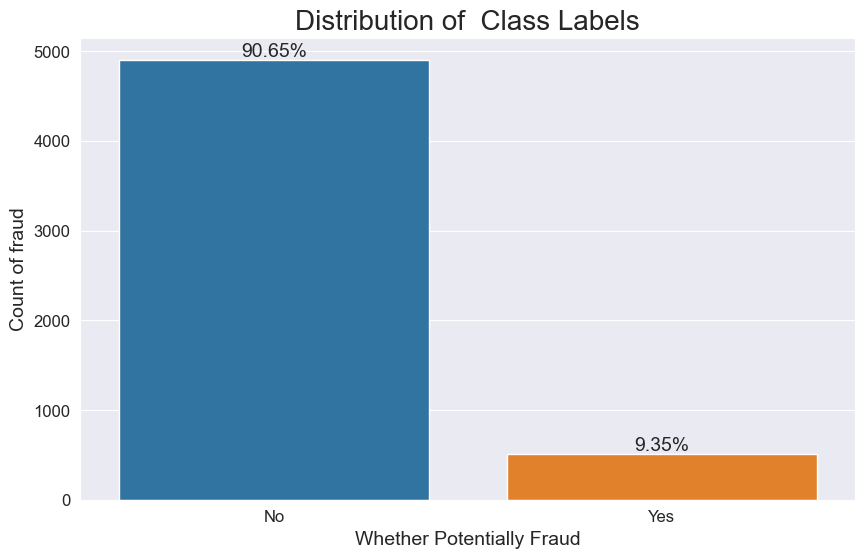

In [7]:
# Check distribution of potential Fraudulent providers
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
ax = sns.countplot(x='PotentialFraud',data=Train)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Distribution of  Class Labels', fontsize=20)
plt.xlabel('Whether Potentially Fraud', size = 14)
plt.ylabel('Count of fraud', size = 14)
percentage_without_hue(ax, Train['PotentialFraud'], 0,40,14)

### Observation:
This is an highly imbalanced dataset. There are 10% fraudulent providers and 90% non-fraudulent providers.

## Analyze Train_Beneficiary/Test_Beneficiary Data

In [8]:
Train_Beneficiary.head(2)

BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001  1943-01-01  NaN       1     1                     0     39   
1  BENE11002  1936-09-01  NaN       2     1                     0     39   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  \
0     230                   12                   12                      1   
1     280                   12                   12                      2   

   ChronicCond_Heartfailure  ChronicCond_KidneyDisease  ChronicCond_Cancer  \
0                         2                          1                   2   
1                         2                          2                   2   

   ChronicCond_ObstrPulmonary  ChronicCond_Depression  ChronicCond_Diabetes  \
0                           2                       1                     1   
1                           2                       2                     2   

   ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  \
0                          1                         2   
1                          2                         2   

   ChronicCond_rheumatoidarthritis  ChronicCond_stroke  \
0                                1                   1   
1                                2                   2   

   IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt  \
0                     36000                   3204                        60   
1                         0                      0                        30   

   OPAnnualDeductibleAmt  
0                     70  
1                     50

In [9]:
# Replacing 2 with 0 for chronic conditions, Zero indicates chronic condition is No

Train_Beneficiary = Train_Beneficiary.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

# For RenalDiseaseIndicator replacing 'Y' with 1
Train_Beneficiary = Train_Beneficiary.replace({'RenalDiseaseIndicator': 'Y'}, 1)

Test_Beneficiary = Test_Beneficiary.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

Test_Beneficiary = Test_Beneficiary.replace({'RenalDiseaseIndicator': 'Y'}, 1)

In [10]:
# convert all the chronic conditions column datatypes to numeric
Train_Beneficiary[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]] = Train_Beneficiary[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]].apply(pd.to_numeric)

Test_Beneficiary[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]] = Test_Beneficiary[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]].apply(pd.to_numeric)

In [11]:
# calculate patient risk score by summing up all the chronic conditions.
# The higher risk score indicates the health of the patient is not good

Train_Beneficiary['Patient_Risk_Score'] = Train_Beneficiary['ChronicCond_Alzheimer'] + Train_Beneficiary['ChronicCond_Heartfailure'] + \
                                        Train_Beneficiary['ChronicCond_KidneyDisease'] + Train_Beneficiary['ChronicCond_Cancer'] +\
                                        Train_Beneficiary['ChronicCond_ObstrPulmonary'] + Train_Beneficiary['ChronicCond_Depression'] +\
                                    Train_Beneficiary['ChronicCond_Diabetes'] + Train_Beneficiary['ChronicCond_IschemicHeart'] +\
                                    Train_Beneficiary['ChronicCond_Osteoporasis'] + Train_Beneficiary['ChronicCond_rheumatoidarthritis'] +\
                                    Train_Beneficiary['ChronicCond_stroke'] + Train_Beneficiary['RenalDiseaseIndicator'] 

# calculate patient risk score by summing up all risk scores
Test_Beneficiary['Patient_Risk_Score'] = Test_Beneficiary['ChronicCond_Alzheimer'] + Test_Beneficiary['ChronicCond_Heartfailure'] + \
                                        Test_Beneficiary['ChronicCond_KidneyDisease'] + Test_Beneficiary['ChronicCond_Cancer'] +\
                                        Test_Beneficiary['ChronicCond_ObstrPulmonary'] + Test_Beneficiary['ChronicCond_Depression'] +\
                                    Test_Beneficiary['ChronicCond_Diabetes'] + Test_Beneficiary['ChronicCond_IschemicHeart'] +\
                                    Test_Beneficiary['ChronicCond_Osteoporasis'] + Test_Beneficiary['ChronicCond_rheumatoidarthritis'] +\
                                    Test_Beneficiary['ChronicCond_stroke'] + Test_Beneficiary['RenalDiseaseIndicator'] 

In [12]:
# Replacing '2' with '0' for Gender Type
Train_Beneficiary = Train_Beneficiary.replace({'Gender': 2}, 0)

Test_Beneficiary = Test_Beneficiary.replace({'Gender': 2}, 0)

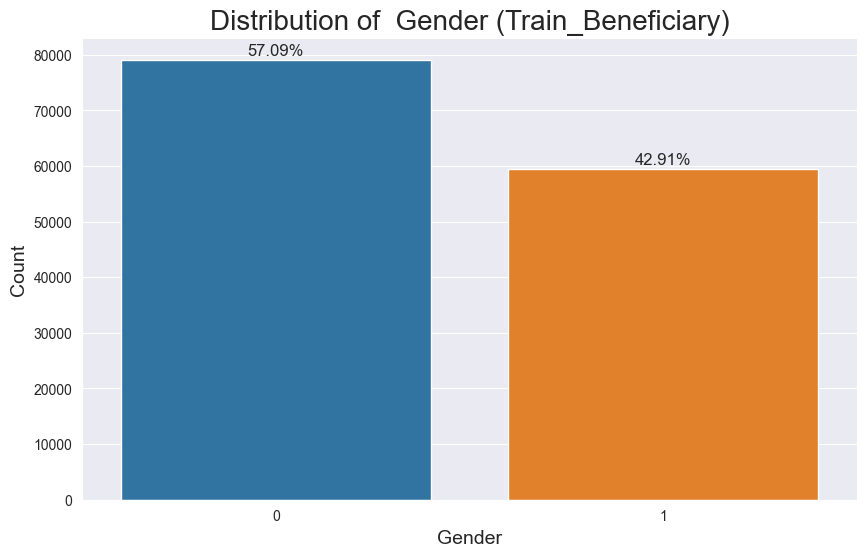

In [13]:
# Plot distribution of gender in Beneficiaries data
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Gender',data=Train_Beneficiary, order = Train_Beneficiary['Gender'].value_counts().index)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title('Distribution of  Gender (Train_Beneficiary)', fontsize=20)
plt.xlabel('Gender', size = 14)
plt.ylabel('Count', size = 14)
percentage_without_hue(ax, Train_Beneficiary['Gender'], 0,800,12)


### Observation:
The ratio of genders in beneficiary data is Gender_0 : Gender1 = 57% : 43%.

#### Plotting top 20 States in terms of beneficiary count

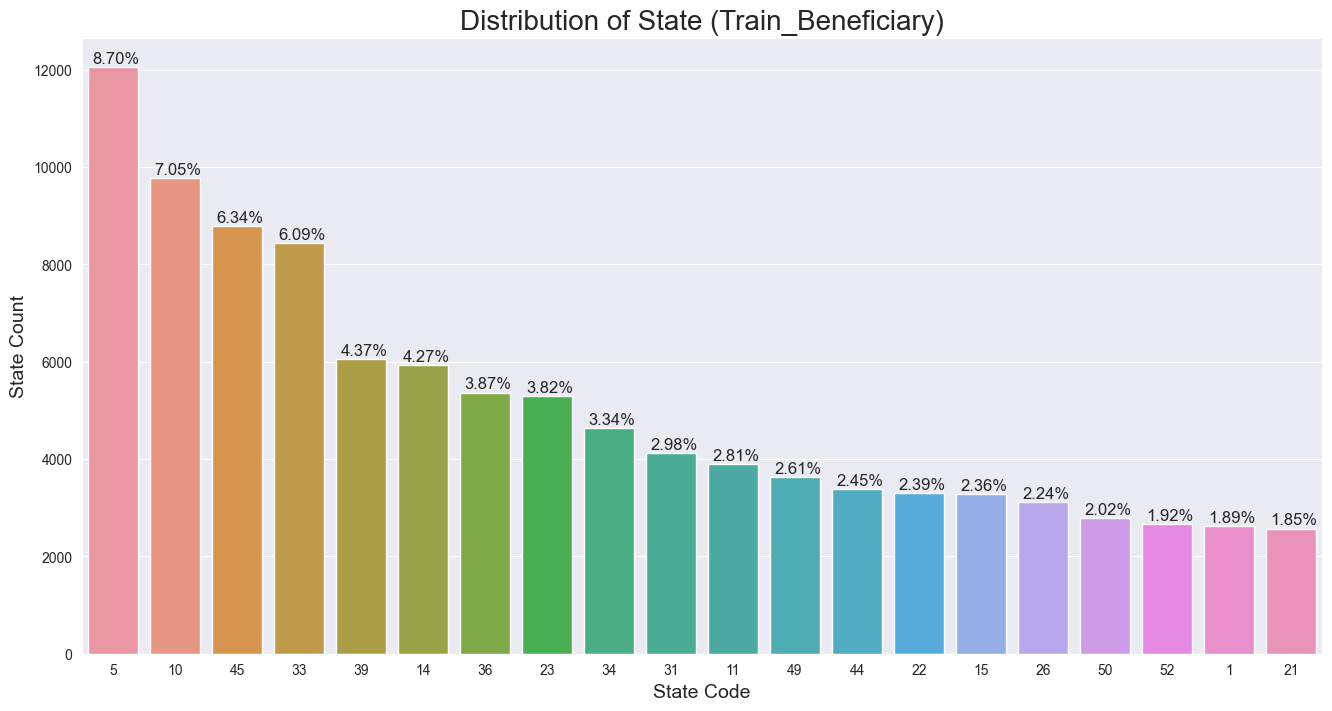

In [14]:
# Plot top 20 states from where the beneficiaries belong
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='State',y=None, data=Train_Beneficiary, orient ="v", order = Train_Beneficiary['State'].value_counts().head(20).index)
plt.title('Distribution of State (Train_Beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('State Code', size = 14)
plt.ylabel('State Count', size = 14)
percentage_without_hue(ax, Train_Beneficiary['State'], 0.05, 80,12)

### Observation:
1. Top 20 states in terms of beneficiary count are shown in the above pic.
2. States with code 5, 10, 45, 33 and 39 are the top 5 states.
3. 8.7% of the beneficiaries belongs to state 5

#### Plotting top 20 Countries in terms of beneficiary count

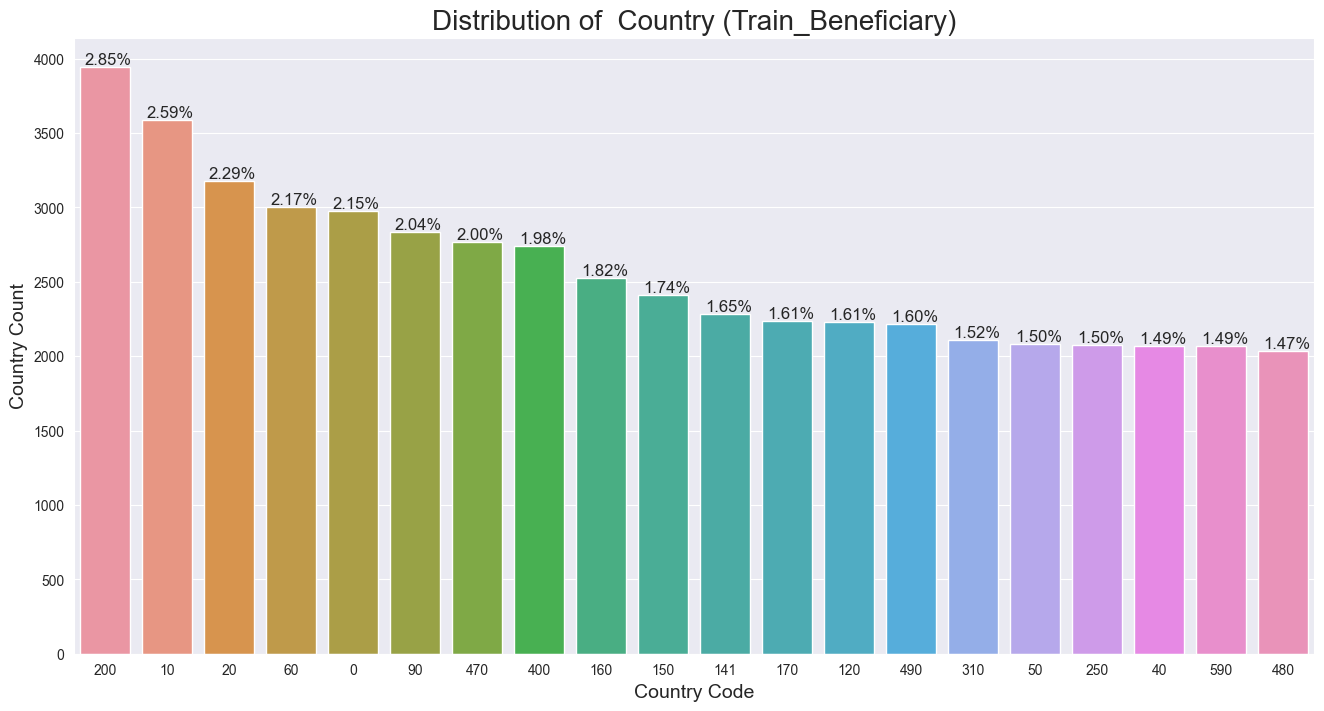

In [15]:
# Plot top 20 Country from where the beneficiaries belong
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='County',y=None, data=Train_Beneficiary, orient ="v", order = Train_Beneficiary['County'].value_counts().head(20).index)
plt.title('Distribution of  Country (Train_Beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Country Code', size = 14)
plt.ylabel('Country Count', size = 14)
percentage_without_hue(ax, Train_Beneficiary['County'], 0.05, 20,12)

### Observation:
1. Top 20 countries in terms of beneficiary count are shown in the above pic.
2. Countries with code 200, 10, 20, 60 and 0 are the top 5 states.
3. 2.85% of the beneficiaries belongs to country code 200

#### Plotting countplot of Race in the beneficiary data

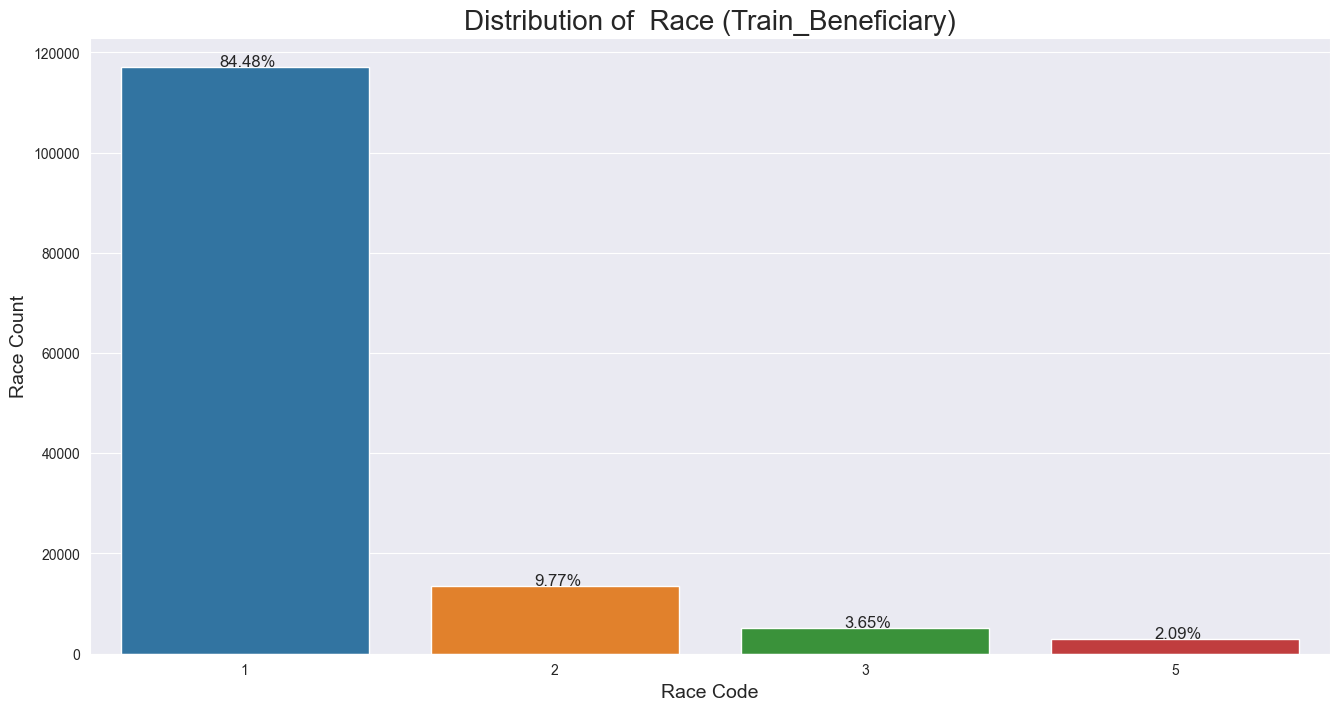

In [16]:
# Plot distribution of race in beneficiaries data
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='Race',y=None, data=Train_Beneficiary, orient ="v", order = Train_Beneficiary['Race'].value_counts().index)
plt.title('Distribution of  Race (Train_Beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Race Code', size = 14)
plt.ylabel('Race Count', size = 14)
percentage_without_hue(ax, Train_Beneficiary['Race'], 0.01, 200,12)

### Observation:
1. Race 1 is the most in terms of beneficiary count.
2. 85% beneficiaries belongs to race 1.
3. There is no race 4 in the dataset.

#### Plot the distribution of the Patient Risk Score in the beneficiary data to check overall health conditions of all the beneficiaries.

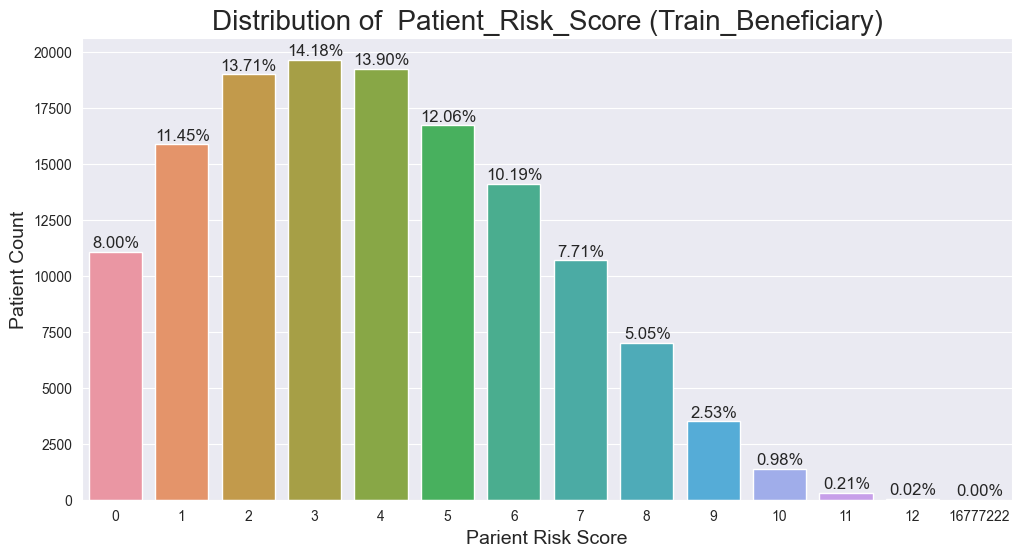

In [17]:
# Distribition of patient risk score
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Patient_Risk_Score',y=None, data=Train_Beneficiary, orient ="v")
plt.title('Distribution of  Patient_Risk_Score (Train_Beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Parient Risk Score', size = 14)
plt.ylabel('Patient Count', size = 14)
percentage_without_hue(ax, Train_Beneficiary['Patient_Risk_Score'], 0.01, 200,12)

### Observation:
1. The distribution of patient risk score is right tailed.
2. Most of the patients with risk score 2, 3, 4, 5.
3. Very few patients are there with risk score 9, 10, 11, 12

#### Plot the countplot of NoOfMonths_PartACov for all beneficiaries

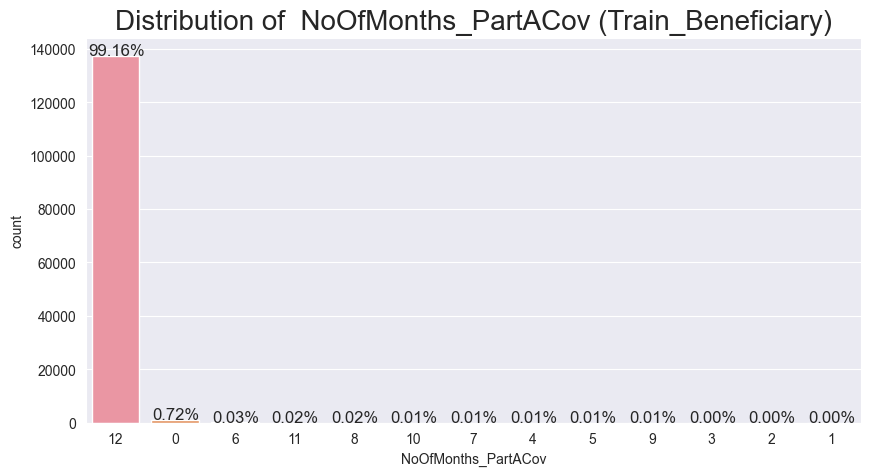

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='NoOfMonths_PartACov',y=None, data=Train_Beneficiary, orient ="v", order = Train_Beneficiary['NoOfMonths_PartACov'].value_counts().index)
plt.title('Distribution of  NoOfMonths_PartACov (Train_Beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
percentage_without_hue(ax, Train_Beneficiary['Race'], 0.01, 200,12)

### Observation:
1. 99% patients covered Part A for 12 months.

#### Plot the countplot of NoOfMonths_PartBCov for all beneficiaries

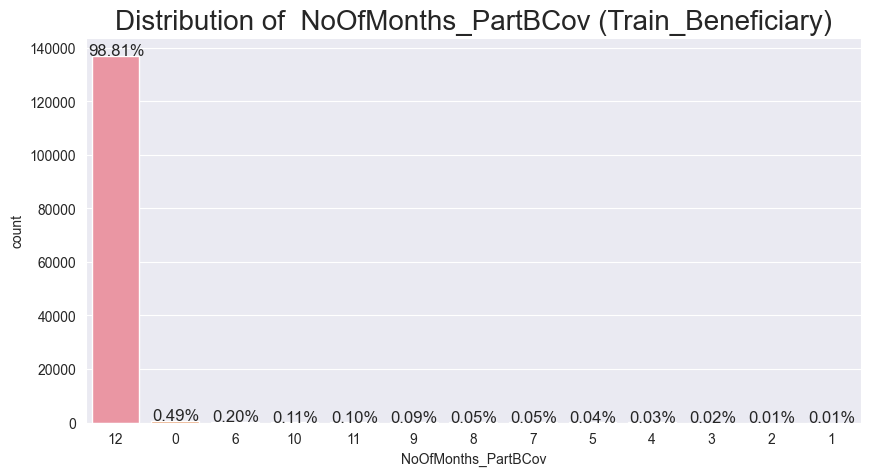

In [19]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='NoOfMonths_PartBCov',y=None, data=Train_Beneficiary, orient ="v", order = Train_Beneficiary['NoOfMonths_PartBCov'].value_counts().index)
plt.title('Distribution of  NoOfMonths_PartBCov (Train_Beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
percentage_without_hue(ax, Train_Beneficiary['Race'], 0.01, 200,12)

### Observation:
1. 98% patients covered Part B for 12 months.

In [20]:
# Calculate total inpatient reimbursement amount for all the beneficiaries
Train_Beneficiary.IPAnnualReimbursementAmt.sum()

507162970

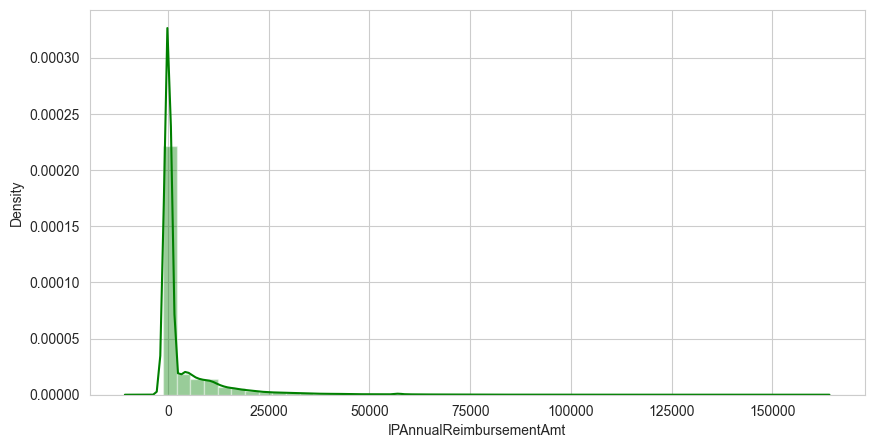

In [21]:
# Plot distribution of IPAnnualReimbursementAmt
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.distplot(Train_Beneficiary['IPAnnualReimbursementAmt'], kde = True, color ='green', bins = 50)
plt.show()

In [22]:
for p in range(25,101,25):
    print(p, ",", np.percentile(Train_Beneficiary['IPAnnualReimbursementAmt'], p), end=" || ")

25 , 0.0 || 50 , 0.0 || 75 , 2280.0 || 100 , 161470.0 || 

In [23]:
for p in range(90,100,1):
    print(p, ",", np.percentile(Train_Beneficiary['IPAnnualReimbursementAmt'], p), end=" || ")

90 , 12000.0 || 91 , 13000.0 || 92 , 14400.0 || 93 , 16000.0 || 94 , 18000.0 || 95 , 20260.0 || 96 , 24000.0 || 97 , 28243.50000000006 || 98 , 35000.0 || 99 , 49000.0 || 

In [24]:
for p in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(p, ",", np.percentile(Train_Beneficiary['IPAnnualReimbursementAmt'], p), end=" || ")

99.1 , 51110.0 || 99.2 , 54000.0 || 99.3 , 57000.0 || 99.4 , 57100.0 || 99.5 , 59210.0 || 99.6 , 63000.0 || 99.7 , 67333.39999999967 || 99.8 , 74000.0 || 99.9 , 87000.0 || 100 , 161470.0 || 

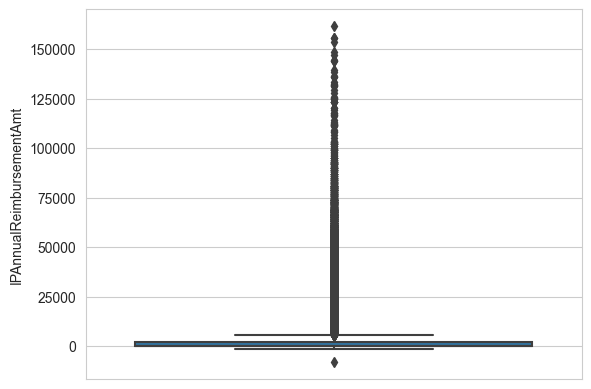

In [25]:
# Plot boxplot for IPAnnualReimbursementAmt
sns.boxplot(y='IPAnnualReimbursementAmt', data=Train_Beneficiary)
plt.show()

### Observation:

1. 25th and 50th percentile of annual reimbursement amount is zero.
2. 75th and 99th percentile of annual reimbursement amount are 2280 and 49000 respectively.
3. There may be some outliers as 100th percentile is 161470.
4. Total annual reimbursement amount is 507162970.

In [26]:
# Calculate total inpatient deductible amount for all the beneficiaries
Train_Beneficiary.IPAnnualDeductibleAmt.sum()

55401242

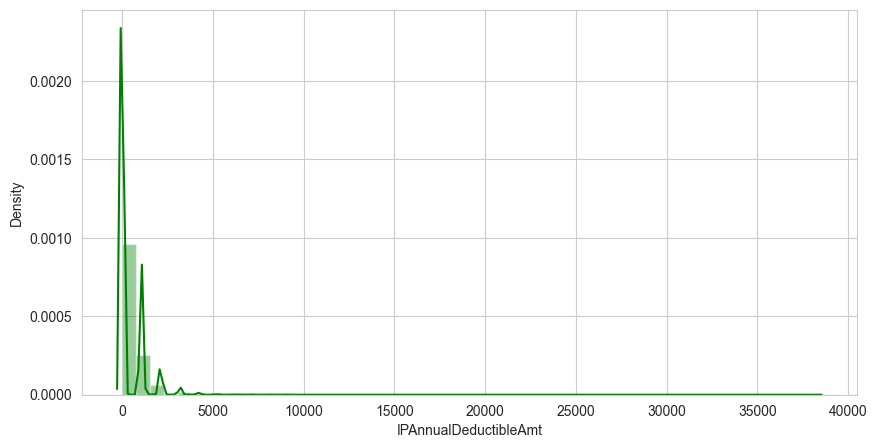

In [27]:
# Plot distribution of IPAnnualDeductibleAmt
sns.set_style('whitegrid') 
plt.figure(figsize=(10, 5))
sns.distplot(Train_Beneficiary['IPAnnualDeductibleAmt'], kde = True, color ='green', bins = 50)
plt.show()

In [28]:
# check the percentiles
for p in range(25,101,25):
    print(p, ",", np.percentile(Train_Beneficiary['IPAnnualDeductibleAmt'], p), end=" || ")
    

print('\n'+'='*100)

for p in range(90,100,1):
    print(p, ",", np.percentile(Train_Beneficiary['IPAnnualDeductibleAmt'], p), end=" || ")
    
print('\n'+'='*100)

for p in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(p, ",", np.percentile(Train_Beneficiary['IPAnnualDeductibleAmt'], p), end=" || ")

25 , 0.0 || 50 , 0.0 || 75 , 1068.0 || 100 , 38272.0 || 
90 , 1068.0 || 91 , 1068.0 || 92 , 1068.0 || 93 , 1068.0 || 94 , 2136.0 || 95 , 2136.0 || 96 , 2136.0 || 97 , 2136.0 || 98 , 2136.0 || 99 , 3204.0 || 
99.1 , 3204.0 || 99.2 , 3204.0 || 99.3 , 4136.0 || 99.4 , 4272.0 || 99.5 , 4272.0 || 99.6 , 4272.0 || 99.7 , 5340.0 || 99.8 , 6272.0 || 99.9 , 9068.0 || 100 , 38272.0 || 

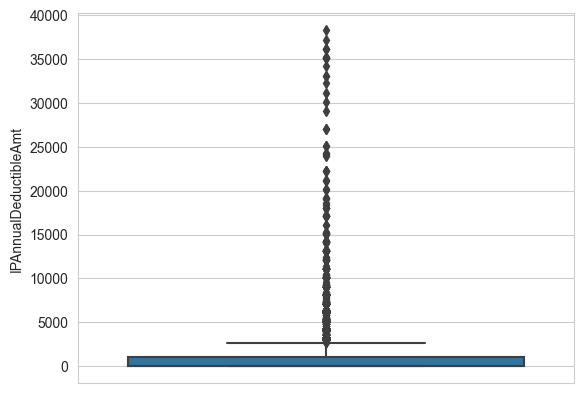

In [29]:
# Plot boxplot of IPAnnualDeductibleAmt
sns.boxplot(y='IPAnnualDeductibleAmt', data=Train_Beneficiary)
plt.show()

### Observation:

1. 25th and 50th percentile of annual deductible amount is zero.
2. 75th and 99th percentile of annual deductible amount are 1068 and 38272 respectively.
3. There may be some outliers as 100th percentile is 38272.
4. Total annual deductible amount is 55401242.

#### Plot Scatterplot IPAnnualDeductibleAmt vs IPAnnualReimbursementAmt

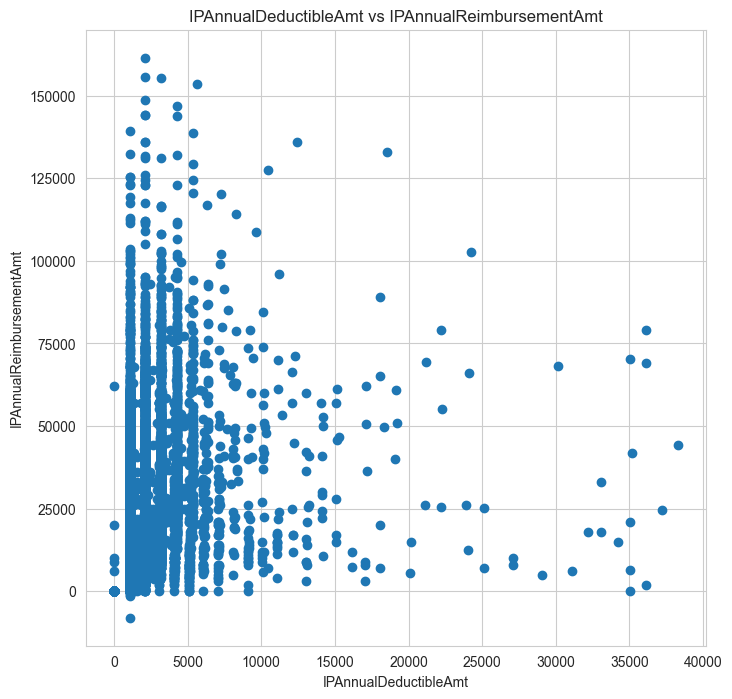

In [30]:
# Plot Scatterplot IPAnnualDeductibleAmt vs IPAnnualReimbursementAmt
plt.figure(figsize=(8, 8))
plt.scatter(Train_Beneficiary.IPAnnualDeductibleAmt, Train_Beneficiary.IPAnnualReimbursementAmt)
plt.xlabel('IPAnnualDeductibleAmt')
plt.ylabel('IPAnnualReimbursementAmt')
plt.title('IPAnnualDeductibleAmt vs IPAnnualReimbursementAmt')
plt.show()

### Observation:

IPAnnualDeductibleAmt indicated the amount paid by the beneficiary anually for inpatient claim and IPAnnualReimbursementAmt indicates the reimbursement amount the beneficiary is eligible for per annum.
1. For some of the patients even though the deductible amount is zero, reimbursement is very high.
2. For some of the patients deductible amount is very high but reimbursement amount zero or very low. <br>

May be these data are wrong due to wrong entry.

In [31]:
# Calculate total outpatient reimbursement amount for all the beneficiaries
Train_Beneficiary.OPAnnualReimbursementAmt.sum()

179876080

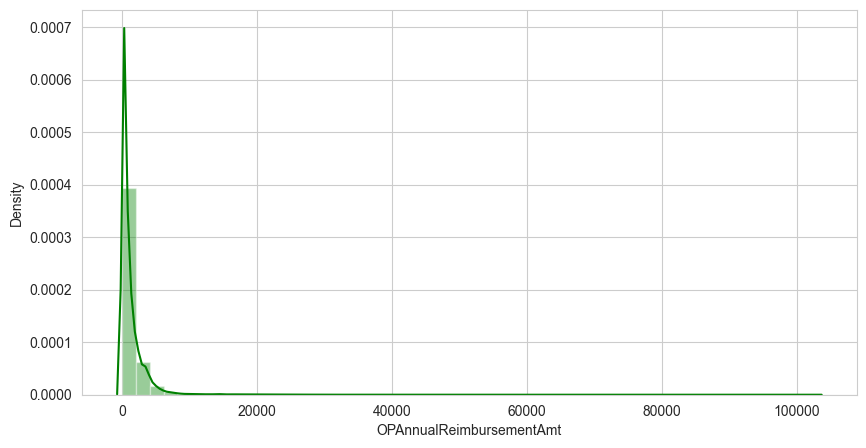

In [32]:
# Plot distribution of OPAnnualReimbursementAmt
sns.set_style('whitegrid') 
plt.figure(figsize=(10, 5))
sns.distplot(Train_Beneficiary['OPAnnualReimbursementAmt'], kde = True, color ='green', bins = 50)
plt.show()

In [33]:
for p in range(25,101,25):
    print(p, ",", np.percentile(Train_Beneficiary['OPAnnualReimbursementAmt'], p), end=" || ")
    

print('\n'+'='*100)

for p in range(90,100,1):
    print(p, ",", np.percentile(Train_Beneficiary['OPAnnualReimbursementAmt'], p), end=" || ")
    
print('\n'+'='*100)

for p in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(p, ",", np.percentile(Train_Beneficiary['OPAnnualReimbursementAmt'], p), end=" || ")

25 , 170.0 || 50 , 570.0 || 75 , 1500.0 || 100 , 102960.0 || 
90 , 3230.0 || 91 , 3380.500000000029 || 92 , 3560.0 || 93 , 3780.0 || 94 , 4030.0 || 95 , 4370.0 || 96 , 4850.0 || 97 , 5540.0 || 98 , 6850.0 || 99 , 11514.500000000116 || 
99.1 , 12680.250000000233 || 99.2 , 13840.0 || 99.3 , 14741.149999999907 || 99.4 , 16173.400000000256 || 99.5 , 17666.750000000175 || 99.6 , 19197.79999999999 || 99.7 , 21406.699999999837 || 99.8 , 24230.0 || 99.9 , 28694.45000000007 || 100 , 102960.0 || 

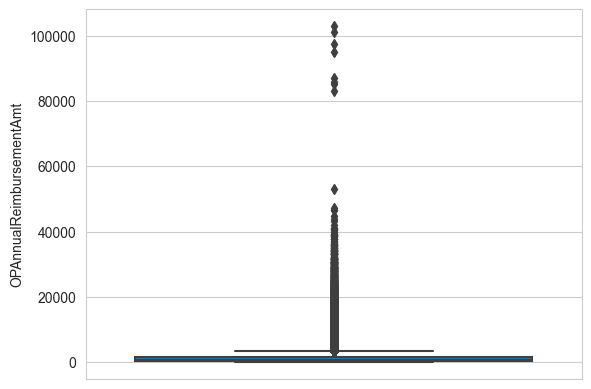

In [34]:
# plot boxplot for OPAnnualReimbursementAmt
sns.boxplot(y='OPAnnualReimbursementAmt', data=Train_Beneficiary)
plt.show()

### Observation:

1. 25th and 50th percentile of outpatient annual reimbursement amounts are 170 and 570 respectively.
2. 75th and 99th percentile of outpatient annual reimbursement amount are 1500 and 11514 respectively.
3. There may be some outliers as 100th percentile is 102960.
4. Total outpatient annual reimbursement amount is 179876080.

In [35]:
# Calculate total outpatient deductible amount for all the beneficiaries
Train_Beneficiary.OPAnnualDeductibleAmt.sum()

52335131

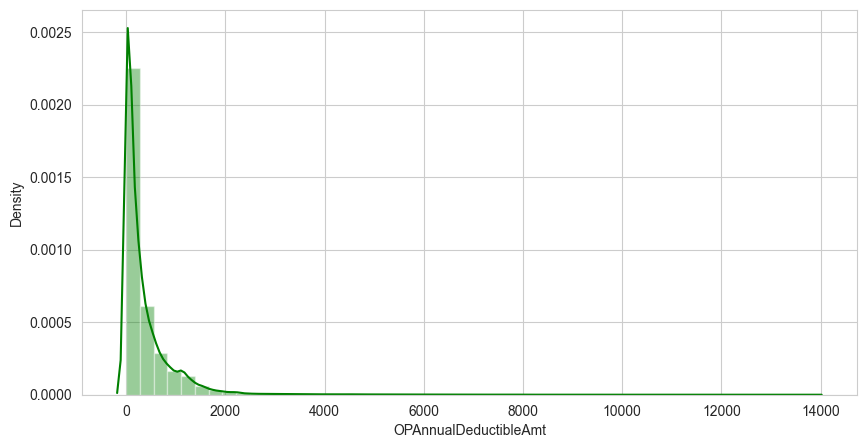

In [36]:
# Plot distribution of OPAnnualDeductibleAmt
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.distplot(Train_Beneficiary['OPAnnualDeductibleAmt'], kde = True, color ='green', bins = 50)
plt.show()

In [37]:
for p in range(25,101,25):
    print(p, ",", np.percentile(Train_Beneficiary['OPAnnualDeductibleAmt'], p), end=" || ")
    

print('\n'+'='*100)

for p in range(90,100,1):
    print(p, ",", np.percentile(Train_Beneficiary['OPAnnualDeductibleAmt'], p), end=" || ")
    
print('\n'+'='*100)

for p in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(p, ",", np.percentile(Train_Beneficiary['OPAnnualDeductibleAmt'], p), end=" || ")

25 , 40.0 || 50 , 170.0 || 75 , 460.0 || 100 , 13840.0 || 
90 , 1000.0 || 91 , 1060.0 || 92 , 1120.0 || 93 , 1180.0 || 94 , 1250.0 || 95 , 1340.0 || 96 , 1470.0 || 97 , 1650.0 || 98 , 1999.7999999999884 || 99 , 2960.0 || 
99.1 , 3180.0 || 99.2 , 3435.5999999999767 || 99.3 , 3720.0 || 99.4 , 4100.0 || 99.5 , 4502.250000000058 || 99.6 , 4970.0 || 99.7 , 5440.0 || 99.8 , 6070.0 || 99.9 , 7040.0 || 100 , 13840.0 || 

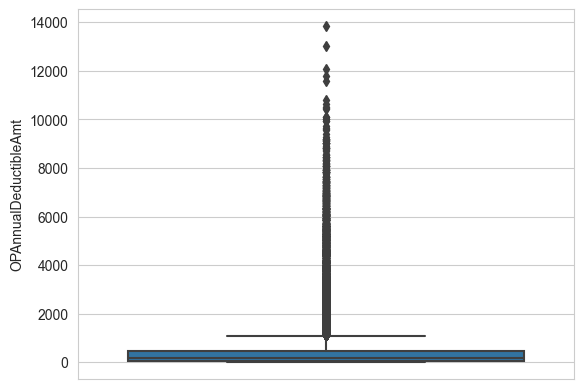

In [38]:
# Plot boxplot for OPAnnualDeductibleAmt
sns.boxplot(y='OPAnnualDeductibleAmt', data=Train_Beneficiary)
plt.show()

### Observation:

1. 25th and 50th percentile of annual reimbursement amounts are 40 and 170 respectively.
2. 75th and 99th percentile of annual reimbursement amount are 460 and 2960 respectively.
3. There may be some outliers as 100th percentile is 13840.
4. Total annual reimbursement amount is 52335131.

#### Plot Scatterplot OPAnnualDeductibleAmt vs OPAnnualReimbursementAmt

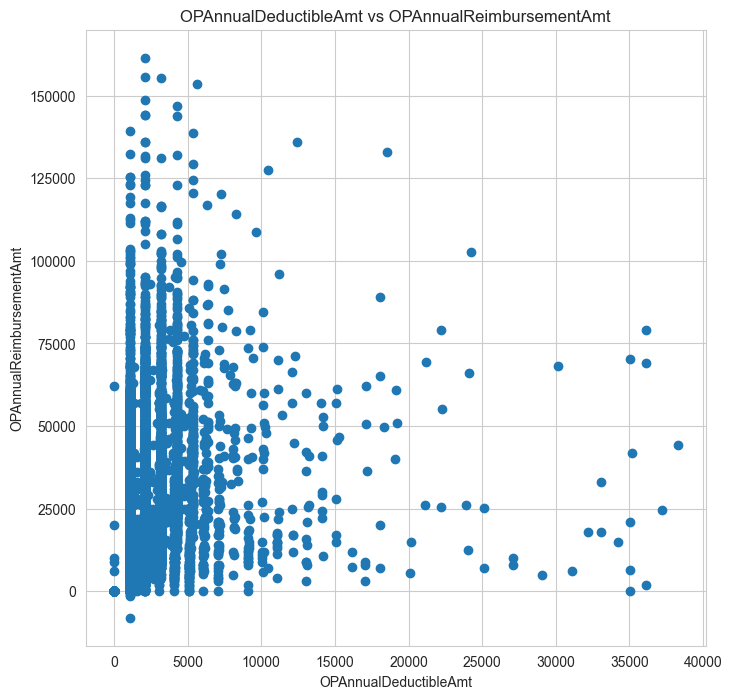

In [39]:
# Plot Scatterplot IPAnnualDeductibleAmt vs IPAnnualReimbursementAmt
plt.figure(figsize=(8, 8))
plt.scatter(Train_Beneficiary.IPAnnualDeductibleAmt, Train_Beneficiary.IPAnnualReimbursementAmt)
plt.xlabel('OPAnnualDeductibleAmt')
plt.ylabel('OPAnnualReimbursementAmt')
plt.title('OPAnnualDeductibleAmt vs OPAnnualReimbursementAmt')
plt.show()

### Observation:

OPAnnualDeductibleAmt indicated the amount paid by the beneficiary anually for outpatient claim and OPAnnualReimbursementAmt indicates the reimbursement amount the beneficiary is eligible for per annum.
1. For some of the patients even though the deductible amount is zero, reimbursement is very high.
2. For some of the patients deductible amount is very high but reimbursement amount zero or very low. <br>

May be these data are wrong due to wrong entry.

In [40]:
# Convert Date of Birth and Date of Death from String to Datetime format
Train_Beneficiary['DOB'] = pd.to_datetime(Train_Beneficiary['DOB'] , format = '%Y-%m-%d')
Train_Beneficiary['DOD'] = pd.to_datetime(Train_Beneficiary['DOD'],format = '%Y-%m-%d')

Test_Beneficiary['DOB'] = pd.to_datetime(Test_Beneficiary['DOB'] , format = '%Y-%m-%d')
Test_Beneficiary['DOD'] = pd.to_datetime(Test_Beneficiary['DOD'],format = '%Y-%m-%d')

In [41]:
# Check last date DOD
Train_Beneficiary['DOD'].max()

Timestamp('2009-12-01 00:00:00')

In [42]:
# Get the birth month and Birth year for DOB and DOD
Train_Beneficiary['Birth_Year'] = Train_Beneficiary['DOB'].dt.year
Train_Beneficiary['Birth_Month'] = Train_Beneficiary['DOB'].dt.month

Test_Beneficiary['Birth_Year'] = Test_Beneficiary['DOB'].dt.year
Test_Beneficiary['Birth_Month'] = Test_Beneficiary['DOB'].dt.month

#### Calculate patient's age based on DOD, if DOD is not available calculate age based on the maximum date available in the data

In [43]:
Train_Beneficiary['Patient_Age'] = round(((Train_Beneficiary['DOD'] - Train_Beneficiary['DOB']).dt.days)/365)
Train_Beneficiary.Patient_Age.fillna(round(((pd.to_datetime('2009-12-01',format ='%Y-%m-%d')-Train_Beneficiary['DOB']).dt.days)/365),inplace=True)

Test_Beneficiary['Patient_Age'] = round(((Test_Beneficiary['DOD'] - Test_Beneficiary['DOB']).dt.days)/365)
Test_Beneficiary.Patient_Age.fillna(round(((pd.to_datetime('2009-12-01',format ='%Y-%m-%d')-Test_Beneficiary['DOB']).dt.days)/365),inplace=True)

#### Check the distribution of Age in Beneficiary Data

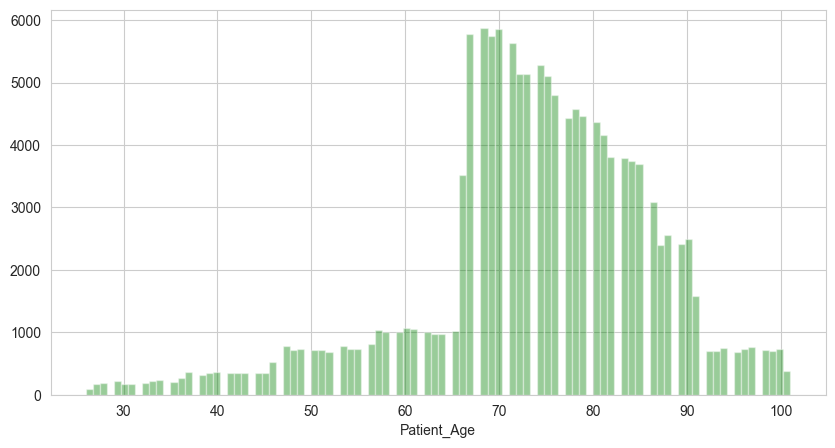

In [44]:
# Plot distribution of age
sns.set_style('whitegrid') 
plt.figure(figsize=(10, 5))
sns.distplot(Train_Beneficiary['Patient_Age'], kde = False, color ='green', bins = 100)
plt.show()

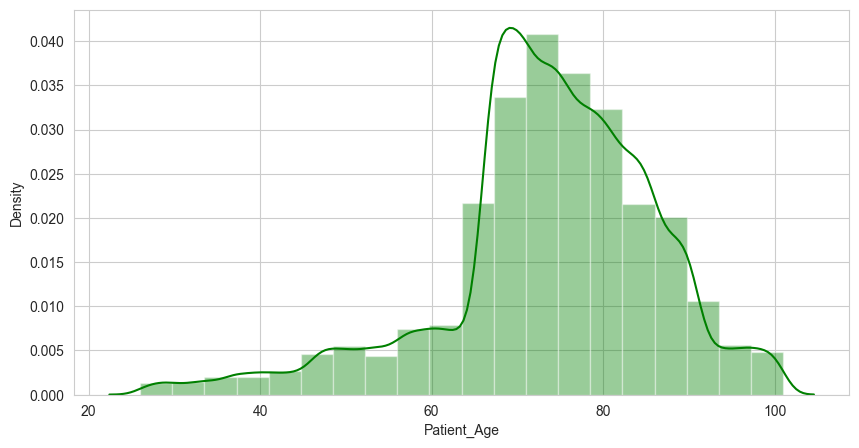

In [45]:
# Plot distribution of age
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.distplot(Train_Beneficiary['Patient_Age'], kde = True, color ='green', bins = 20)
plt.show()

###### Observation:

1. There are very less number of patients in the age group 20-40
2. Most of the patients are with age group 60-90
3. Number of patients are less in the age group 90-100

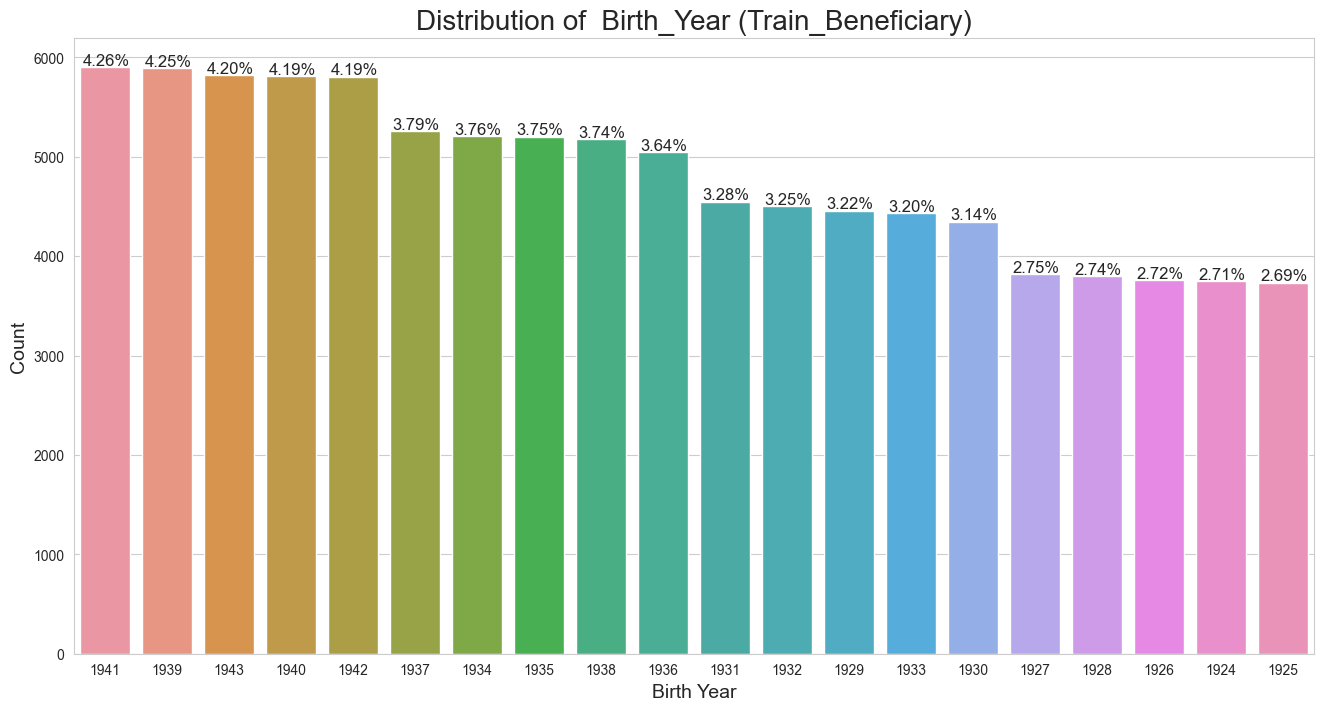

In [46]:
# Plot top 20 years in terms of patient's birth year count
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='Birth_Year',y=None, data=Train_Beneficiary, orient ="v", order = Train_Beneficiary['Birth_Year'].value_counts().iloc[:20].index)
plt.title('Distribution of  Birth_Year (Train_Beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Birth Year', size = 14)
plt.ylabel('Count', size = 14)
percentage_without_hue(ax, Train_Beneficiary['Birth_Year'], 0.01, 20,12)

### Observation:

1. 1941, 1939, 1943, 1940 and 1942 are the top years with patient's DOB count with 4% each of the total patients.

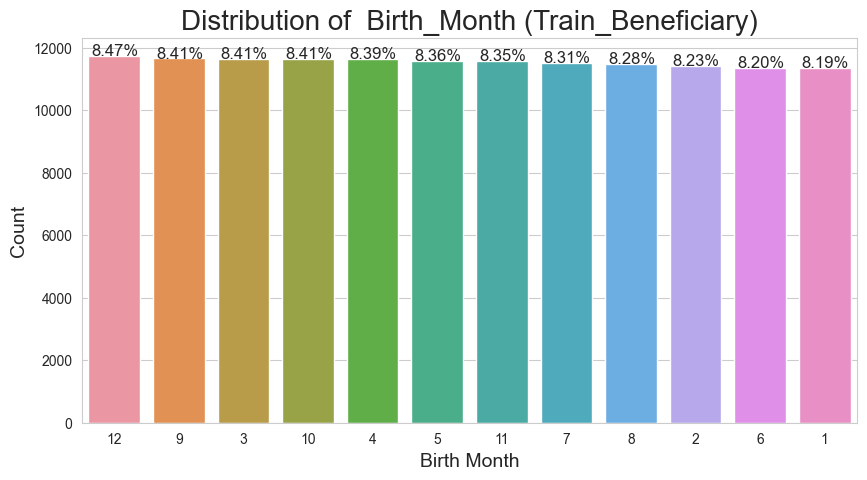

In [47]:
# Plot distribution of birth month of patients
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Birth_Month',y=None, data=Train_Beneficiary, orient ="v", order = Train_Beneficiary['Birth_Month'].value_counts().index)
plt.title('Distribution of  Birth_Month (Train_Beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Birth Month', size = 14)
plt.ylabel('Count', size = 14)
percentage_without_hue(ax, Train_Beneficiary['Birth_Month'], 0.01, 20,12)

### Observation:

1. Date of bitrh of all the patients are almost equally distributed accross all the months.

In [48]:
# Set value=1 if the patient is dead i.e DOD value is not null
Train_Beneficiary['isDead'] = 0
Train_Beneficiary.loc[Train_Beneficiary.DOD.notna(), 'isDead'] = 1
Test_Beneficiary['isDead'] = 0
Test_Beneficiary.loc[Test_Beneficiary.DOD.notna(), 'isDead'] = 1

#### Analyze Train_Inpatient/Test_Inpatient Data

In [49]:
Train_Inpatient.head(2)

BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001  CLM46614   2009-04-12  2009-04-18  PRV55912   
1  BENE11001  CLM66048   2009-08-31  2009-09-02  PRV55907   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                    5000          PHY318495          PHY318495   

  OtherPhysician AdmissionDt ClmAdmitDiagnosisCode  DeductibleAmtPaid  \
0            NaN  2009-04-12                  7866             1068.0   
1            NaN  2009-08-31                  6186             1068.0   

  DischargeDt DiagnosisGroupCode ClmDiagnosisCode_1 ClmDiagnosisCode_2  \
0  2009-04-18                201               1970               4019   
1  2009-09-02                750               6186               2948   

  ClmDiagnosisCode_3 ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6  \
0               5853               7843               2768              71590   
1              56400                NaN                NaN                NaN   

  ClmDiagnosisCode_7 ClmDiagnosisCode_8 ClmDiagnosisCode_9  \
0               2724              19889               5849   
1                NaN                NaN                NaN   

  ClmDiagnosisCode_10  ClmProcedureCode_1  ClmProcedureCode_2  \
0                 NaN                 NaN                 NaN   
1                 NaN              7092.0                 NaN   

   ClmProcedureCode_3  ClmProcedureCode_4  ClmProcedureCode_5  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   

   ClmProcedureCode_6  
0                 NaN  
1                 NaN

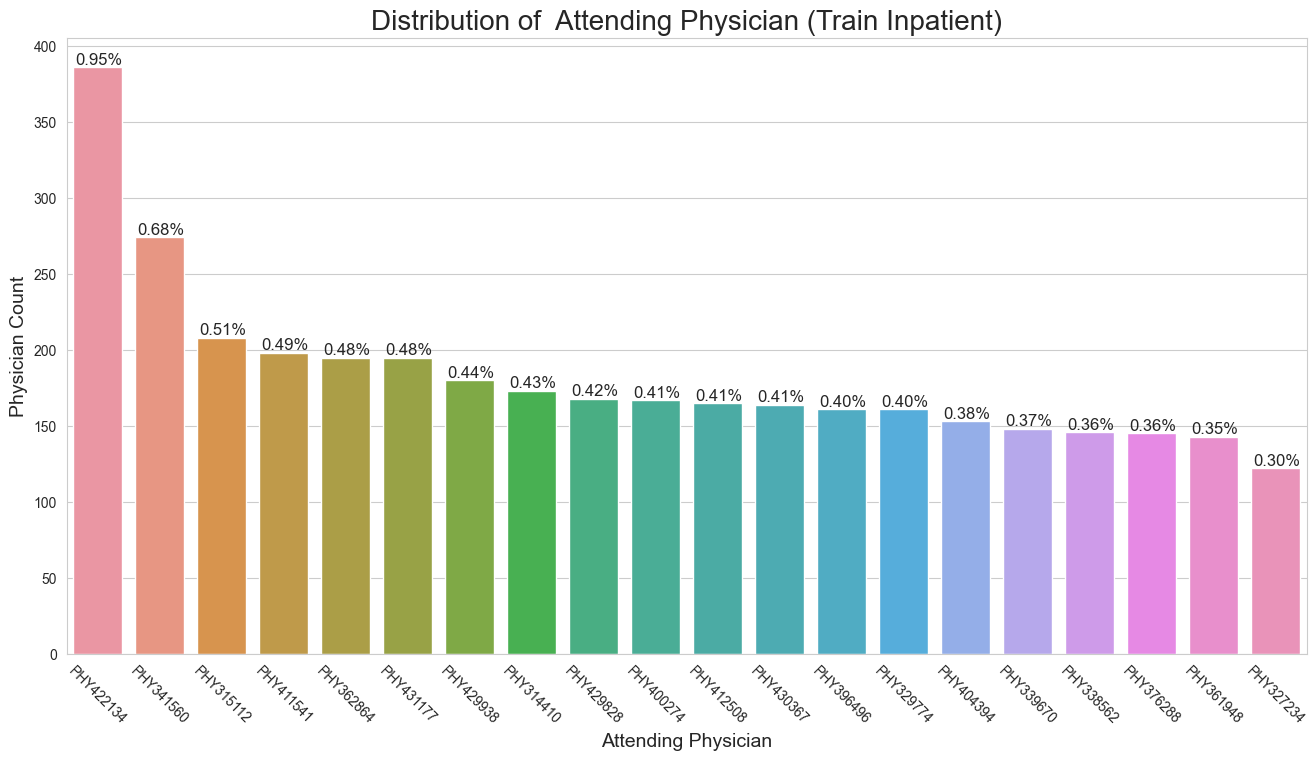

In [50]:
# Plot top 20 Attending Physician in terms of number of patients treated
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='AttendingPhysician',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['AttendingPhysician'].value_counts().iloc[:20].index)
plt.title('Distribution of  Attending Physician (Train Inpatient)', fontsize=20)
plt.xlabel('Attending Physician', size = 14)
plt.ylabel('Physician Count', size = 14)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, Train_Inpatient['AttendingPhysician'], 0.02, 2, 12)

### Observation:

1. PHY422134, PHY341560, PHY315112, PHY411541, PHY362864 are the top 5 attending physicians in terms of number of patients visit.
2. PHY422134 treated ~1% of the total patients.

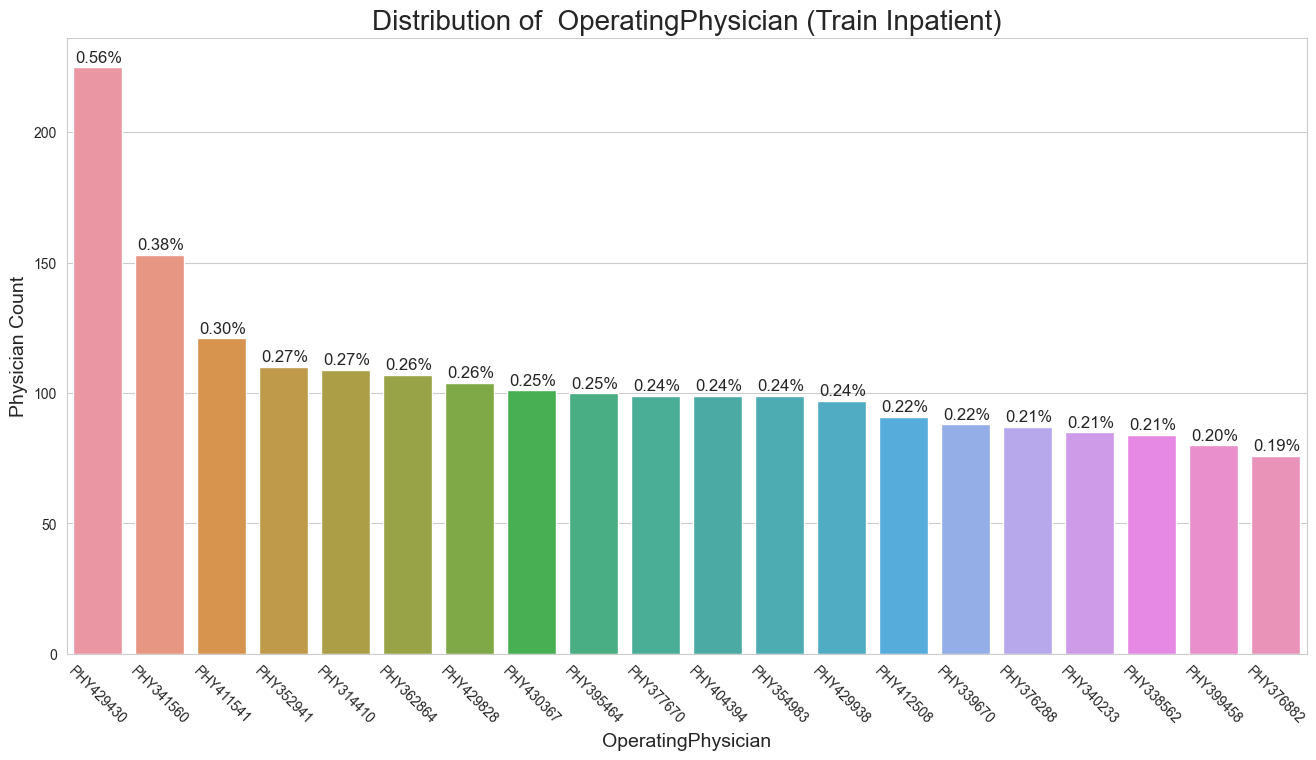

In [51]:
# Plot top 20 Operating Physician in terms of number of patients operated
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='OperatingPhysician',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['OperatingPhysician'].value_counts().iloc[:20].index)
plt.title('Distribution of  OperatingPhysician (Train Inpatient)', fontsize=20)
plt.xlabel('OperatingPhysician', size = 14)
plt.ylabel('Physician Count', size = 14)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, Train_Inpatient['OperatingPhysician'], 0.02, 2, 12)

### Observation:

1. PHY429430, PHY341560, PHY411541, PHY352941, PHY314410 are the top 5 operating physicians in terms of number of patients operation.
2. PHY429430 operated 0.56% of the total patients.

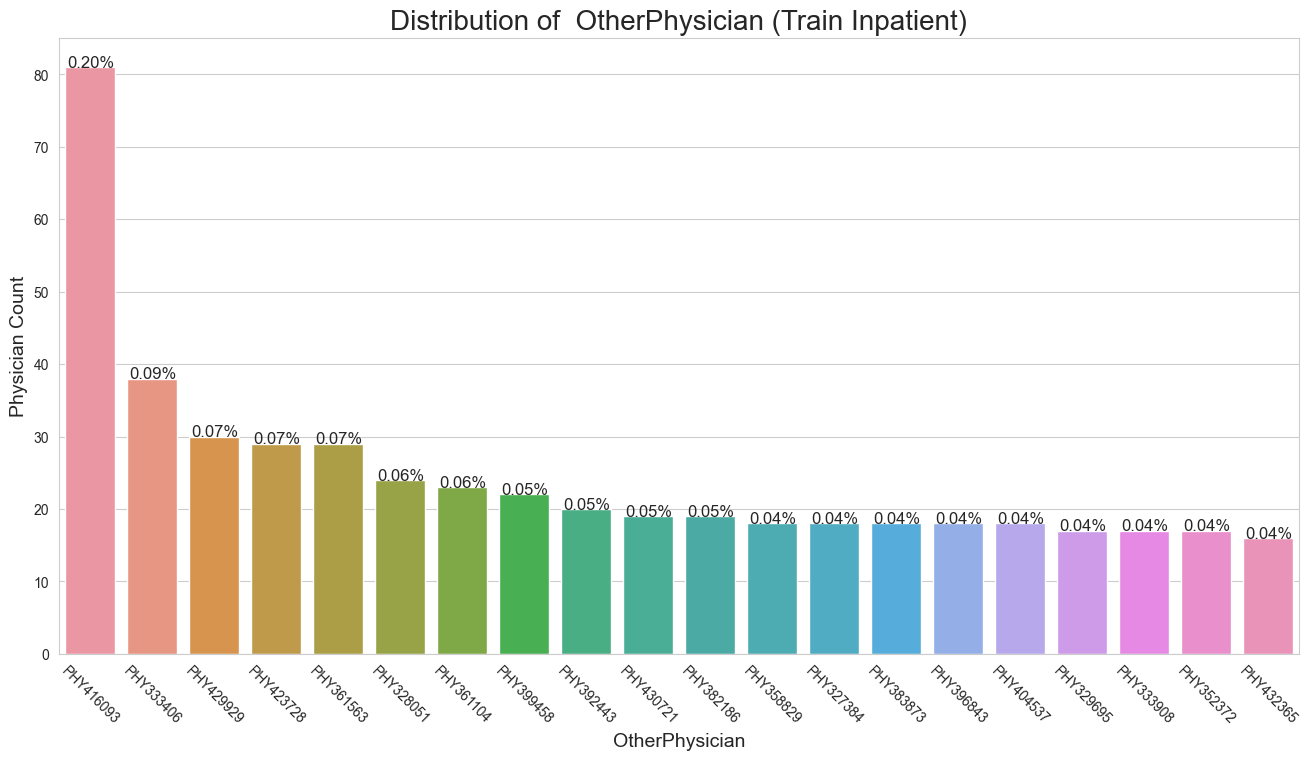

In [52]:
# Plot top 20 Other Physician in terms of number of patients treated
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='OtherPhysician',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['OtherPhysician'].value_counts().iloc[:20].index)
plt.title('Distribution of  OtherPhysician (Train Inpatient)', fontsize=20)
plt.xlabel('OtherPhysician', size = 14)
plt.ylabel('Physician Count', size = 14)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, Train_Inpatient['OtherPhysician'], 0.02, 0, 12)

### Observation:

1. PHY416093, PHY333406, PHY429929, PHY423728, PHY361563 are the top 5 other physicians in terms of number of patients visit.

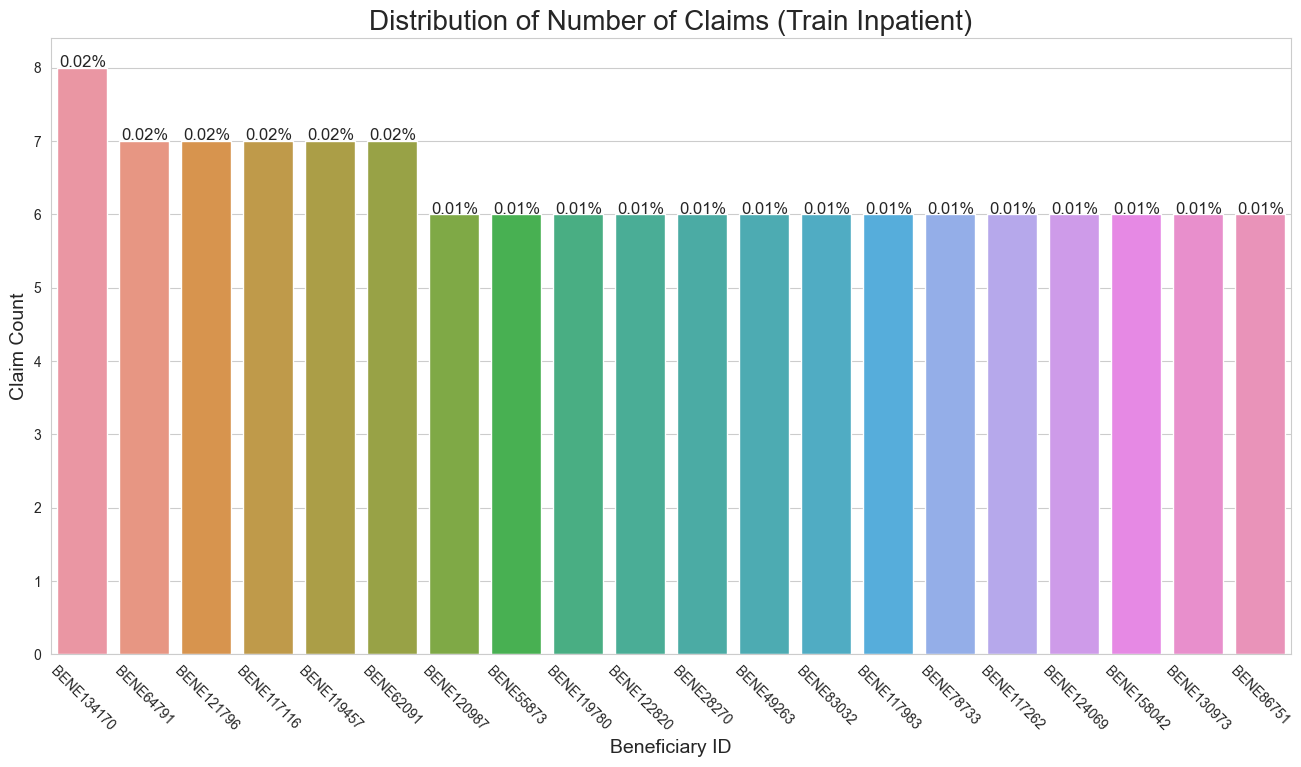

In [53]:
# Distribution of Number of Claims
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='BeneID',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['BeneID'].value_counts().head(20).index)
plt.title('Distribution of Number of Claims (Train Inpatient)', fontsize=20)
plt.xlabel('Beneficiary ID', size = 14)
plt.ylabel('Claim Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, Train_Inpatient['BeneID'], 0.02, 0.01, 12)

### Observation:

1. BENE134170 claimed maximum number of inpatient claims that is 8.
2. Another 5 beneficiaries claimed 7 claims, shown in the plot.

In [54]:
# convert ClaimStartDt, ClaimEndDt from string to datetime format
Train_Inpatient['ClaimStartDt'] = pd.to_datetime(Train_Inpatient['ClaimStartDt'] , format = '%Y-%m-%d')
Train_Inpatient['ClaimEndDt'] = pd.to_datetime(Train_Inpatient['ClaimEndDt'],format = '%Y-%m-%d')

Test_Inpatient['ClaimStartDt'] = pd.to_datetime(Test_Inpatient['ClaimStartDt'] , format = '%Y-%m-%d')
Test_Inpatient['ClaimEndDt'] = pd.to_datetime(Test_Inpatient['ClaimEndDt'],format = '%Y-%m-%d')

# convert AdmissionDt, DischargeDt from string to datetime format
Train_Inpatient['AdmissionDt'] = pd.to_datetime(Train_Inpatient['AdmissionDt'] , format = '%Y-%m-%d')
Train_Inpatient['DischargeDt'] = pd.to_datetime(Train_Inpatient['DischargeDt'],format = '%Y-%m-%d')

Test_Inpatient['AdmissionDt'] = pd.to_datetime(Test_Inpatient['AdmissionDt'] , format = '%Y-%m-%d')
Test_Inpatient['DischargeDt'] = pd.to_datetime(Test_Inpatient['DischargeDt'],format = '%Y-%m-%d')

In [55]:
# Calculate Hospitalization_Duration = DischargeDt - AdmissionDt
Train_Inpatient['Hospitalization_Duration'] = ((Train_Inpatient['DischargeDt'] - Train_Inpatient['AdmissionDt']).dt.days)+1
# Calculate Claim_Period = ClaimEndDt - ClaimStartDt
Train_Inpatient['Claim_Period'] = ((Train_Inpatient['ClaimEndDt'] - Train_Inpatient['ClaimStartDt']).dt.days)+1

Test_Inpatient['Hospitalization_Duration'] = ((Test_Inpatient['DischargeDt'] - Test_Inpatient['AdmissionDt']).dt.days)+1
Test_Inpatient['Claim_Period'] = ((Test_Inpatient['ClaimEndDt'] - Test_Inpatient['ClaimStartDt']).dt.days)+1

#### If the number of days claimed for Inpatient treatment is more than no of days hospitalized then this is suspicious. Hence a feature for the same has been created.

In [56]:
# ExtraClaimDays = Claim_Period - Hospitalization_Duration
Train_Inpatient['ExtraClaimDays'] = np.where(Train_Inpatient['Claim_Period']>Train_Inpatient['Hospitalization_Duration'], Train_Inpatient['Claim_Period'] - Train_Inpatient['Hospitalization_Duration'], 0)
Test_Inpatient['ExtraClaimDays'] = np.where(Test_Inpatient['Claim_Period']>Test_Inpatient['Hospitalization_Duration'], Test_Inpatient['Claim_Period'] - Test_Inpatient['Hospitalization_Duration'], 0)

In [57]:
# Get the months and year of claim start and claim end
Train_Inpatient['ClaimStart_Year'] = Train_Inpatient['ClaimStartDt'].dt.year
Train_Inpatient['ClaimStart_Month'] = Train_Inpatient['ClaimStartDt'].dt.month
Test_Inpatient['ClaimStart_Year'] = Test_Inpatient['ClaimStartDt'].dt.year
Test_Inpatient['ClaimStart_Month'] = Test_Inpatient['ClaimStartDt'].dt.month

Train_Inpatient['ClaimEnd_Year'] = Train_Inpatient['ClaimEndDt'].dt.year
Train_Inpatient['ClaimEnd_Month'] = Train_Inpatient['ClaimEndDt'].dt.month
Test_Inpatient['ClaimEnd_Year'] = Test_Inpatient['ClaimEndDt'].dt.year
Test_Inpatient['ClaimEnd_Month'] = Test_Inpatient['ClaimEndDt'].dt.month

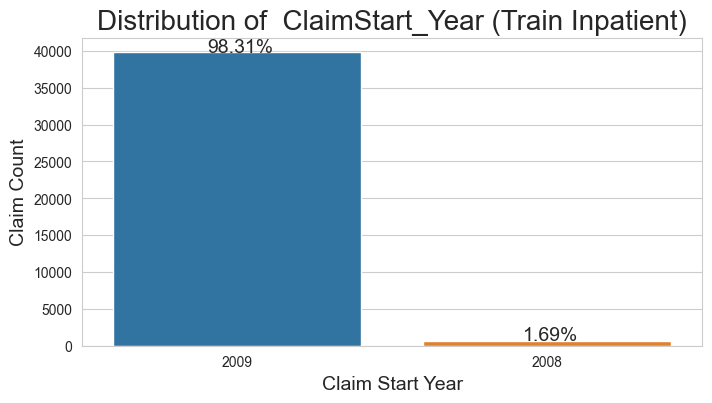

In [58]:
# Plot distribution of claim start year in Train Inpatient data
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='ClaimStart_Year',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['ClaimStart_Year'].value_counts().index)
plt.title('Distribution of  ClaimStart_Year (Train Inpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Claim Start Year', size = 14)
plt.ylabel('Claim Count', size = 14)
percentage_without_hue(ax, Train_Inpatient['ClaimStart_Year'], 0.01, 20,14)

### Observation:

1. For 98.3% of the patients claim started in 2009.
2. Only 1.7 % claim started in 2008

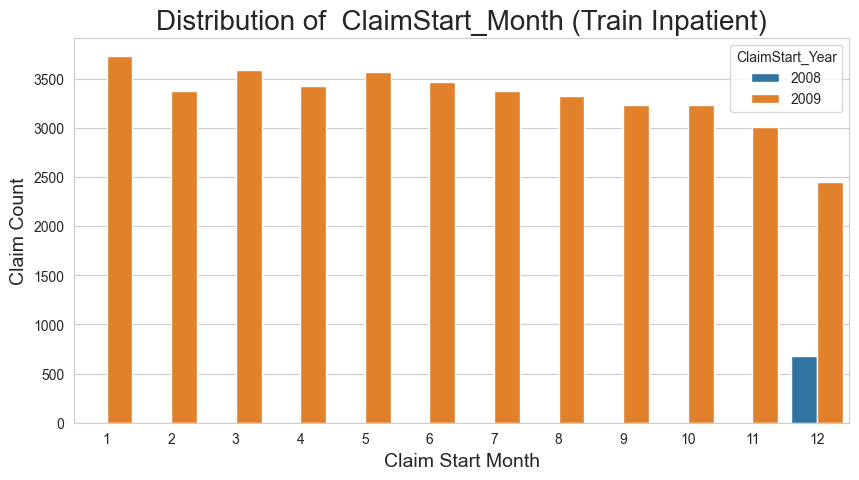

In [59]:
# Plot distribution of ClaimStart_Month in Train Inpatient data
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='ClaimStart_Month',y=None, data=Train_Inpatient, orient ="v", hue= 'ClaimStart_Year') #, order = Train_Inpatient['ClaimStart_Month'].value_counts().index
plt.title('Distribution of  ClaimStart_Month (Train Inpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Claim Start Month', size = 14)
plt.ylabel('Claim Count', size = 14)
plt.show()

### Observation:

1. Claims are almost equally distributed accross all the months for the year 2009.
2. Claims are observed only in December for the year 2008. That means the data collected from Dec2008 to Dec2009.

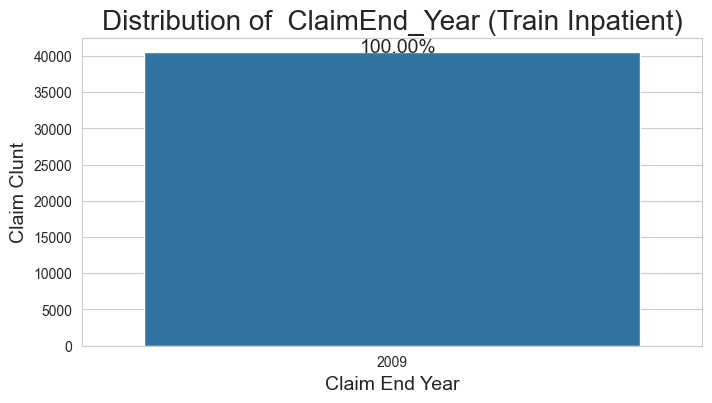

In [60]:
# Plot distribution of ClaimEnd_Year in Train_Inpatient data
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='ClaimEnd_Year',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['ClaimEnd_Year'].value_counts().index)
plt.title('Distribution of  ClaimEnd_Year (Train Inpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Claim End Year', size = 14)
plt.ylabel('Claim Clunt', size = 14)
percentage_without_hue(ax, Train_Inpatient['ClaimEnd_Year'], 0.01, 20,14)

### Observation:

1. All the claims ended in 2009.

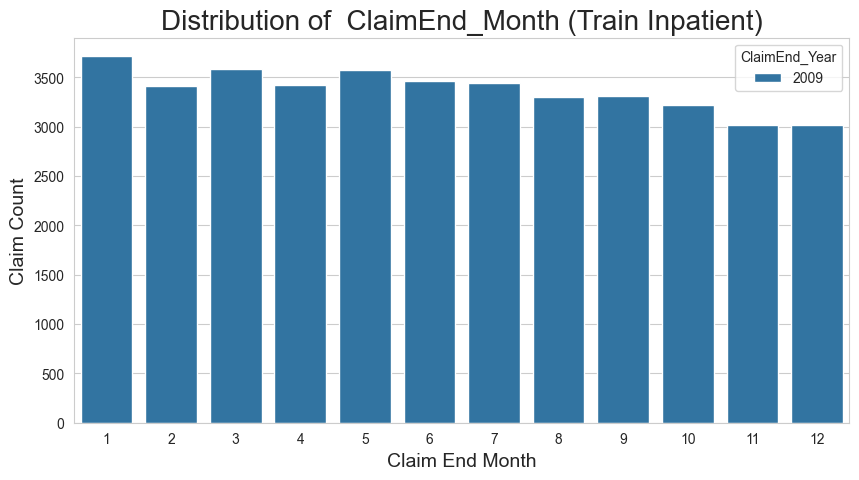

In [61]:
# Plot distribution of ClaimEnd_Month in Train_Inpatient data
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='ClaimEnd_Month',y=None, data=Train_Inpatient, orient ="v", hue= 'ClaimEnd_Year') #, order = Train_Inpatient['ClaimEnd_Month'].value_counts().index
plt.title('Distribution of  ClaimEnd_Month (Train Inpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Claim End Month', size = 14)
plt.ylabel('Claim Count', size = 14)
plt.show()

### Observation:

1. All the claims ended in 2009, distributed accross all the months.

In [62]:
# Get the month and year of Admission_Year and Admission_Month
Train_Inpatient['Admission_Year'] = Train_Inpatient['AdmissionDt'].dt.year
Train_Inpatient['Admission_Month'] = Train_Inpatient['AdmissionDt'].dt.month
Test_Inpatient['Admission_Year'] = Test_Inpatient['AdmissionDt'].dt.year
Test_Inpatient['Admission_Month'] = Test_Inpatient['AdmissionDt'].dt.month

Train_Inpatient['Discharge_Year'] = Train_Inpatient['DischargeDt'].dt.year
Train_Inpatient['Discharge_Month'] = Train_Inpatient['DischargeDt'].dt.month
Test_Inpatient['Discharge_Year'] = Test_Inpatient['DischargeDt'].dt.year
Test_Inpatient['Discharge_Month'] = Test_Inpatient['DischargeDt'].dt.month

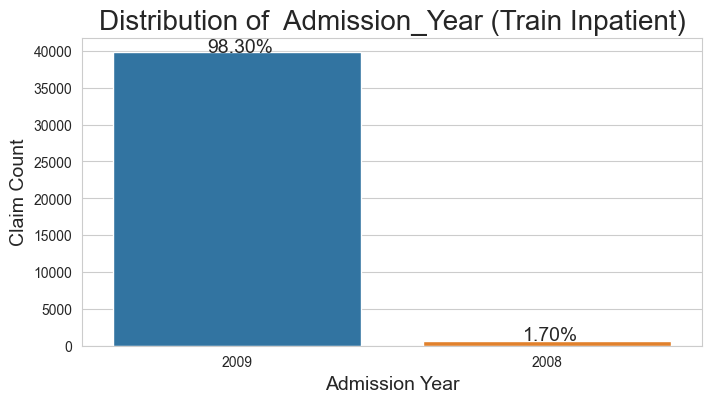

In [63]:
# Plot distribution of Admission_Year in Train_Inpatient data
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Admission_Year',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['Admission_Year'].value_counts().index)
plt.title('Distribution of  Admission_Year (Train Inpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Admission Year', size = 14)
plt.ylabel('Claim Count', size = 14)
percentage_without_hue(ax, Train_Inpatient['Admission_Year'], 0.01, 20,14)

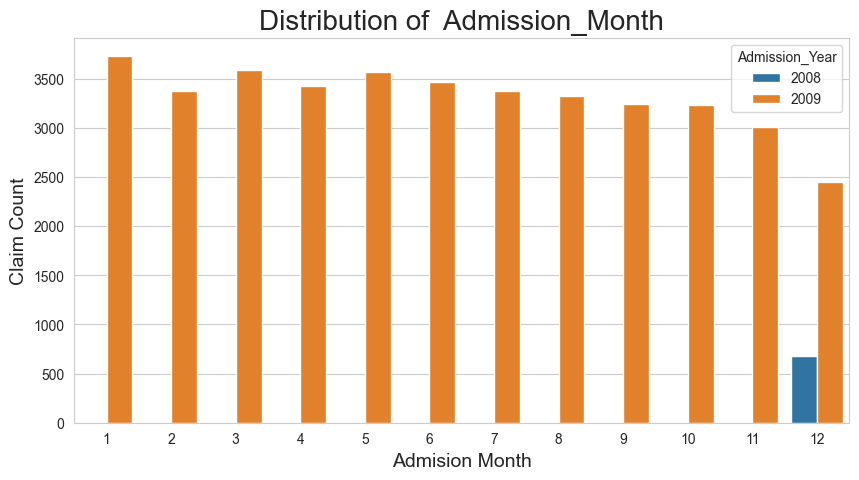

In [64]:
# Plot distribution of Admission_Month in Train_Inpatient data
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Admission_Month',y=None, data=Train_Inpatient, orient ="v", hue='Admission_Year') #, order = Train_Inpatient['Admission_Month'].value_counts().index
plt.title('Distribution of  Admission_Month', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Admision Month', size = 14)
plt.ylabel('Claim Count', size = 14)
plt.show()

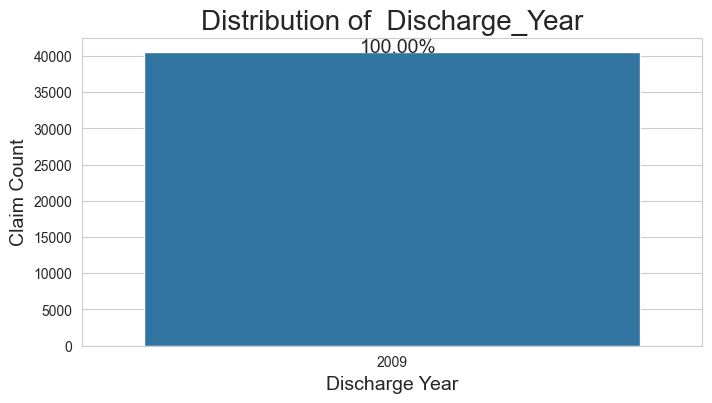

In [65]:
# Plot distribution of race in beneficiaries data
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Discharge_Year',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['Discharge_Year'].value_counts().index)
plt.title('Distribution of  Discharge_Year', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Discharge Year', size = 14)
plt.ylabel('Claim Count', size = 14)
percentage_without_hue(ax, Train_Inpatient['Discharge_Year'], 0.01, 20,14)

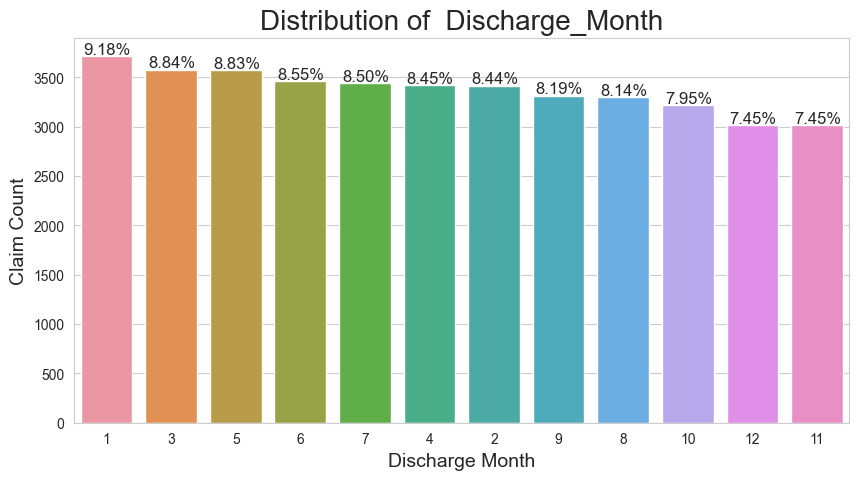

In [66]:
# Plot distribution of race in beneficiaries data
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Discharge_Month',y=None, data=Train_Inpatient, orient ="v", order = Train_Inpatient['Discharge_Month'].value_counts().index)
plt.title('Distribution of  Discharge_Month', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Discharge Month', size = 14)
plt.ylabel('Claim Count', size = 14)
percentage_without_hue(ax, Train_Inpatient['Discharge_Month'], 0.01, 20,12)

### Observation:

1. 98.3% patients got admitted in the year 2009 and only 1.7% in 2008
2. In 2008 patients were admitted only in December in the dataset.
3. All the patients were discharged in 2009 accross all the months.

In [67]:
# Concat all the claim precedurecodes in a single dataframe
ClmProcedureCode_IP_df = pd.DataFrame(columns = ['ProcedureCode'])
ClmProcedureCode_IP_df['ProcedureCode'] = pd.concat([Train_Inpatient["ClmProcedureCode_1"], 
                                   Train_Inpatient["ClmProcedureCode_2"],
                                   Train_Inpatient["ClmProcedureCode_3"],
                                   Train_Inpatient["ClmProcedureCode_4"], 
                                   Train_Inpatient["ClmProcedureCode_5"], 
                                   Train_Inpatient["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

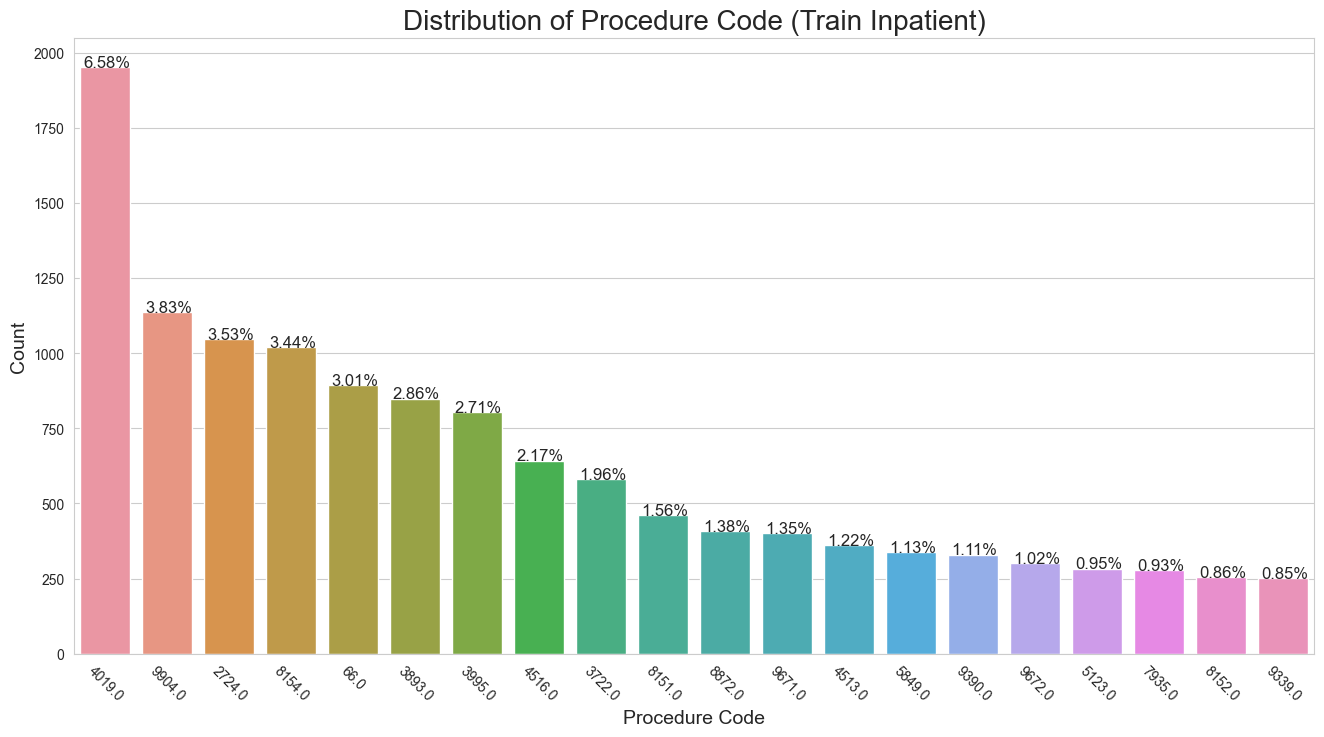

In [68]:
# Plot the countplot for claim precedure codes (Top 20)
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='ProcedureCode',y=None, data=ClmProcedureCode_IP_df, orient ="v", order = ClmProcedureCode_IP_df['ProcedureCode'].value_counts().head(20).index)
plt.title('Distribution of Procedure Code (Train Inpatient)', fontsize=20)
plt.xlabel('Procedure Code', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, ClmProcedureCode_IP_df['ProcedureCode'], 0.02, 0.01, 12)

### Observation:

1. 4019, 9904, 2724, 8154, 66 are the top 5 procedures in terms of number of procedures.
2. 4019 test is done 6.5% of the total procedures.

In [69]:
# Concat all the claim DiagnosisCodes in a single dataframe
ClmDiagnosisCode_IP_df = pd.DataFrame(columns = ['DiagnosisCode'])

ClmDiagnosisCode_IP_df['DiagnosisCode'] = pd.concat([Train_Inpatient["ClmDiagnosisCode_1"], 
                                           Train_Inpatient["ClmDiagnosisCode_2"], 
                                           Train_Inpatient["ClmDiagnosisCode_3"], 
                                           Train_Inpatient["ClmDiagnosisCode_4"],
                                           Train_Inpatient["ClmDiagnosisCode_5"], 
                                           Train_Inpatient["ClmDiagnosisCode_6"],
                                           Train_Inpatient["ClmDiagnosisCode_7"],
                                           Train_Inpatient["ClmDiagnosisCode_8"],
                                           Train_Inpatient["ClmDiagnosisCode_9"],
                                           Train_Inpatient["ClmDiagnosisCode_10"]], axis=0, sort=True).dropna()

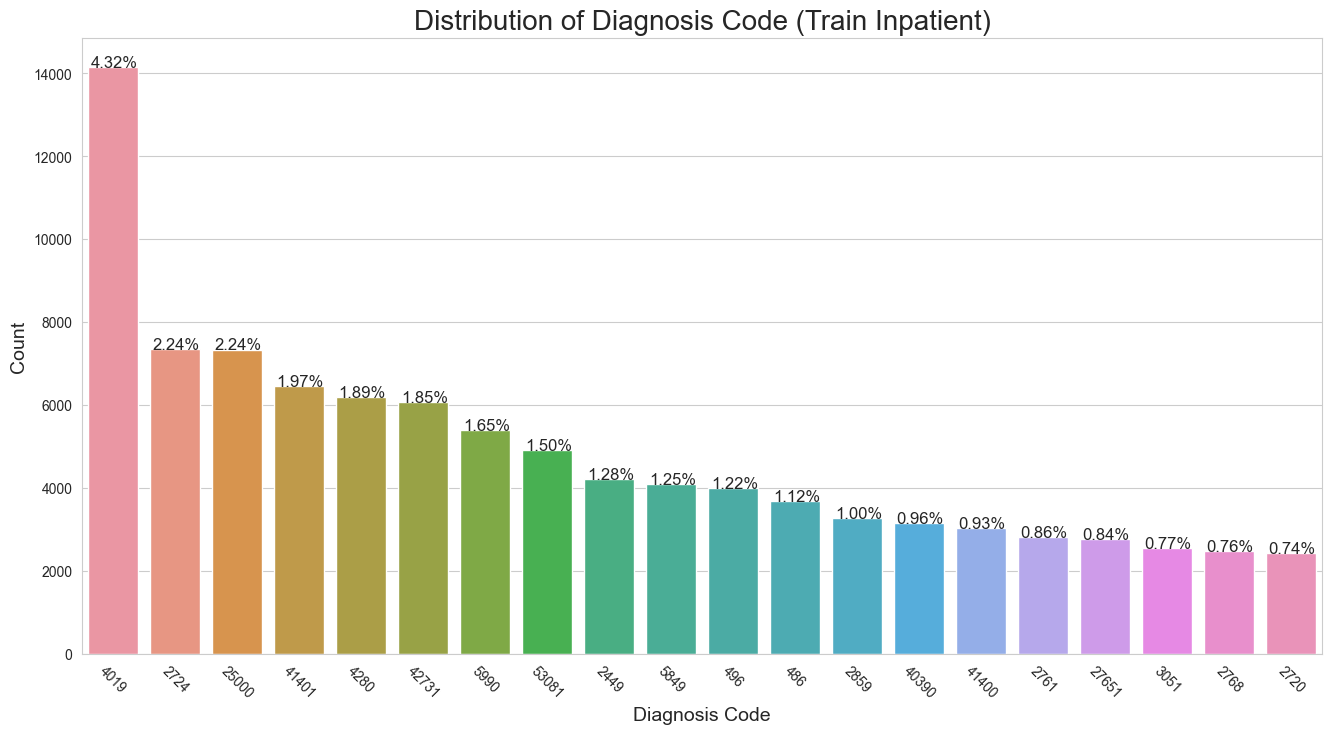

In [70]:
# Plot the countplot for claim diagnosis codes (Top 20)
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='DiagnosisCode',y=None, data=ClmDiagnosisCode_IP_df, orient ="v", order = ClmDiagnosisCode_IP_df['DiagnosisCode'].value_counts().head(20).index)
plt.title('Distribution of Diagnosis Code (Train Inpatient)', fontsize=20)
plt.xlabel('Diagnosis Code', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, ClmDiagnosisCode_IP_df['DiagnosisCode'], 0.02, 0.01, 12)

### Observation:

1. 4019, 2724, 25000, 41401, 4280 are the top 5 diagnosis in terms of number of diagnosos done.
2. 4019 test is done 4.3% of the total diagnosis.

In [71]:
# Calculate total InscClaimAmtReimbursed for inpatient
Train_Inpatient['InscClaimAmtReimbursed'].notna().sum()

40474

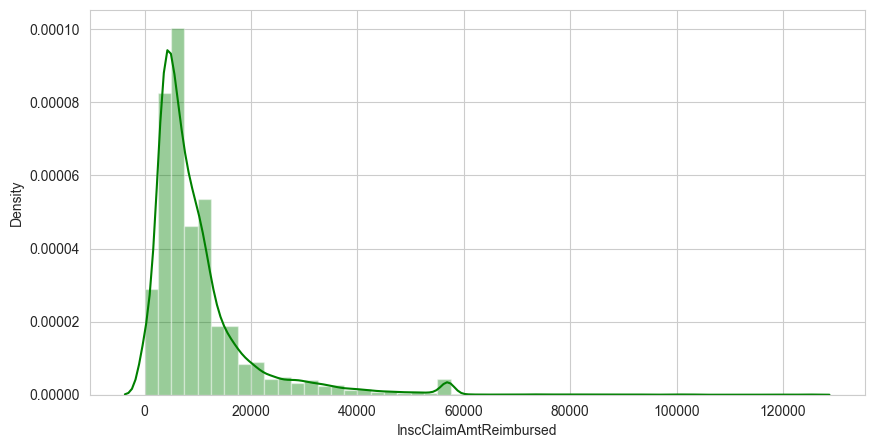

In [72]:
# Plot the distribution for InscClaimAmtReimbursed
sns.set_style('whitegrid') 
plt.figure(figsize=(10, 5))
sns.distplot(Train_Inpatient['InscClaimAmtReimbursed'], kde = True, color ='green', bins = 50)
plt.show()

In [73]:
# Calculate total InscClaimAmtReimbursed for inpatient
Train_Inpatient['DeductibleAmtPaid'].notna().sum()

39575

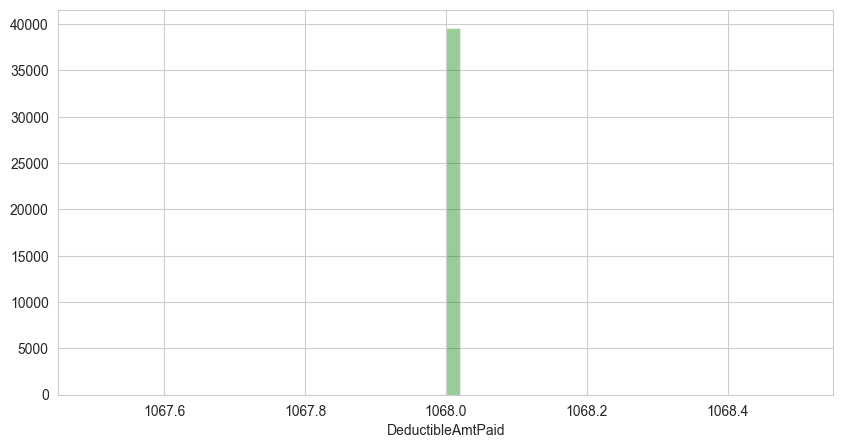

In [74]:
# Plot the distribution for DeductibleAmtPaid
sns.set_style('whitegrid') 
plt.figure(figsize=(10, 5))
sns.distplot(Train_Inpatient['DeductibleAmtPaid'].dropna(), kde = False, color ='green', bins = 50)
plt.show()

### Observation:

1. Total InscClaimAmtReimbursed for inpatient is 40474
2. For very few claims InscClaimAmtReimbursed are very high.
3. DeductibleAmtPaid value is either 0 or 1068

In [75]:
Train_Inpatient.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Hospitalization_Duration', 'Claim_Period',
       'ExtraClaimDays', 'ClaimStart_Year', 'ClaimStart_Month',
       'ClaimEnd_Year', 'ClaimEnd_Month', 'Admission_Year', 'Admission_Month',
       'Discharge_Year', 'Discharge_Month'],
      dtype='object')

## Analyze Train_Outpatient/Test_Outpatient

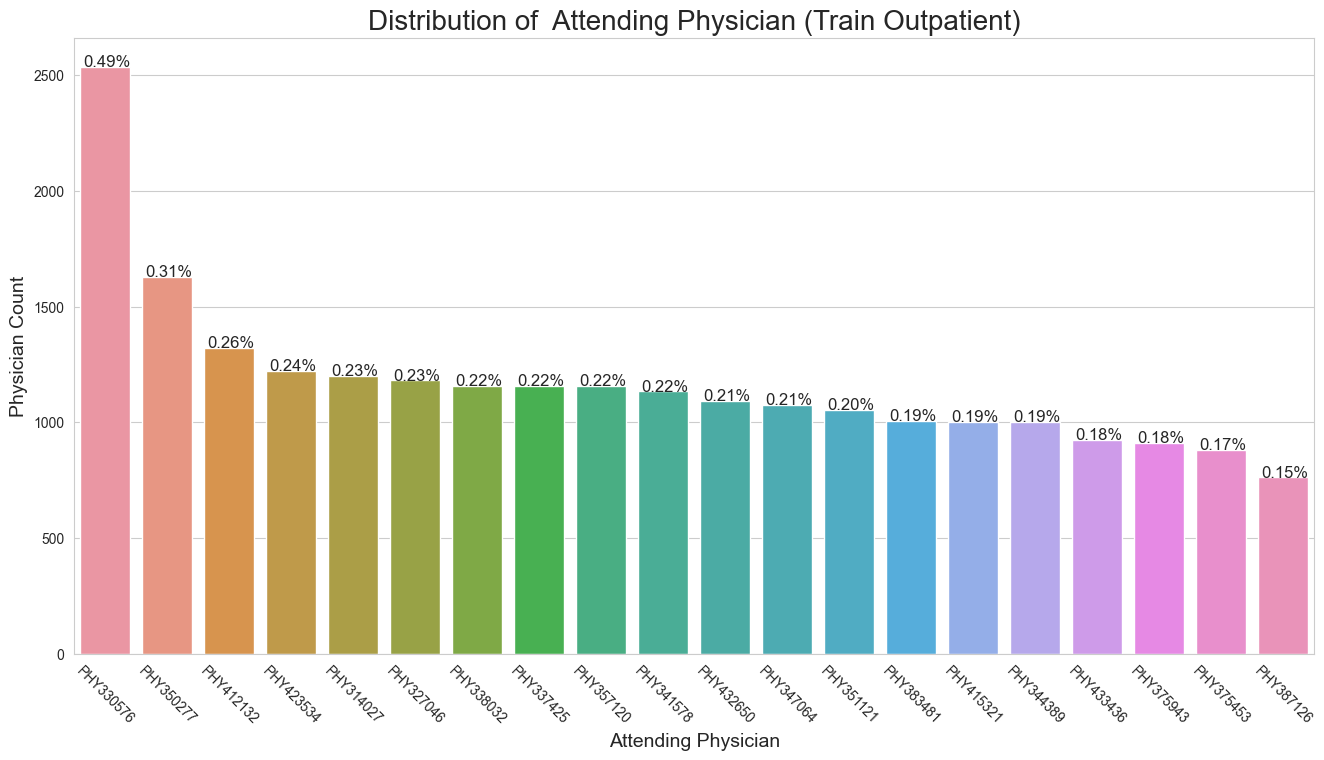

In [76]:
# Top 20 attending physician in terms of patient count
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='AttendingPhysician',y=None, data=Train_Outpatient, orient ="v", order = Train_Outpatient['AttendingPhysician'].value_counts().iloc[:20].index)
plt.title('Distribution of  Attending Physician (Train Outpatient)', fontsize=20)
plt.xlabel('Attending Physician', size = 14)
plt.ylabel('Physician Count', size = 14)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, Train_Outpatient['AttendingPhysician'], 0.02, 2, 12)

### Observation:

1. PHY330576, PHY350277, PHY412132, PHY423534, PHY314027 are the top 5 attending physicians in terms of number of patients visit.
2. PHY330576 treated 0.5% of the total patients.

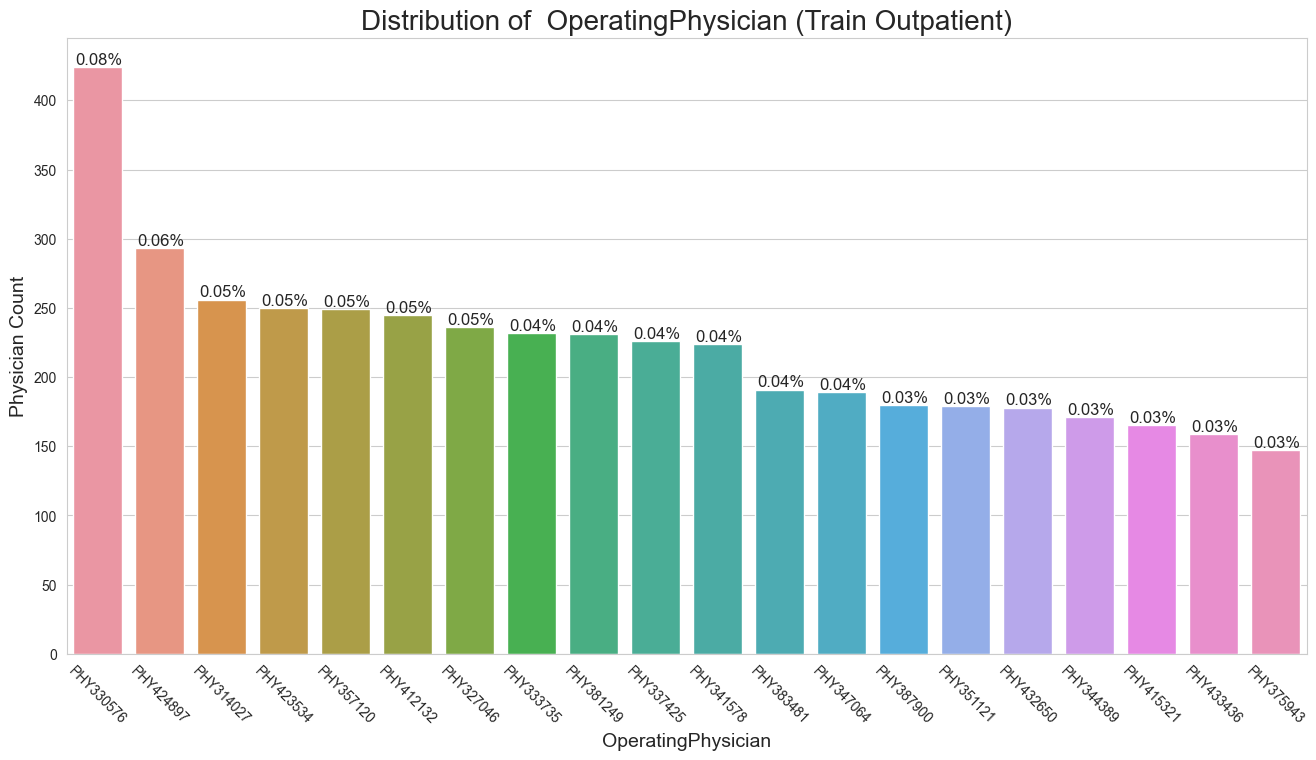

In [77]:
# Plot top 20 Operating Physician in terms of number of patients operated
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='OperatingPhysician',y=None, data=Train_Outpatient, orient ="v", order = Train_Outpatient['OperatingPhysician'].value_counts().iloc[:20].index)
plt.title('Distribution of  OperatingPhysician (Train Outpatient)', fontsize=20)
plt.xlabel('OperatingPhysician', size = 14)
plt.ylabel('Physician Count', size = 14)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, Train_Outpatient['OperatingPhysician'], 0.02, 2, 12)

### Observation:

1. PHY330576, PHY424897, PHY314027, PHY423534, PHY357120 are the top 5 operating physicians in terms of number of patients operation.
2. PHY330576 operated 0.08% of the total patients.

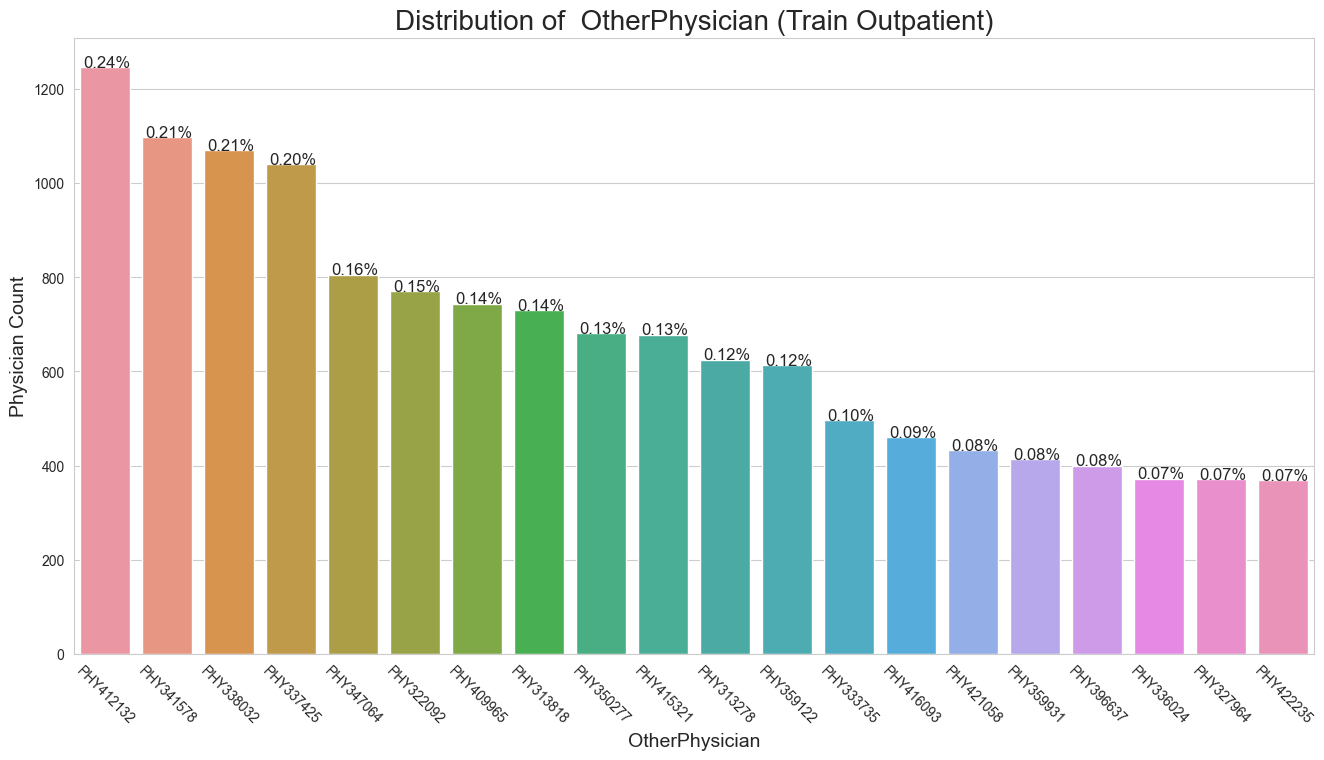

In [78]:
# Plot top 20 Other Physician in terms of number of patients treated
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='OtherPhysician',y=None, data=Train_Outpatient, orient ="v", order = Train_Outpatient['OtherPhysician'].value_counts().iloc[:20].index)
plt.title('Distribution of  OtherPhysician (Train Outpatient)', fontsize=20)
plt.xlabel('OtherPhysician', size = 14)
plt.ylabel('Physician Count', size = 14)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, Train_Outpatient['OtherPhysician'], 0.02, 0, 12)

### Observation:

1. PHY412132, PHY341578, PHY338032, PHY337425, PHY347064 are the top 5 other physicians in terms of number of patients visit.

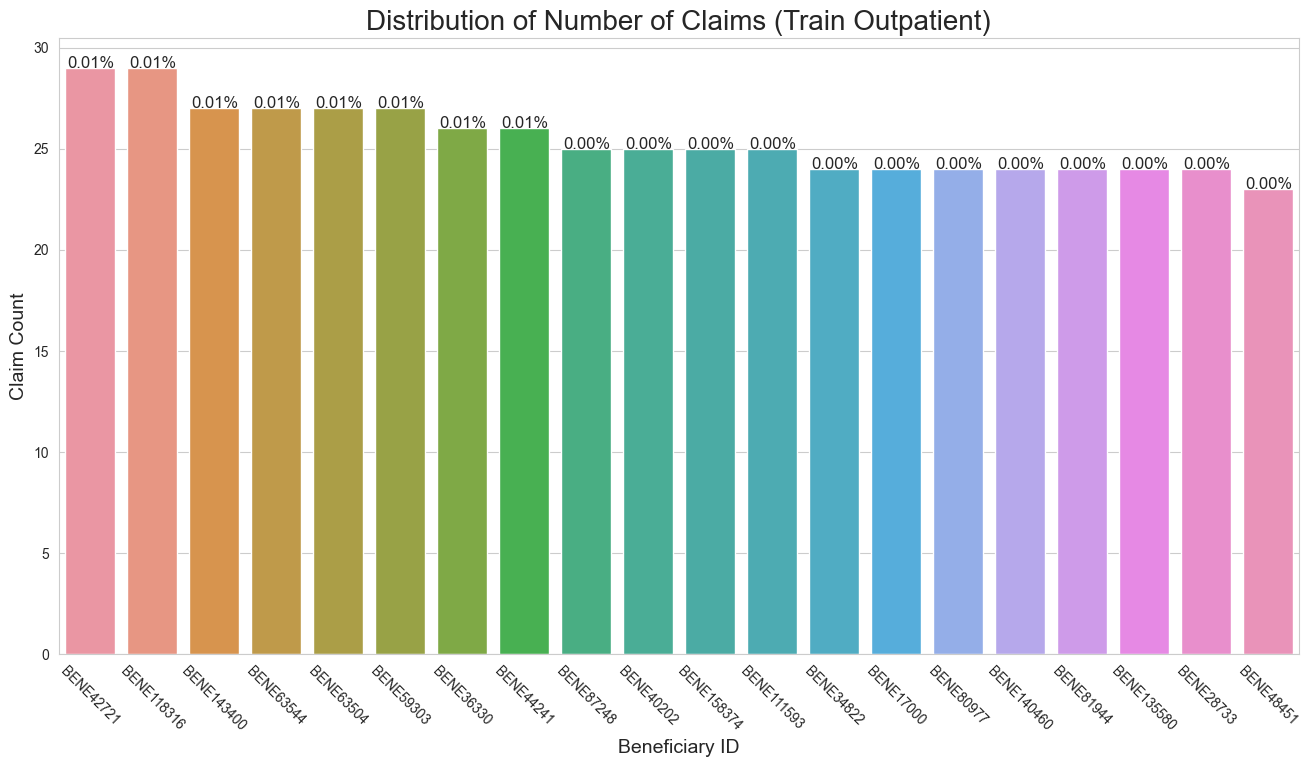

In [79]:
# Distribution of Number of Claims
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='BeneID',y=None, data=Train_Outpatient, orient ="v", order = Train_Outpatient['BeneID'].value_counts().head(20).index)
plt.title('Distribution of Number of Claims (Train Outpatient)', fontsize=20)
plt.xlabel('Beneficiary ID', size = 14)
plt.ylabel('Claim Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, Train_Outpatient['BeneID'], 0.02, 0.01, 12)

### Observation:

1. BENE118316 and BENE42721 claimed maximum number of inpatient claims that is 29.
2. Another 4 beneficiaries claimed 26 claims, shown in the plot.

In [80]:
# convert ClaimStartDt, ClaimEndDt from string to datetime format
Train_Outpatient['ClaimStartDt'] = pd.to_datetime(Train_Outpatient['ClaimStartDt'] , format = '%Y-%m-%d')
Train_Outpatient['ClaimEndDt'] = pd.to_datetime(Train_Outpatient['ClaimEndDt'],format = '%Y-%m-%d')

Test_Outpatient['ClaimStartDt'] = pd.to_datetime(Test_Outpatient['ClaimStartDt'] , format = '%Y-%m-%d')
Test_Outpatient['ClaimEndDt'] = pd.to_datetime(Test_Outpatient['ClaimEndDt'],format = '%Y-%m-%d')

In [81]:
# Get the months and year of claim start and claim end
Train_Outpatient['ClaimStart_Year'] = Train_Outpatient['ClaimStartDt'].dt.year
Train_Outpatient['ClaimStart_Month'] = Train_Outpatient['ClaimStartDt'].dt.month
Test_Outpatient['ClaimStart_Year'] = Test_Outpatient['ClaimStartDt'].dt.year
Test_Outpatient['ClaimStart_Month'] = Test_Outpatient['ClaimStartDt'].dt.month

Train_Outpatient['ClaimEnd_Year'] = Train_Outpatient['ClaimEndDt'].dt.year
Train_Outpatient['ClaimEnd_Month'] = Train_Outpatient['ClaimEndDt'].dt.month
Test_Outpatient['ClaimEnd_Year'] = Test_Outpatient['ClaimEndDt'].dt.year
Test_Outpatient['ClaimEnd_Month'] = Test_Outpatient['ClaimEndDt'].dt.month

In [82]:
# Calculate Claim_Period = ClaimEndDt - ClaimStartDt
Train_Outpatient['Claim_Period'] = ((Train_Outpatient['ClaimEndDt'] - Train_Outpatient['ClaimStartDt']).dt.days)+1

Test_Outpatient['Claim_Period'] = ((Test_Outpatient['ClaimEndDt'] - Test_Outpatient['ClaimStartDt']).dt.days)+1

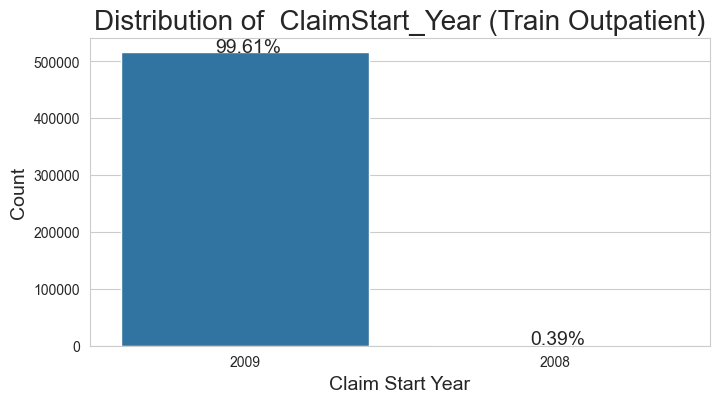

In [83]:
# Plot distribution of claim start year in Train Outpatient data
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='ClaimStart_Year',y=None, data=Train_Outpatient, orient ="v", order = Train_Outpatient['ClaimStart_Year'].value_counts().index)
plt.title('Distribution of  ClaimStart_Year (Train Outpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Claim Start Year', size = 14)
plt.ylabel('Count', size = 14)
percentage_without_hue(ax, Train_Outpatient['ClaimStart_Year'], 0.01, 20,14)

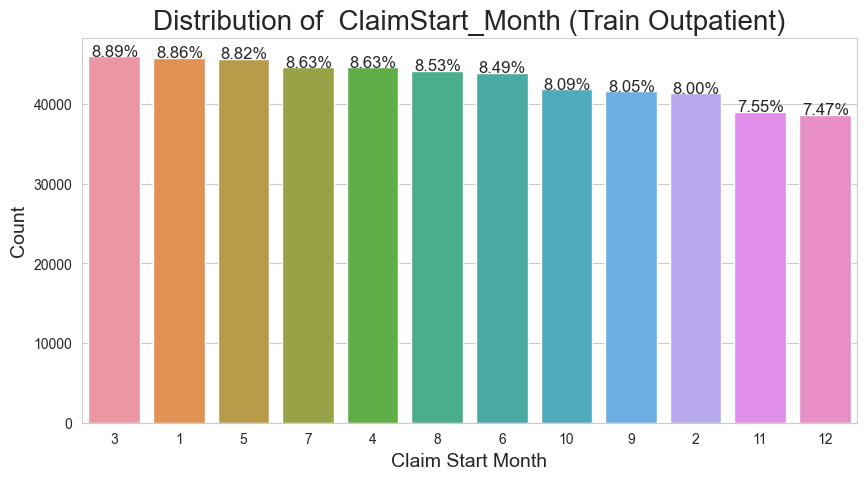

In [84]:
# Plot distribution of ClaimStart_Month in Train Inpatient data
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='ClaimStart_Month',y=None, data=Train_Outpatient, orient ="v", order = Train_Outpatient['ClaimStart_Month'].value_counts().index)
plt.title('Distribution of  ClaimStart_Month (Train Outpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Claim Start Month', size = 14)
plt.ylabel('Count', size = 14)
percentage_without_hue(ax, Train_Outpatient['ClaimStart_Month'], 0.01, 20,12)

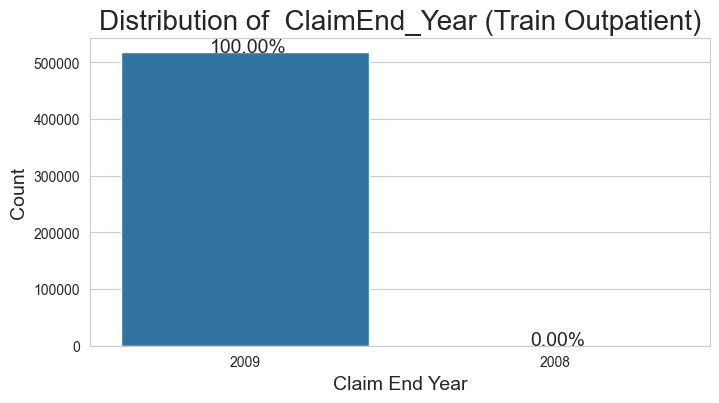

In [85]:
# Plot distribution of ClaimEnd_Year in Train_Outpatient data
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='ClaimEnd_Year',y=None, data=Train_Outpatient, orient ="v", order = Train_Outpatient['ClaimEnd_Year'].value_counts().index)
plt.title('Distribution of  ClaimEnd_Year (Train Outpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Claim End Year', size = 14)
plt.ylabel('Count', size = 14)
percentage_without_hue(ax, Train_Outpatient['ClaimEnd_Year'], 0.01, 20,14)

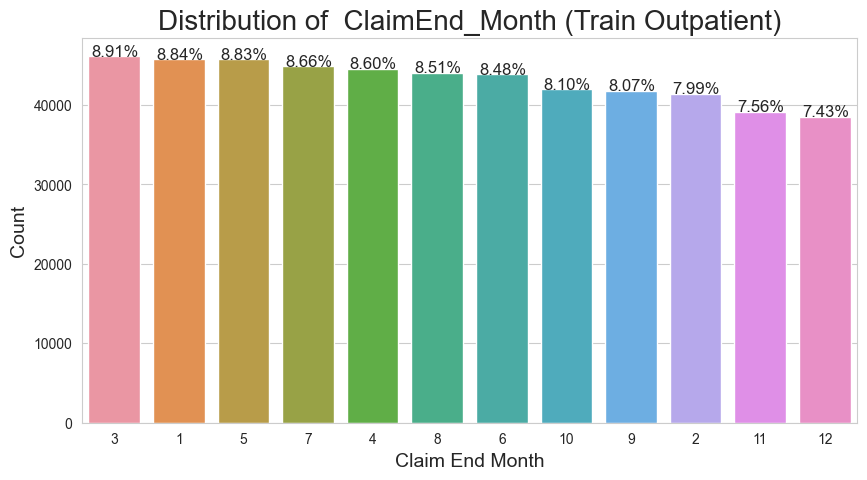

In [86]:
# Plot distribution of ClaimEnd_Month in Train_Outpatient data
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='ClaimEnd_Month',y=None, data=Train_Outpatient, orient ="v", order = Train_Outpatient['ClaimEnd_Month'].value_counts().index)
plt.title('Distribution of  ClaimEnd_Month (Train Outpatient)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Claim End Month', size = 14)
plt.ylabel('Count', size = 14)
percentage_without_hue(ax, Train_Outpatient['ClaimEnd_Month'], 0.01, 20,12)

### Observation:

1. 99.6% claims started in 2009 only 0.4% claim started in 2008
2. Distribution of claim start year is uniform.
3. All the claims ended in 2009, distributed accross all the months.

In [87]:
# Concat all the claim precedurecodes in a single dataframe
ClmProcedureCode_OP_df = pd.DataFrame(columns = ['ProcedureCode'])
ClmProcedureCode_OP_df['ProcedureCode'] = pd.concat([Train_Outpatient["ClmProcedureCode_1"], 
                                   Train_Outpatient["ClmProcedureCode_2"],
                                   Train_Outpatient["ClmProcedureCode_3"],
                                   Train_Outpatient["ClmProcedureCode_4"], 
                                   Train_Outpatient["ClmProcedureCode_5"], 
                                   Train_Outpatient["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

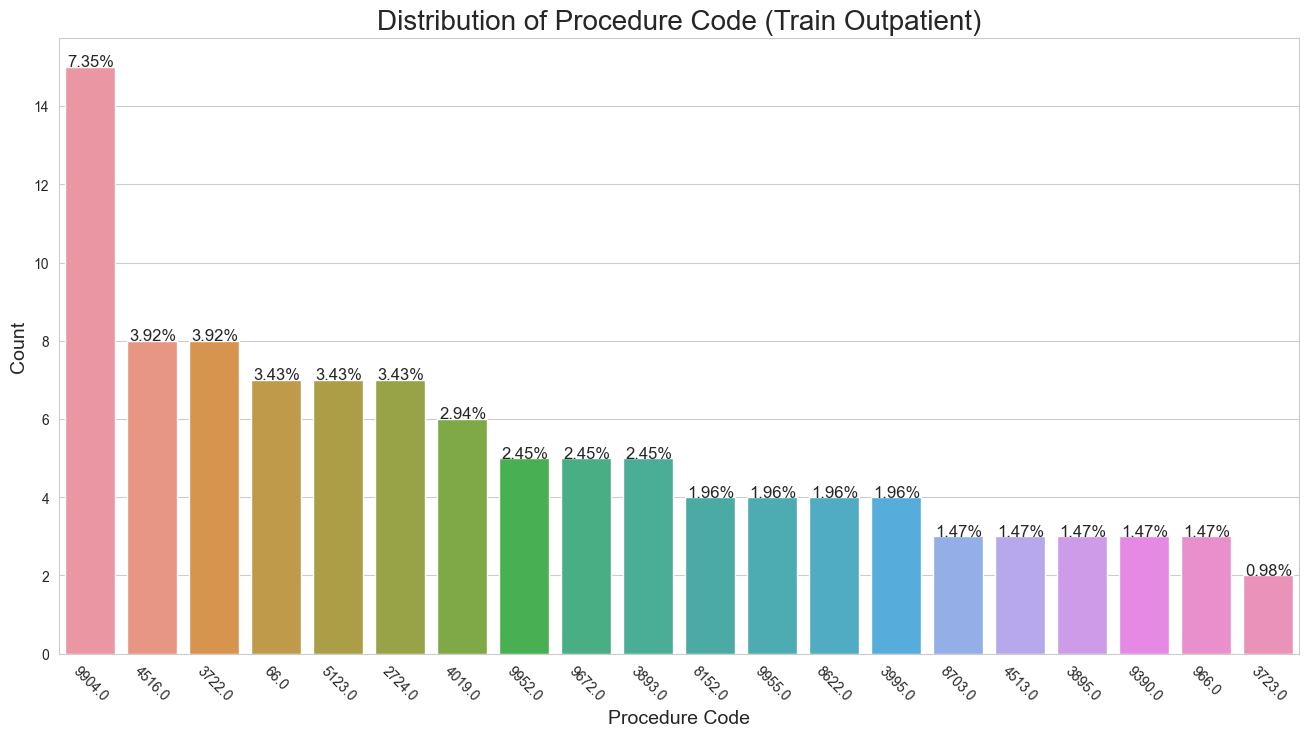

In [88]:
# Plot the countplot for claim precedure codes (Top 20)
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='ProcedureCode',y=None, data=ClmProcedureCode_OP_df, orient ="v", order = ClmProcedureCode_OP_df['ProcedureCode'].value_counts().head(20).index)
plt.title('Distribution of Procedure Code (Train Outpatient)', fontsize=20)
plt.xlabel('Procedure Code', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, ClmProcedureCode_OP_df['ProcedureCode'], 0.02, 0.01, 12)

### Observation:
1. Top 20 ProcedureCodes are shown in the plot.
2. Procedure 9904 was done 7.35%  of total procedures done.

In [89]:
# Concat all the claim DiagnosisCodes in a single dataframe
ClmDiagnosisCode_OP_df = pd.DataFrame(columns = ['DiagnosisCode'])

ClmDiagnosisCode_OP_df['DiagnosisCode'] = pd.concat([Train_Outpatient["ClmDiagnosisCode_1"], 
                                           Train_Outpatient["ClmDiagnosisCode_2"], 
                                           Train_Outpatient["ClmDiagnosisCode_3"], 
                                           Train_Outpatient["ClmDiagnosisCode_4"],
                                           Train_Outpatient["ClmDiagnosisCode_5"], 
                                           Train_Outpatient["ClmDiagnosisCode_6"],
                                           Train_Outpatient["ClmDiagnosisCode_7"],
                                           Train_Outpatient["ClmDiagnosisCode_8"],
                                           Train_Outpatient["ClmDiagnosisCode_9"],
                                           Train_Outpatient["ClmDiagnosisCode_10"]], axis=0, sort=True).dropna()

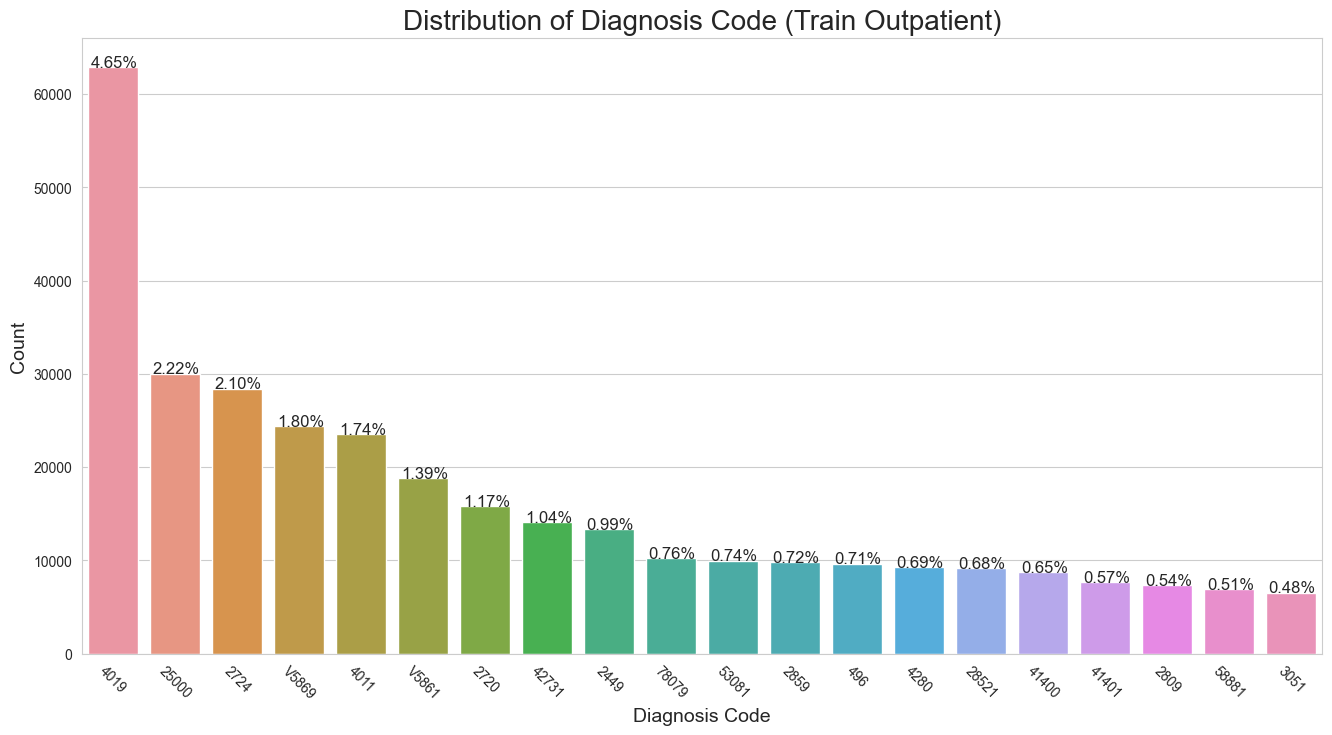

In [90]:
# Plot the countplot for claim diagnosis codes (Top 20)
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='DiagnosisCode',y=None, data=ClmDiagnosisCode_OP_df, orient ="v", order = ClmDiagnosisCode_OP_df['DiagnosisCode'].value_counts().head(20).index)
plt.title('Distribution of Diagnosis Code (Train Outpatient)', fontsize=20)
plt.xlabel('Diagnosis Code', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, ClmDiagnosisCode_OP_df['DiagnosisCode'], 0.02, 0.01, 12)

### Observation:
1. Top 20 DiagnosisCodes are shown in the plot.
2. Procedure 4019 was done 4.65%  of total procedures done.

In [91]:
Train_Outpatient.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode', 'ClaimStart_Year', 'ClaimStart_Month',
       'ClaimEnd_Year', 'ClaimEnd_Month', 'Claim_Period'],
      dtype='object')

In [92]:
# Create a new column Inpatient_or_Outpatient where Inpatient =1 and Outpatient = 0
Train_Inpatient['Inpatient_or_Outpatient'] = 1
Train_Outpatient['Inpatient_or_Outpatient'] = 0
Test_Inpatient['Inpatient_or_Outpatient'] = 1
Test_Outpatient['Inpatient_or_Outpatient'] = 0

## Merge Inpatient and Outpatient Data

In [93]:
# Merge inpatient and outpatient dataframes based on common columns
common_columns = [ idx for idx in Train_Outpatient.columns if idx in Train_Inpatient.columns]
print(common_columns)
Inpatient_Outpatient_Merge = pd.merge(Train_Inpatient, Train_Outpatient, left_on = common_columns, right_on = common_columns,how = 'outer')

['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode', 'ClaimStart_Year', 'ClaimStart_Month', 'ClaimEnd_Year', 'ClaimEnd_Month', 'Claim_Period', 'Inpatient_or_Outpatient']


In [94]:
# Merge beneficiary details with inpatient and outpatient data
Inpatient_Outpatient_Beneficiary_Merge = pd.merge(Inpatient_Outpatient_Merge, Train_Beneficiary,
                                                  left_on='BeneID',right_on='BeneID',how='inner')

# Merge provider details
Final_Dataset_Train = pd.merge(Inpatient_Outpatient_Beneficiary_Merge, Train , how = 'inner', on = 'Provider' )

In [95]:
# Merge inpatient and outpatient dataframes based on common columns

common_columns_test = [ idx for idx in Test_Outpatient.columns if idx in Test_Inpatient.columns]
Inpatient_Outpatient_Merge_Te = pd.merge(Test_Inpatient, Test_Outpatient, left_on = common_columns_test, right_on = common_columns_test,how = 'outer')

# Merge beneficiary details with inpatient and outpatient data
Inpatient_Outpatient_Beneficiary_Merge_Te = pd.merge(Inpatient_Outpatient_Merge_Te, Test_Beneficiary,
                                                  left_on='BeneID',right_on='BeneID',how='inner')

Final_Dataset_Test = pd.merge(Inpatient_Outpatient_Beneficiary_Merge_Te, Test , how = 'inner', on = 'Provider' )

In [96]:
Final_Dataset_Train.shape

(558211, 72)

In [97]:
Final_Dataset_Train.head(2)

BeneID    ClaimID ClaimStartDt ClaimEndDt  Provider  \
0  BENE11001   CLM46614   2009-04-12 2009-04-18  PRV55912   
1  BENE16973  CLM565430   2009-09-06 2009-09-06  PRV55912   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                      50          PHY365867          PHY327147   

  OtherPhysician AdmissionDt ClmAdmitDiagnosisCode  DeductibleAmtPaid  \
0            NaN  2009-04-12                  7866             1068.0   
1            NaN         NaT                   NaN                0.0   

  DischargeDt DiagnosisGroupCode ClmDiagnosisCode_1 ClmDiagnosisCode_2  \
0  2009-04-18                201               1970               4019   
1         NaT                NaN              V7183              53081   

  ClmDiagnosisCode_3 ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6  \
0               5853               7843               2768              71590   
1              78959               4280              E8788              78079   

  ClmDiagnosisCode_7 ClmDiagnosisCode_8 ClmDiagnosisCode_9  \
0               2724              19889               5849   
1              79902              25002              71848   

  ClmDiagnosisCode_10  ClmProcedureCode_1  ClmProcedureCode_2  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   

   ClmProcedureCode_3  ClmProcedureCode_4  ClmProcedureCode_5  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   

   ClmProcedureCode_6  Hospitalization_Duration  Claim_Period  ExtraClaimDays  \
0                 NaN                       7.0             7             0.0   
1                 NaN                       NaN             1             NaN   

   ClaimStart_Year  ClaimStart_Month  ClaimEnd_Year  ClaimEnd_Month  \
0             2009                 4           2009               4   
1             2009                 9           2009               9   

   Admission_Year  Admission_Month  Discharge_Year  Discharge_Month  \
0          2009.0              4.0          2009.0              4.0   
1             NaN              NaN             NaN              NaN   

   Inpatient_or_Outpatient        DOB DOD  Gender  Race  \
0                        1 1943-01-01 NaT       1     1   
1                        0 1932-05-01 NaT       1     1   

   RenalDiseaseIndicator  State  County  NoOfMonths_PartACov  \
0                      0     39     230                   12   
1                      0     39     310                   12   

   NoOfMonths_PartBCov  ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
0                   12                      1                         0   
1                   12                      1                         1   

   ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  \
0                          1                   0                           0   
1                          1                   0                           0   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       0                     0                          1   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         0                                1   
1                         0                                0   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   0                     24000                   2136   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  Patient_Risk_Score  \
0                        60                     70                   7   
1                       450                  

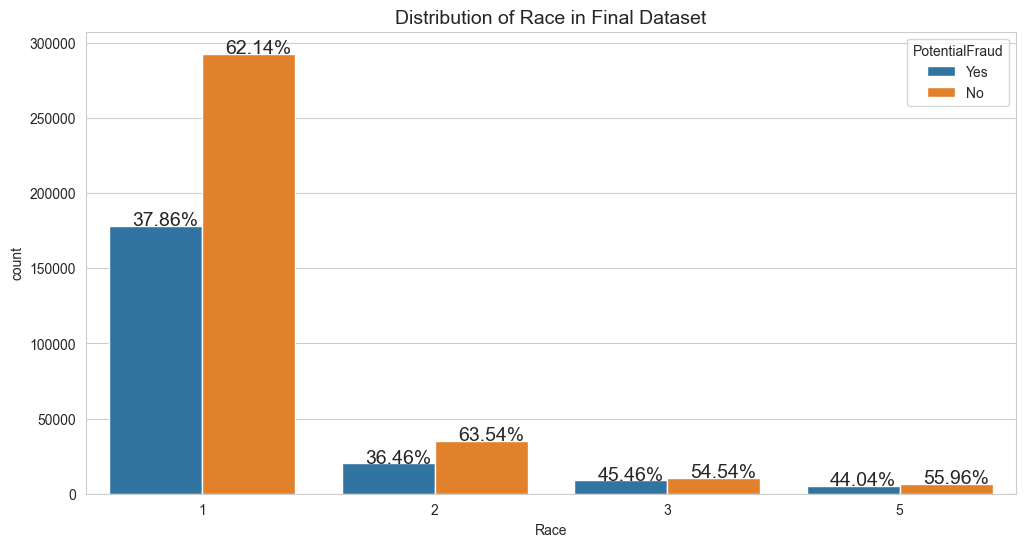

In [98]:
# Distribution of race in Overall data
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Race',y=None, data=Final_Dataset_Train, hue="PotentialFraud", orient ="v",hue_order=['Yes','No'], order = Final_Dataset_Train['Race'].value_counts().index)
plt.title('Distribution of Race in Final Dataset', size = 14)
percentage_with_hue(ax, Final_Dataset_Train.Race, 4,2,-0.1,200, 14)

### Observation:
1. Total number of transactions are more for Race 1, 37.8% are fraudulent out of them.
2. The ratio of fraudulent transaction is most for Race 3 (45.5%)
3. So, race is an important feature in healthcare fraud detection.

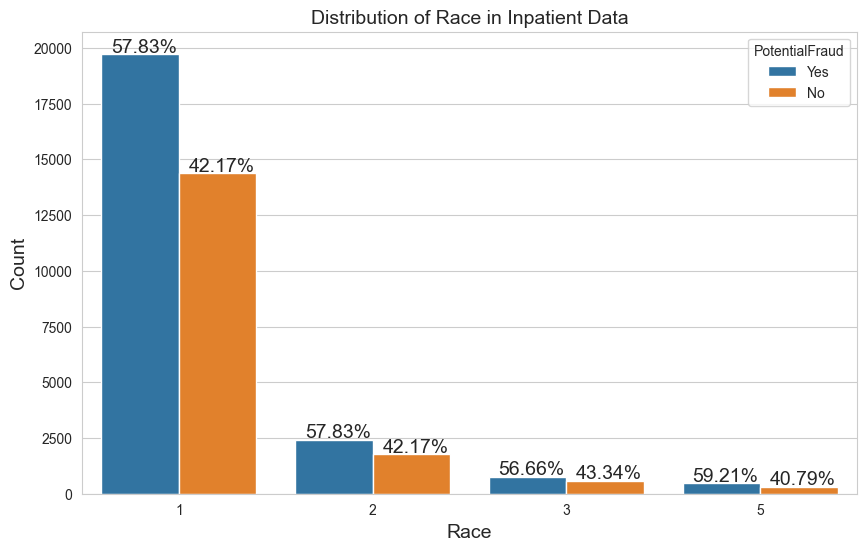

In [99]:
# Distribution of race in Inpatient Data
plt.figure(figsize=(10, 6))
Data = Final_Dataset_Train[Final_Dataset_Train.Inpatient_or_Outpatient == 1]
order = Final_Dataset_Train.Race.value_counts().index
ax = sns.countplot(x='Race',y=None, data=Data, hue= "PotentialFraud", orient ="v", order = order) #hue_order=['No','Yes'],
plt.title('Distribution of Race in Inpatient Data', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Race', size = 14)
plt.ylabel('Count', size = 14)
percentage_with_hue(ax, Data.Race, 4,2,-0.15,80, 14)

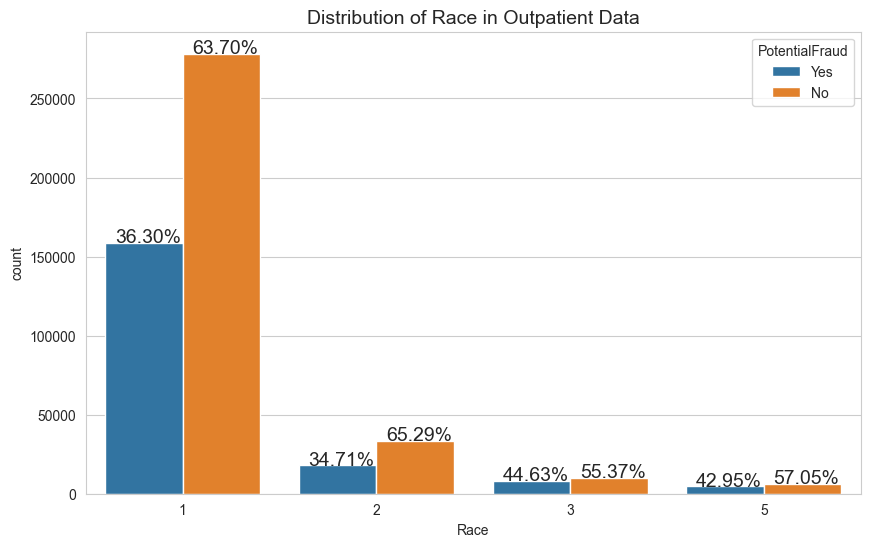

In [100]:
# Distribution of race in Inpatient Data
plt.figure(figsize=(10, 6))
Data = Final_Dataset_Train[Final_Dataset_Train.Inpatient_or_Outpatient == 0]
order = Final_Dataset_Train.Race.value_counts().index
ax = sns.countplot(x='Race',y=None, data=Data, hue= "PotentialFraud", orient ="v", order = order) #hue_order=['No','Yes'],
plt.title('Distribution of Race in Outpatient Data', size = 14)
percentage_with_hue(ax, Data.Race, 4,2,-0.15,200, 14)

### Observation:
1. When inpatient and outpatient data is analyzed separetely it is observed that the percentage of fraudulent activity is more in Inpatient Data compared to Outpatient Data. This may be because of more money associated in inpatient claims.
2. In Inpatient data, Race 5 has highest percentage of fraudulent activity(59.21%)
3. In outpatient data Race 3 has highest percentage of fraudulent activity(44.63%)

In [101]:
Total_number_of_inpatient_claims = Final_Dataset_Train.InscClaimAmtReimbursed[(Final_Dataset_Train.Inpatient_or_Outpatient == 1)].count()
Total_number_of_inpatient_claims                                                                              

40474

In [102]:
#Calculatinng total and percentage money lost for Inpatient
Total_number_of_inpatient_claims = Final_Dataset_Train.InscClaimAmtReimbursed[(Final_Dataset_Train.Inpatient_or_Outpatient == 1)].count()
Total_Money_Fraud_Inpatient = Final_Dataset_Train.InscClaimAmtReimbursed[(Final_Dataset_Train.Inpatient_or_Outpatient == 1) & (Final_Dataset_Train.PotentialFraud == 'Yes')].sum()
Total_Money_Spent_Inpatient = Final_Dataset_Train.InscClaimAmtReimbursed[(Final_Dataset_Train.Inpatient_or_Outpatient == 1)].sum()
print("Total_Money_Spent_Inpatient : ",Total_Money_Spent_Inpatient)
print('Average reimbursed amount per patient :' , round(Total_Money_Spent_Inpatient/Total_number_of_inpatient_claims))
print("Total_Money_Fraud_Inpatient : ",Total_Money_Fraud_Inpatient)
print("Percentage of money spent in fraud for Inpatient = {:.2f}%".format(Total_Money_Fraud_Inpatient/Total_Money_Spent_Inpatient *100))

Total_Money_Spent_Inpatient :  408297020
Average reimbursed amount per patient : 10088
Total_Money_Fraud_Inpatient :  241288510
Percentage of money spent in fraud for Inpatient = 59.10%


In [103]:
#Calculatinng total and percentage money lost for Outpatient
Total_number_of_Outpatient_claims = Final_Dataset_Train.InscClaimAmtReimbursed[(Final_Dataset_Train.Inpatient_or_Outpatient == 0)].count()
Total_Money_Fraud_Outpatient = Final_Dataset_Train.InscClaimAmtReimbursed[(Final_Dataset_Train.Inpatient_or_Outpatient == 0) & (Final_Dataset_Train.PotentialFraud == 'Yes')].sum()
Total_Money_Spent_Outpatient = Final_Dataset_Train.InscClaimAmtReimbursed[(Final_Dataset_Train.Inpatient_or_Outpatient == 0)].sum()
print("Total_Money_Spent_Outpatient : ",Total_Money_Spent_Outpatient)
print('Average reimbursed amount per patient :' , round(Total_Money_Spent_Outpatient/Total_number_of_Outpatient_claims))
print("Total_Money_Fraud_Outpatient : ",Total_Money_Fraud_Outpatient)
print("Percentage of money spent in fraud for Outpatient = {:.2f}%".format(Total_Money_Fraud_Outpatient/Total_Money_Spent_Outpatient *100))

Total_Money_Spent_Outpatient :  148246120
Average reimbursed amount per patient : 286
Total_Money_Fraud_Outpatient :  54392610
Percentage of money spent in fraud for Outpatient = 36.69%


In [104]:
#Calculatinng total and percentage money lost for overall data
Total_Money_Fraud = Final_Dataset_Train.InscClaimAmtReimbursed[(Final_Dataset_Train.PotentialFraud == 'Yes')].sum()
Total_Money_Spent = Final_Dataset_Train.InscClaimAmtReimbursed.sum()
print("Total_Money_Spent : ",Total_Money_Spent)
print("Total_Money_Fraud : ",Total_Money_Fraud)
print("Percentage of money spent in fraud = {:.2f}%".format(Total_Money_Fraud/Total_Money_Spent *100))

Total_Money_Spent :  556543140
Total_Money_Fraud :  295681120
Percentage of money spent in fraud = 53.13%


### Observation:
1. Percentage of fraudulent activity is more in inpatient data this is because the average reimbursement amount for inpatient data(10088) is 35 times more than the average reimbursement amount(286) for outpatient.
2. Amount 295681120 is wasted for fraudulent transaction which is 53% of the total reimbursement amount(556543140)

In [105]:
# Concat all the claim precedurecodes in a single dataframe
ClmProcedureCode_df = pd.DataFrame(columns = ['ProcedureCode'])
ClmProcedureCode_df['ProcedureCode'] = pd.concat([Final_Dataset_Train["ClmProcedureCode_1"], 
                                   Final_Dataset_Train["ClmProcedureCode_2"],
                                   Final_Dataset_Train["ClmProcedureCode_3"],
                                   Final_Dataset_Train["ClmProcedureCode_4"], 
                                   Final_Dataset_Train["ClmProcedureCode_5"], 
                                   Final_Dataset_Train["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

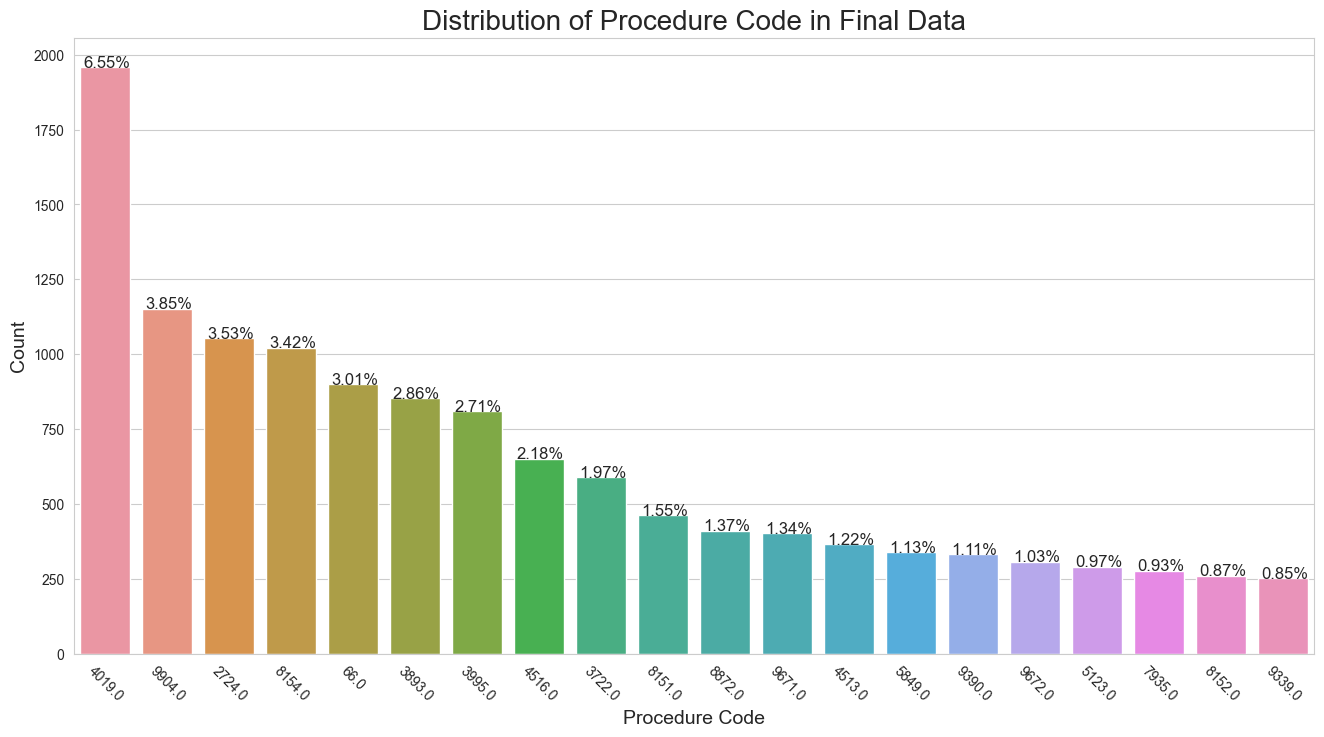

In [106]:
# Plot the countplot for claim precedure codes (Top 20)
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='ProcedureCode',y=None, data=ClmProcedureCode_df, orient ="v", order = ClmProcedureCode_df['ProcedureCode'].value_counts().head(20).index)
plt.title('Distribution of Procedure Code in Final Data', fontsize=20)
plt.xlabel('Procedure Code', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, ClmProcedureCode_df['ProcedureCode'], 0.02, 0.01, 12)

### Observation:

1. Top 20 procedure codes are shown in the plot.
2. 4019 test is done 6.5% of the total procedures.

In [107]:
# Concat all the claim DiagnosisCodes in a single dataframe
ClmDiagnosisCode_df = pd.DataFrame(columns = ['DiagnosisCode'])

ClmDiagnosisCode_df['DiagnosisCode'] = pd.concat([Final_Dataset_Train["ClmDiagnosisCode_1"], 
                                           Final_Dataset_Train["ClmDiagnosisCode_2"], 
                                           Final_Dataset_Train["ClmDiagnosisCode_3"], 
                                           Final_Dataset_Train["ClmDiagnosisCode_4"],
                                           Final_Dataset_Train["ClmDiagnosisCode_5"], 
                                           Final_Dataset_Train["ClmDiagnosisCode_6"],
                                           Final_Dataset_Train["ClmDiagnosisCode_7"],
                                           Final_Dataset_Train["ClmDiagnosisCode_8"],
                                           Final_Dataset_Train["ClmDiagnosisCode_9"],
                                           Final_Dataset_Train["ClmDiagnosisCode_10"]], axis=0, sort=True).dropna()

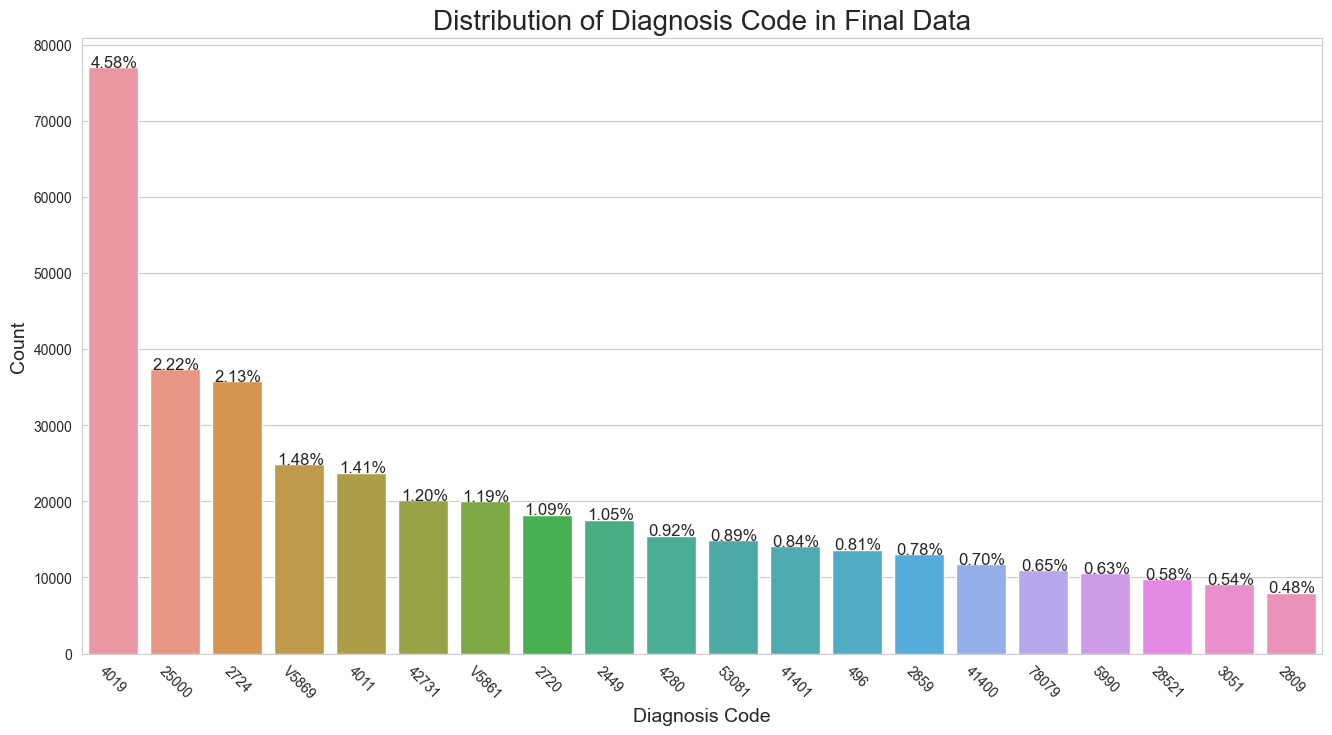

In [108]:
# Plot the countplot for claim diagnosis codes (Top 20)
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='DiagnosisCode',y=None, data=ClmDiagnosisCode_df, orient ="v", order = ClmDiagnosisCode_df['DiagnosisCode'].value_counts().head(20).index)
plt.title('Distribution of Diagnosis Code in Final Data', fontsize=20)
plt.xlabel('Diagnosis Code', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, ClmDiagnosisCode_df['DiagnosisCode'], 0.02, 0.01, 12)

### Observation:

1. Top 20 diagnosis codes are shown in the plot.
2. 4019 diagnosis is done 4.5% of the total diagnosis.

In [109]:
# Separate dataframe with fraud only
Final_Dataset_Fraud_Train = Final_Dataset_Train[Final_Dataset_Train.PotentialFraud == 'Yes']
ClmProcedureCodeFraud_df = pd.DataFrame(columns = ['ProcedureCode'])
ClmProcedureCodeFraud_df['ProcedureCode'] = pd.concat([Final_Dataset_Fraud_Train["ClmProcedureCode_1"], 
                                   Final_Dataset_Fraud_Train["ClmProcedureCode_2"],
                                   Final_Dataset_Fraud_Train["ClmProcedureCode_3"],
                                   Final_Dataset_Fraud_Train["ClmProcedureCode_4"], 
                                   Final_Dataset_Fraud_Train["ClmProcedureCode_5"], 
                                   Final_Dataset_Fraud_Train["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

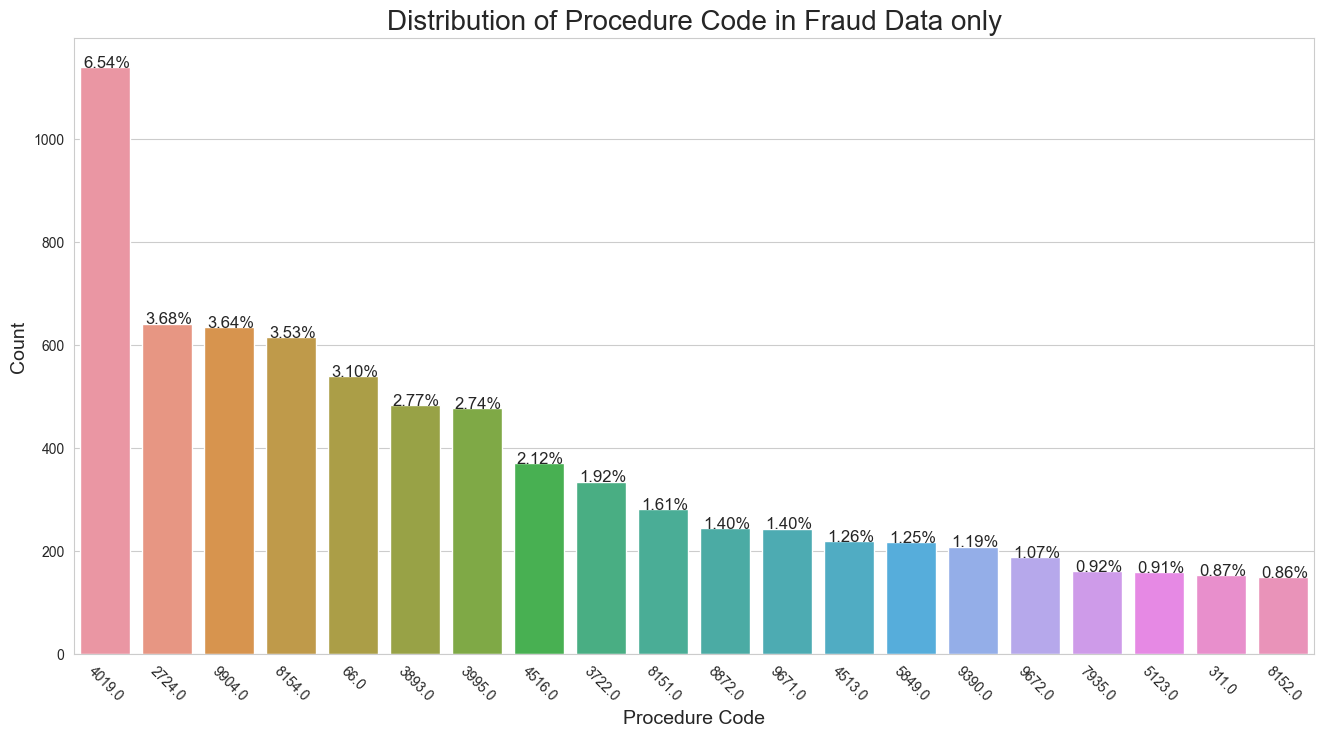

In [110]:
# Plot the countplot for claim diagnosis codes (Top 20) only for fraud data
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='ProcedureCode',y=None, data=ClmProcedureCodeFraud_df, orient ="v", order = ClmProcedureCodeFraud_df['ProcedureCode'].value_counts().head(20).index)
plt.title('Distribution of Procedure Code in Fraud Data only', fontsize=20)
plt.xlabel('Procedure Code', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(rotation=-45)
plt.yticks(size=10)
plt.xticks(rotation=-45, size=10)
percentage_without_hue(ax, ClmProcedureCodeFraud_df['ProcedureCode'], 0.02, 0.01, 12)

### Observation:

1. Top 20 diagnosis codes only for fraud data are shown in the plot.
2. 4019 diagnosis is done 6.5% of the total fraud diagnosis.

In [111]:
Final_Dataset_Train.Inpatient_or_Outpatient.value_counts()

0    517737
1     40474
Name: Inpatient_or_Outpatient, dtype: int64

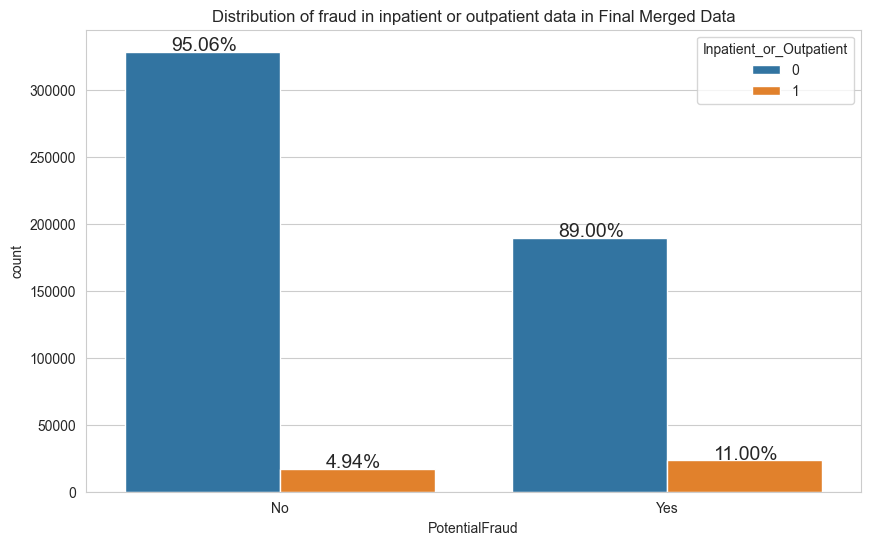

In [112]:
# Plot distribution of fraud in inpatient or outpatient data in Final Merged Data
plt.figure(figsize=(10,6))
ax = sns.countplot(x='PotentialFraud',data=Final_Dataset_Train, hue = 'Inpatient_or_Outpatient', order = Final_Dataset_Train['PotentialFraud'].value_counts().index)
plt.title('Distribution of fraud in inpatient or outpatient data in Final Merged Data')
percentage_with_hue(ax, Final_Dataset_Train['PotentialFraud'], 2,2,-0.08,1000, 14)

### Observation:

1. Out of total fraudulent activities 89% comes from outpatient claim and 11% from inpatient claims in terms of claim count.

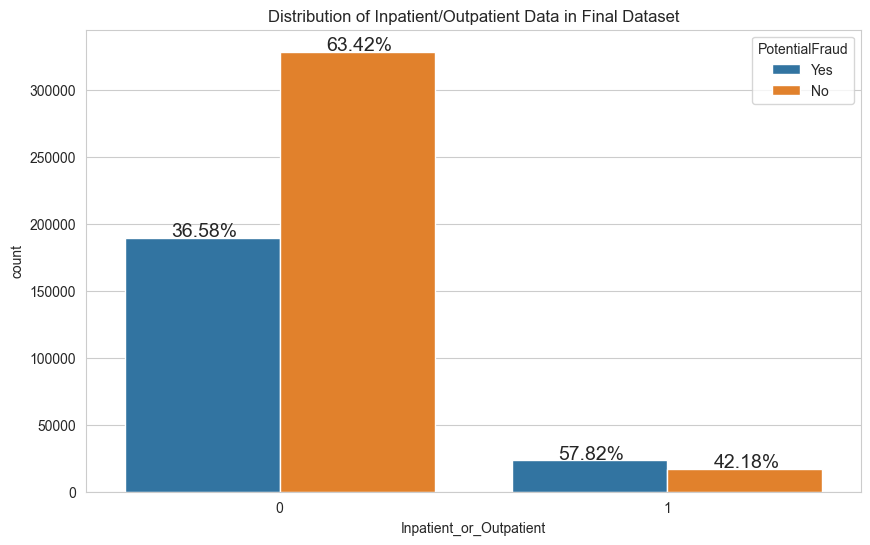

In [113]:
# Plot distribution of gender in Beneficiaries data
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Inpatient_or_Outpatient',data=Final_Dataset_Train, hue = 'PotentialFraud', order = Final_Dataset_Train['Inpatient_or_Outpatient'].value_counts().index)
plt.title('Distribution of Inpatient/Outpatient Data in Final Dataset')
percentage_with_hue(ax, Final_Dataset_Train['Inpatient_or_Outpatient'], 2,2,-0.08,1000, 14)

### Observation:
1. The number of claims are less for inpatient data compared to outpatient data.
2. Even though the claims are less in inpatient data, percentage of fraudulent activity is more in inpatient data(57.8%) whereas it is 36.5% in outpatient data. This is beacuse per claim reimbursement amount for inpatient is much higher(35 times calculated earlier) than the per claim reimbursement amount of outpatient.

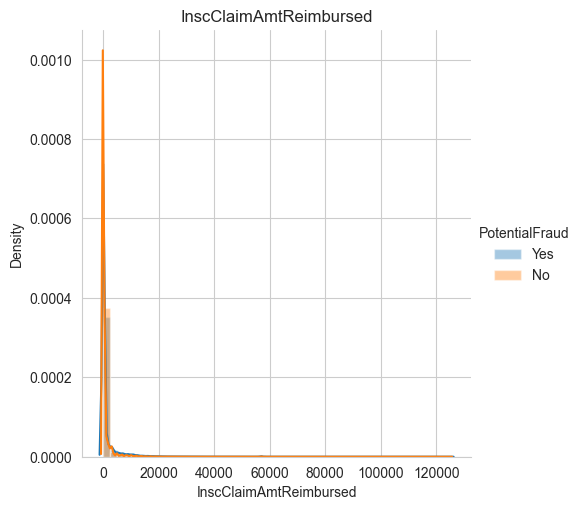

In [114]:
#Histogram of InscClaimAmtReimbursed
sns.FacetGrid(Final_Dataset_Train, hue="PotentialFraud", size=5) \
   .map(sns.distplot, "InscClaimAmtReimbursed") \
   .add_legend();
plt.title('InscClaimAmtReimbursed')
plt.show();

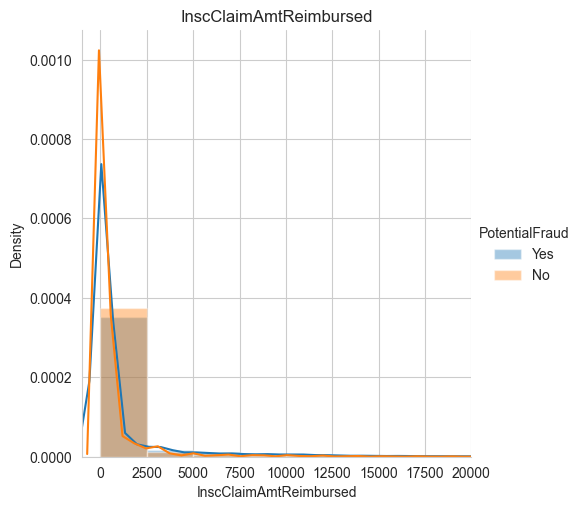

In [115]:
#Histogram of InscClaimAmtReimbursed
sns.FacetGrid(Final_Dataset_Train, hue="PotentialFraud", size=5) \
   .map(sns.distplot, "InscClaimAmtReimbursed") \
   .add_legend();
plt.xlim(-1000,20000)
plt.title('InscClaimAmtReimbursed')
plt.show();

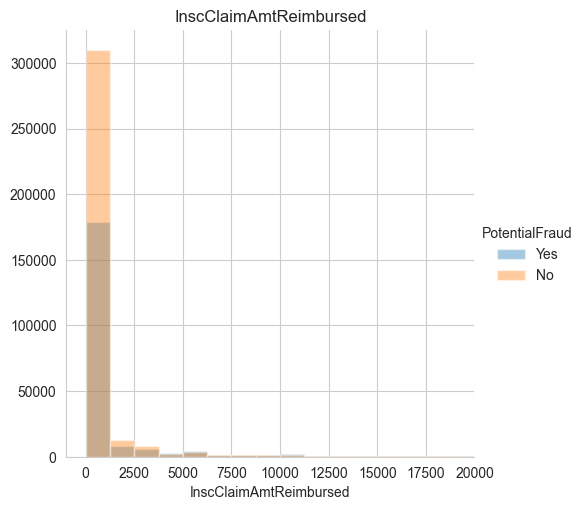

In [116]:
#Histogram of InscClaimAmtReimbursed
sns.FacetGrid(Final_Dataset_Train, hue="PotentialFraud", size=5) \
   .map(sns.distplot, "InscClaimAmtReimbursed", kde = False, bins = 100) \
   .add_legend();
plt.xlim(-1000,20000)
plt.title('InscClaimAmtReimbursed')
plt.show();

### Observation:
1. From the PDF and histogram of claim amount reimbursed we can observe that when the claim amount is less, the number of fraud claims are much higher compared to legitimate claims.
2. For higher amounts also fraudulent count is little higher.

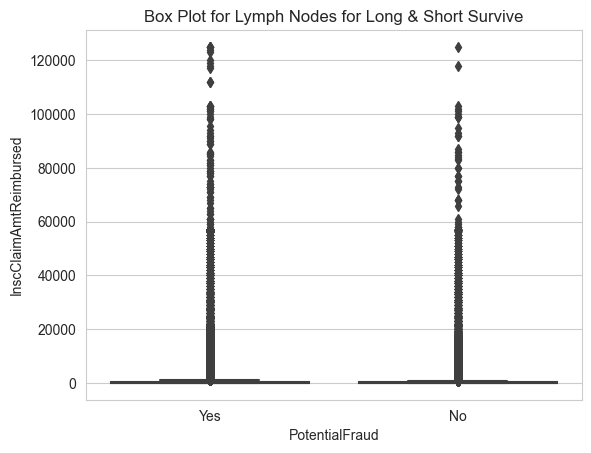

In [117]:
#Box Plot for InscClaimAmtReimbursed
sns.boxplot(x='PotentialFraud',y='InscClaimAmtReimbursed', data=Final_Dataset_Train)
# plt.ylim(0,1000)
plt.title('Box Plot for Lymph Nodes for Long & Short Survive')
plt.show()

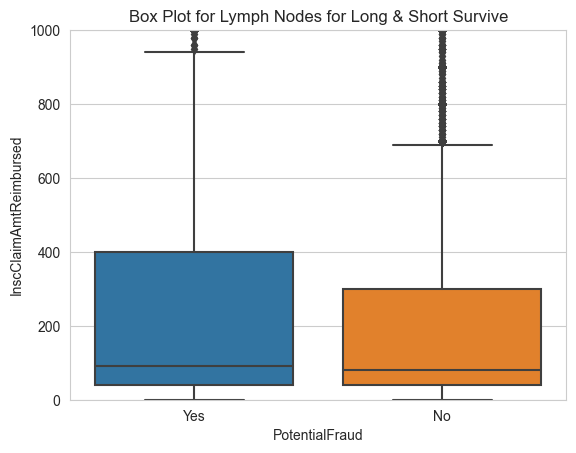

In [118]:
#Box Plot for InscClaimAmtReimbursed
sns.boxplot(x='PotentialFraud',y='InscClaimAmtReimbursed', data=Final_Dataset_Train)
plt.ylim(0,1000)
plt.title('Box Plot for Lymph Nodes for Long & Short Survive')
plt.show()

### Observation:
1. 25th, 50th percentiles are very less for claim amount reimbursed.
2. 75th percentile for fraudulent claims is higher than the legitimate claims.

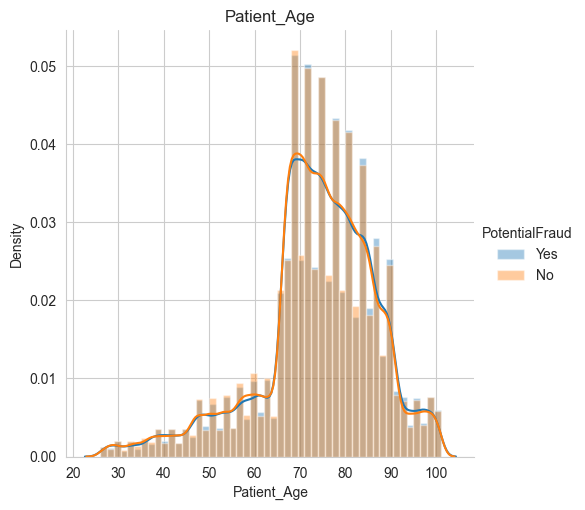

In [119]:
#Histogram of Patient Age
sns.FacetGrid(Final_Dataset_Train, hue="PotentialFraud", size=5) \
   .map(sns.distplot, "Patient_Age") \
   .add_legend();
# plt.xlim(-1000,20000)
plt.title('Patient_Age')
plt.show();

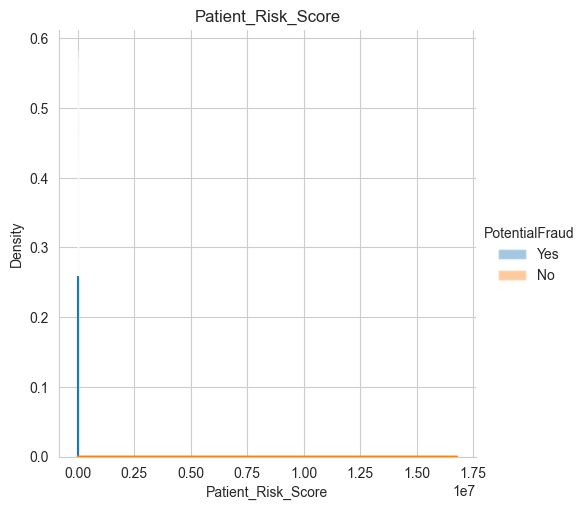

In [120]:
#Histogram of Patient Age
sns.FacetGrid(Final_Dataset_Train, hue="PotentialFraud", size=5) \
   .map(sns.distplot, "Patient_Risk_Score") \
   .add_legend();
# plt.xlim(-1000,20000)
plt.title('Patient_Risk_Score')
plt.show();

### Observation:
1. PDF of patient's age for fraudulent and non fraudulent activity overlaps each other.
2. PDF of patient's risk score for fraudulent and non fraudulent activity overlaps each other.

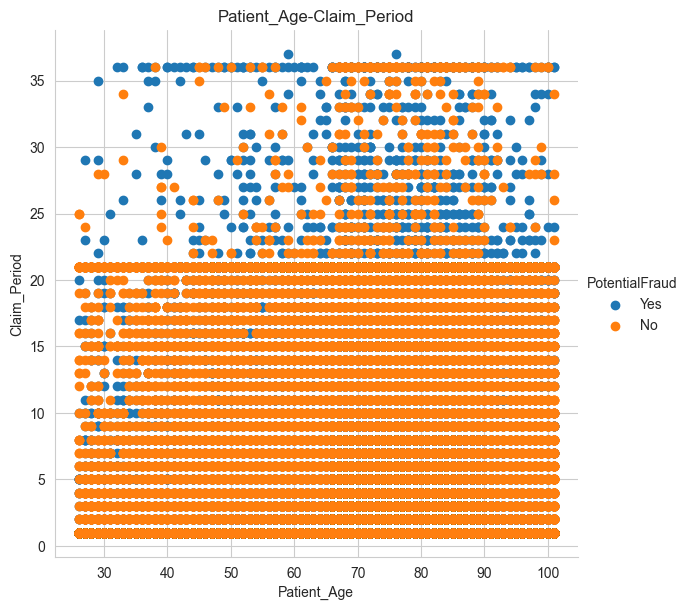

In [121]:
#Scatter Plot- Patient Age vs Claim_Period
sns.set_style("whitegrid")
sns.FacetGrid(Final_Dataset_Train, hue='PotentialFraud', size=6)\
    .map(plt.scatter, "Patient_Age", "Claim_Period")\
    .add_legend();
plt.title('Patient_Age-Claim_Period')
plt.show();

### Observation:
1. From the scatter plot we can see that when patient's age <60 years and claim period more than 20 years, the probability of the transaction is fraudulent is high.

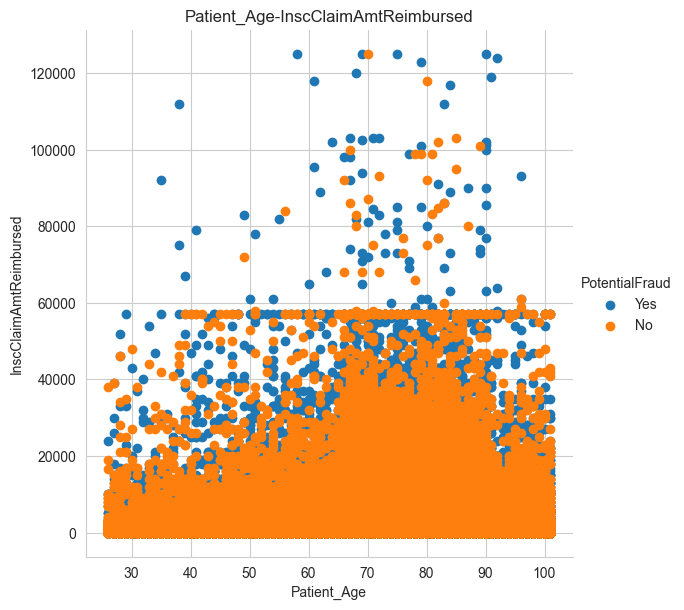

In [122]:
#Scatter Plot- Patient Age vs InscClaimAmtReimbursed
sns.set_style("whitegrid")
sns.FacetGrid(Final_Dataset_Train, hue='PotentialFraud', size=6)\
    .map(plt.scatter, "Patient_Age", "InscClaimAmtReimbursed")\
    .add_legend();
plt.title('Patient_Age-InscClaimAmtReimbursed')
plt.show();

### Observation:
1. From the Scatter Plot of Patient Age vs InscClaimAmtReimbursed I can observe that if patient's age<60 years and claim amount>60000 it tends to be a fraudulent transaction.
2. If the patient's age>88 yrs and claim amount>60000 the probability to be fraudulent is high.

In [123]:
# create new feature total reimbursement amount for inpatient and outpatient
Final_Dataset_Train['IP_OP_TotalReimbursementAmt'] = Final_Dataset_Train['IPAnnualReimbursementAmt'] + Final_Dataset_Train['OPAnnualReimbursementAmt']
# create new feature total deductible amount for inpatient and outpatient
Final_Dataset_Train['IP_OP_AnnualDeductibleAmt'] = Final_Dataset_Train['IPAnnualDeductibleAmt'] + Final_Dataset_Train['OPAnnualDeductibleAmt']

Final_Dataset_Test['IP_OP_TotalReimbursementAmt'] = Final_Dataset_Test['IPAnnualReimbursementAmt'] + Final_Dataset_Test['OPAnnualReimbursementAmt']
Final_Dataset_Test['IP_OP_AnnualDeductibleAmt'] = Final_Dataset_Test['IPAnnualDeductibleAmt'] + Final_Dataset_Test['OPAnnualDeductibleAmt']

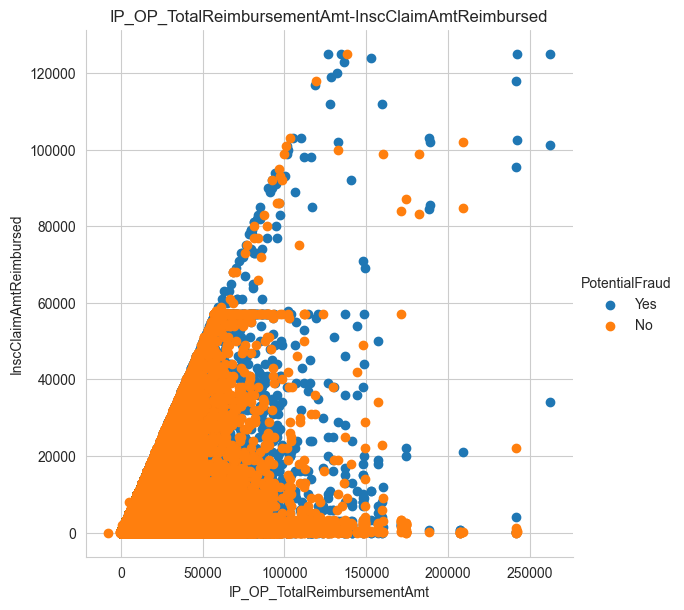

In [124]:
#Scatter Plot- IP_OP_TotalReimbursementAmt vs InscClaimAmtReimbursed
sns.set_style("whitegrid")
sns.FacetGrid(Final_Dataset_Train, hue='PotentialFraud', size=6)\
    .map(plt.scatter, "IP_OP_TotalReimbursementAmt", "InscClaimAmtReimbursed")\
    .add_legend();
plt.title('IP_OP_TotalReimbursementAmt-InscClaimAmtReimbursed')
plt.show();

### Observation:
1. If InscClaimAmtReimbursed>10000 and IP_OP_TotalReimbursementAmt>120000 then the chance to be a fraudulent transaction is high.

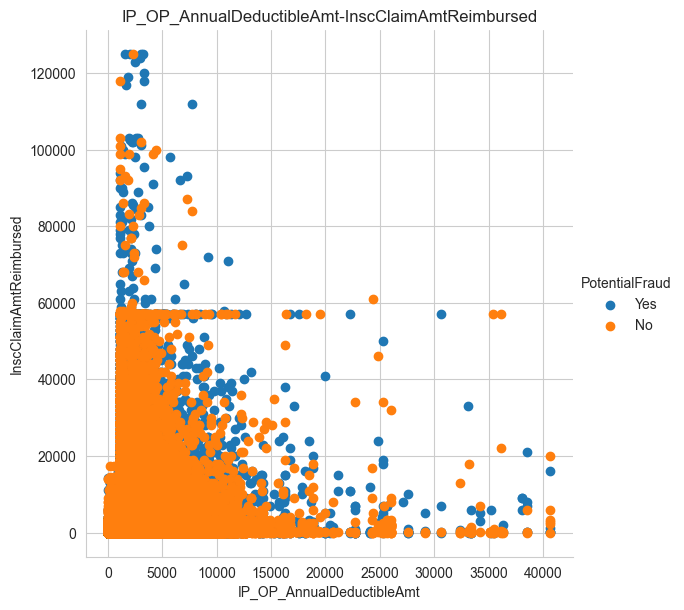

In [125]:
#Scatter Plot- IP_OP_AnnualDeductibleAmt vs InscClaimAmtReimbursed
sns.set_style("whitegrid")
sns.FacetGrid(Final_Dataset_Train, hue='PotentialFraud', size=6)\
    .map(plt.scatter, "IP_OP_AnnualDeductibleAmt", "InscClaimAmtReimbursed")\
    .add_legend()
plt.title('IP_OP_AnnualDeductibleAmt-InscClaimAmtReimbursed')
plt.show()

### Observation:
1. If InscClaimAmtReimbursed>600000 and IP_OP_AnnualDeductibleAmt<5000 then the chance to be a fraudulent transaction is high.

In [126]:
Final_Dataset_Train.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Hospitalization_Duration', 'Claim_Period',
       'ExtraClaimDays', 'ClaimStart_Year', 'ClaimStart_Month',
       'ClaimEnd_Year', 'ClaimEnd_Month', 'Admission_Year', 'Admission_Month',
       'Discharge_Year', 'Discharge_Month', 'Inpatient_or_Outpatient', 'DOB',
       'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State

In [127]:
len(Final_Dataset_Train.columns)

74

In [128]:
Final_Dataset_Train.head(2)

BeneID    ClaimID ClaimStartDt ClaimEndDt  Provider  \
0  BENE11001   CLM46614   2009-04-12 2009-04-18  PRV55912   
1  BENE16973  CLM565430   2009-09-06 2009-09-06  PRV55912   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                      50          PHY365867          PHY327147   

  OtherPhysician AdmissionDt ClmAdmitDiagnosisCode  DeductibleAmtPaid  \
0            NaN  2009-04-12                  7866             1068.0   
1            NaN         NaT                   NaN                0.0   

  DischargeDt DiagnosisGroupCode ClmDiagnosisCode_1 ClmDiagnosisCode_2  \
0  2009-04-18                201               1970               4019   
1         NaT                NaN              V7183              53081   

  ClmDiagnosisCode_3 ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6  \
0               5853               7843               2768              71590   
1              78959               4280              E8788              78079   

  ClmDiagnosisCode_7 ClmDiagnosisCode_8 ClmDiagnosisCode_9  \
0               2724              19889               5849   
1              79902              25002              71848   

  ClmDiagnosisCode_10  ClmProcedureCode_1  ClmProcedureCode_2  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   

   ClmProcedureCode_3  ClmProcedureCode_4  ClmProcedureCode_5  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   

   ClmProcedureCode_6  Hospitalization_Duration  Claim_Period  ExtraClaimDays  \
0                 NaN                       7.0             7             0.0   
1                 NaN                       NaN             1             NaN   

   ClaimStart_Year  ClaimStart_Month  ClaimEnd_Year  ClaimEnd_Month  \
0             2009                 4           2009               4   
1             2009                 9           2009               9   

   Admission_Year  Admission_Month  Discharge_Year  Discharge_Month  \
0          2009.0              4.0          2009.0              4.0   
1             NaN              NaN             NaN              NaN   

   Inpatient_or_Outpatient        DOB DOD  Gender  Race  \
0                        1 1943-01-01 NaT       1     1   
1                        0 1932-05-01 NaT       1     1   

   RenalDiseaseIndicator  State  County  NoOfMonths_PartACov  \
0                      0     39     230                   12   
1                      0     39     310                   12   

   NoOfMonths_PartBCov  ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
0                   12                      1                         0   
1                   12                      1                         1   

   ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  \
0                          1                   0                           0   
1                          1                   0                           0   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       0                     0                          1   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         0                                1   
1                         0                                0   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   0                     24000                   2136   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  Patient_Risk_Score  \
0                        60                     70                   7   
1                       450                  

## Missing value imputation

In [129]:
# find the columns which contain null values
Final_Dataset_Train.columns[Final_Dataset_Train.isnull().any()].tolist()

['AttendingPhysician',
 'OperatingPhysician',
 'OtherPhysician',
 'AdmissionDt',
 'ClmAdmitDiagnosisCode',
 'DeductibleAmtPaid',
 'DischargeDt',
 'DiagnosisGroupCode',
 'ClmDiagnosisCode_1',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmDiagnosisCode_10',
 'ClmProcedureCode_1',
 'ClmProcedureCode_2',
 'ClmProcedureCode_3',
 'ClmProcedureCode_4',
 'ClmProcedureCode_5',
 'ClmProcedureCode_6',
 'Hospitalization_Duration',
 'ExtraClaimDays',
 'Admission_Year',
 'Admission_Month',
 'Discharge_Year',
 'Discharge_Month',
 'DOD']

All the missing values have been filled with Zero.

In [130]:
## Fill missing results using 0
Final_Dataset_Train = Final_Dataset_Train.fillna(0).copy()
Final_Dataset_Test = Final_Dataset_Test.fillna(0).copy()

In [131]:
Final_Dataset_Train.isna().sum().sum()

1

In [132]:
Final_Dataset_Test.isna().sum().sum()

0

## Data Transformation and Feature Engineering

### Group By Provider

In [133]:
def create_feature_using_groupby(Train_df, Test_df, gruopby_col, operation_col,operation):
    '''
    This function groupby the 'Train_df' and 'Test_df' dataframe by 'gruopby_col' and performs 'operation' on 'operation_col'
    '''
    
    for col in operation_col:
        # create new column name for the dataframe
        new_col_name = 'Per'+''.join(gruopby_col)+'_'+operation+'_'+col
        print(new_col_name)
        Train_df[new_col_name] = Train_df.groupby(gruopby_col)[col].transform(operation)
        Test_df[new_col_name] = Test_df.groupby(gruopby_col)[col].transform(operation)
    return Train_df, Test_df

As Providers fills and submits the claim they are mainly associated with the fraudulent activity. So, I will group by provider and take the mean of reimbursed, deducted etc. If average claim amount or claim period is high for a provider, then that is suspicious.

In [134]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test = create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['Provider'], columns, 'mean')

PerProvider_mean_InscClaimAmtReimbursed
PerProvider_mean_DeductibleAmtPaid
PerProvider_mean_IPAnnualReimbursementAmt
PerProvider_mean_IPAnnualDeductibleAmt
PerProvider_mean_OPAnnualReimbursementAmt
PerProvider_mean_OPAnnualDeductibleAmt
PerProvider_mean_Patient_Age
PerProvider_mean_NoOfMonths_PartACov
PerProvider_mean_NoOfMonths_PartBCov
PerProvider_mean_Hospitalization_Duration
PerProvider_mean_Claim_Period
PerProvider_mean_Patient_Risk_Score


Beneficiaries also associated with fraudulent activity. So, group by the dataframe by Beneficiary Id and take mean. If average claim amount is high for a beneficiary then that is suspicious.

In [135]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['BeneID'], columns, 'mean')

PerBeneID_mean_InscClaimAmtReimbursed
PerBeneID_mean_DeductibleAmtPaid
PerBeneID_mean_IPAnnualReimbursementAmt
PerBeneID_mean_IPAnnualDeductibleAmt
PerBeneID_mean_OPAnnualReimbursementAmt
PerBeneID_mean_OPAnnualDeductibleAmt
PerBeneID_mean_Patient_Age
PerBeneID_mean_Hospitalization_Duration
PerBeneID_mean_Claim_Period
PerBeneID_mean_Patient_Risk_Score


Physicians are also associated with fraudulent activity. So, group by AttendingPhysician, OperatingPhysician and OtherPhysician and take mean. High amounts for a physician is suspicious.

In [136]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['AttendingPhysician'], columns, 'mean')

PerAttendingPhysician_mean_InscClaimAmtReimbursed
PerAttendingPhysician_mean_DeductibleAmtPaid
PerAttendingPhysician_mean_IPAnnualReimbursementAmt
PerAttendingPhysician_mean_IPAnnualDeductibleAmt
PerAttendingPhysician_mean_OPAnnualReimbursementAmt
PerAttendingPhysician_mean_OPAnnualDeductibleAmt
PerAttendingPhysician_mean_Patient_Age
PerAttendingPhysician_mean_Hospitalization_Duration
PerAttendingPhysician_mean_Claim_Period
PerAttendingPhysician_mean_Patient_Risk_Score


In [137]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['OperatingPhysician'], columns, 'mean')

PerOperatingPhysician_mean_InscClaimAmtReimbursed
PerOperatingPhysician_mean_DeductibleAmtPaid
PerOperatingPhysician_mean_IPAnnualReimbursementAmt
PerOperatingPhysician_mean_IPAnnualDeductibleAmt
PerOperatingPhysician_mean_OPAnnualReimbursementAmt
PerOperatingPhysician_mean_OPAnnualDeductibleAmt
PerOperatingPhysician_mean_Patient_Age
PerOperatingPhysician_mean_Hospitalization_Duration
PerOperatingPhysician_mean_Claim_Period
PerOperatingPhysician_mean_Patient_Risk_Score


In [138]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['OtherPhysician'], columns, 'mean')

PerOtherPhysician_mean_InscClaimAmtReimbursed
PerOtherPhysician_mean_DeductibleAmtPaid
PerOtherPhysician_mean_IPAnnualReimbursementAmt
PerOtherPhysician_mean_IPAnnualDeductibleAmt
PerOtherPhysician_mean_OPAnnualReimbursementAmt
PerOtherPhysician_mean_OPAnnualDeductibleAmt
PerOtherPhysician_mean_Patient_Age
PerOtherPhysician_mean_Hospitalization_Duration
PerOtherPhysician_mean_Claim_Period
PerOtherPhysician_mean_Patient_Risk_Score


Group by all disgnosis codes to combine the patients who performed the same tests has been done to get average of costs etc.

In [139]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['DiagnosisGroupCode'], columns, 'mean')

PerDiagnosisGroupCode_mean_InscClaimAmtReimbursed
PerDiagnosisGroupCode_mean_DeductibleAmtPaid
PerDiagnosisGroupCode_mean_IPAnnualReimbursementAmt
PerDiagnosisGroupCode_mean_IPAnnualDeductibleAmt
PerDiagnosisGroupCode_mean_OPAnnualReimbursementAmt
PerDiagnosisGroupCode_mean_OPAnnualDeductibleAmt
PerDiagnosisGroupCode_mean_Patient_Age
PerDiagnosisGroupCode_mean_Hospitalization_Duration
PerDiagnosisGroupCode_mean_Claim_Period
PerDiagnosisGroupCode_mean_Patient_Risk_Score


In [140]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmAdmitDiagnosisCode'], columns, 'mean')

PerClmAdmitDiagnosisCode_mean_InscClaimAmtReimbursed
PerClmAdmitDiagnosisCode_mean_DeductibleAmtPaid
PerClmAdmitDiagnosisCode_mean_IPAnnualReimbursementAmt
PerClmAdmitDiagnosisCode_mean_IPAnnualDeductibleAmt
PerClmAdmitDiagnosisCode_mean_OPAnnualReimbursementAmt
PerClmAdmitDiagnosisCode_mean_OPAnnualDeductibleAmt
PerClmAdmitDiagnosisCode_mean_Patient_Age
PerClmAdmitDiagnosisCode_mean_Hospitalization_Duration
PerClmAdmitDiagnosisCode_mean_Claim_Period
PerClmAdmitDiagnosisCode_mean_Patient_Risk_Score


Group by all procedure codes has been done to combine the patients who gone through same procedure take average of costs etc.

In [141]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmProcedureCode_1'], columns, 'mean')

PerClmProcedureCode_1_mean_InscClaimAmtReimbursed
PerClmProcedureCode_1_mean_DeductibleAmtPaid
PerClmProcedureCode_1_mean_IPAnnualReimbursementAmt
PerClmProcedureCode_1_mean_IPAnnualDeductibleAmt
PerClmProcedureCode_1_mean_OPAnnualReimbursementAmt
PerClmProcedureCode_1_mean_OPAnnualDeductibleAmt
PerClmProcedureCode_1_mean_Patient_Age
PerClmProcedureCode_1_mean_Hospitalization_Duration
PerClmProcedureCode_1_mean_Claim_Period
PerClmProcedureCode_1_mean_Patient_Risk_Score


In [142]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmProcedureCode_2'], columns, 'mean')

PerClmProcedureCode_2_mean_InscClaimAmtReimbursed
PerClmProcedureCode_2_mean_DeductibleAmtPaid
PerClmProcedureCode_2_mean_IPAnnualReimbursementAmt
PerClmProcedureCode_2_mean_IPAnnualDeductibleAmt
PerClmProcedureCode_2_mean_OPAnnualReimbursementAmt
PerClmProcedureCode_2_mean_OPAnnualDeductibleAmt
PerClmProcedureCode_2_mean_Patient_Age
PerClmProcedureCode_2_mean_Hospitalization_Duration
PerClmProcedureCode_2_mean_Claim_Period
PerClmProcedureCode_2_mean_Patient_Risk_Score


In [143]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmProcedureCode_3'], columns, 'mean')

PerClmProcedureCode_3_mean_InscClaimAmtReimbursed
PerClmProcedureCode_3_mean_DeductibleAmtPaid
PerClmProcedureCode_3_mean_IPAnnualReimbursementAmt
PerClmProcedureCode_3_mean_IPAnnualDeductibleAmt
PerClmProcedureCode_3_mean_OPAnnualReimbursementAmt
PerClmProcedureCode_3_mean_OPAnnualDeductibleAmt
PerClmProcedureCode_3_mean_Patient_Age
PerClmProcedureCode_3_mean_Hospitalization_Duration
PerClmProcedureCode_3_mean_Claim_Period
PerClmProcedureCode_3_mean_Patient_Risk_Score


In [144]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmProcedureCode_4'], columns, 'mean')

PerClmProcedureCode_4_mean_InscClaimAmtReimbursed
PerClmProcedureCode_4_mean_DeductibleAmtPaid
PerClmProcedureCode_4_mean_IPAnnualReimbursementAmt
PerClmProcedureCode_4_mean_IPAnnualDeductibleAmt
PerClmProcedureCode_4_mean_OPAnnualReimbursementAmt
PerClmProcedureCode_4_mean_OPAnnualDeductibleAmt
PerClmProcedureCode_4_mean_Patient_Age
PerClmProcedureCode_4_mean_Hospitalization_Duration
PerClmProcedureCode_4_mean_Claim_Period
PerClmProcedureCode_4_mean_Patient_Risk_Score


In [145]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmProcedureCode_5'], columns, 'mean')

PerClmProcedureCode_5_mean_InscClaimAmtReimbursed
PerClmProcedureCode_5_mean_DeductibleAmtPaid
PerClmProcedureCode_5_mean_IPAnnualReimbursementAmt
PerClmProcedureCode_5_mean_IPAnnualDeductibleAmt
PerClmProcedureCode_5_mean_OPAnnualReimbursementAmt
PerClmProcedureCode_5_mean_OPAnnualDeductibleAmt
PerClmProcedureCode_5_mean_Patient_Age
PerClmProcedureCode_5_mean_Hospitalization_Duration
PerClmProcedureCode_5_mean_Claim_Period
PerClmProcedureCode_5_mean_Patient_Risk_Score


In [146]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmProcedureCode_6'], columns, 'mean')

PerClmProcedureCode_6_mean_InscClaimAmtReimbursed
PerClmProcedureCode_6_mean_DeductibleAmtPaid
PerClmProcedureCode_6_mean_IPAnnualReimbursementAmt
PerClmProcedureCode_6_mean_IPAnnualDeductibleAmt
PerClmProcedureCode_6_mean_OPAnnualReimbursementAmt
PerClmProcedureCode_6_mean_OPAnnualDeductibleAmt
PerClmProcedureCode_6_mean_Patient_Age
PerClmProcedureCode_6_mean_Hospitalization_Duration
PerClmProcedureCode_6_mean_Claim_Period
PerClmProcedureCode_6_mean_Patient_Risk_Score


In [147]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmDiagnosisCode_1'], columns, 'mean')

PerClmDiagnosisCode_1_mean_InscClaimAmtReimbursed
PerClmDiagnosisCode_1_mean_DeductibleAmtPaid
PerClmDiagnosisCode_1_mean_IPAnnualReimbursementAmt
PerClmDiagnosisCode_1_mean_IPAnnualDeductibleAmt
PerClmDiagnosisCode_1_mean_OPAnnualReimbursementAmt
PerClmDiagnosisCode_1_mean_OPAnnualDeductibleAmt
PerClmDiagnosisCode_1_mean_Patient_Age
PerClmDiagnosisCode_1_mean_Hospitalization_Duration
PerClmDiagnosisCode_1_mean_Claim_Period
PerClmDiagnosisCode_1_mean_Patient_Risk_Score


In [148]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmDiagnosisCode_2'], columns, 'mean')

PerClmDiagnosisCode_2_mean_InscClaimAmtReimbursed
PerClmDiagnosisCode_2_mean_DeductibleAmtPaid
PerClmDiagnosisCode_2_mean_IPAnnualReimbursementAmt
PerClmDiagnosisCode_2_mean_IPAnnualDeductibleAmt
PerClmDiagnosisCode_2_mean_OPAnnualReimbursementAmt
PerClmDiagnosisCode_2_mean_OPAnnualDeductibleAmt
PerClmDiagnosisCode_2_mean_Patient_Age
PerClmDiagnosisCode_2_mean_Hospitalization_Duration
PerClmDiagnosisCode_2_mean_Claim_Period
PerClmDiagnosisCode_2_mean_Patient_Risk_Score


In [149]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmDiagnosisCode_3'], columns, 'mean')

PerClmDiagnosisCode_3_mean_InscClaimAmtReimbursed
PerClmDiagnosisCode_3_mean_DeductibleAmtPaid
PerClmDiagnosisCode_3_mean_IPAnnualReimbursementAmt
PerClmDiagnosisCode_3_mean_IPAnnualDeductibleAmt
PerClmDiagnosisCode_3_mean_OPAnnualReimbursementAmt
PerClmDiagnosisCode_3_mean_OPAnnualDeductibleAmt
PerClmDiagnosisCode_3_mean_Patient_Age
PerClmDiagnosisCode_3_mean_Hospitalization_Duration
PerClmDiagnosisCode_3_mean_Claim_Period
PerClmDiagnosisCode_3_mean_Patient_Risk_Score


In [150]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmDiagnosisCode_4'], columns, 'mean')

PerClmDiagnosisCode_4_mean_InscClaimAmtReimbursed
PerClmDiagnosisCode_4_mean_DeductibleAmtPaid
PerClmDiagnosisCode_4_mean_IPAnnualReimbursementAmt
PerClmDiagnosisCode_4_mean_IPAnnualDeductibleAmt
PerClmDiagnosisCode_4_mean_OPAnnualReimbursementAmt
PerClmDiagnosisCode_4_mean_OPAnnualDeductibleAmt
PerClmDiagnosisCode_4_mean_Patient_Age
PerClmDiagnosisCode_4_mean_Hospitalization_Duration
PerClmDiagnosisCode_4_mean_Claim_Period
PerClmDiagnosisCode_4_mean_Patient_Risk_Score


In [151]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmDiagnosisCode_5'], columns, 'mean')

PerClmDiagnosisCode_5_mean_InscClaimAmtReimbursed
PerClmDiagnosisCode_5_mean_DeductibleAmtPaid
PerClmDiagnosisCode_5_mean_IPAnnualReimbursementAmt
PerClmDiagnosisCode_5_mean_IPAnnualDeductibleAmt
PerClmDiagnosisCode_5_mean_OPAnnualReimbursementAmt
PerClmDiagnosisCode_5_mean_OPAnnualDeductibleAmt
PerClmDiagnosisCode_5_mean_Patient_Age
PerClmDiagnosisCode_5_mean_Hospitalization_Duration
PerClmDiagnosisCode_5_mean_Claim_Period
PerClmDiagnosisCode_5_mean_Patient_Risk_Score


In [152]:
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']

Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['ClmDiagnosisCode_6'], columns, 'mean')

PerClmDiagnosisCode_6_mean_InscClaimAmtReimbursed
PerClmDiagnosisCode_6_mean_DeductibleAmtPaid
PerClmDiagnosisCode_6_mean_IPAnnualReimbursementAmt
PerClmDiagnosisCode_6_mean_IPAnnualDeductibleAmt
PerClmDiagnosisCode_6_mean_OPAnnualReimbursementAmt
PerClmDiagnosisCode_6_mean_OPAnnualDeductibleAmt
PerClmDiagnosisCode_6_mean_Patient_Age
PerClmDiagnosisCode_6_mean_Hospitalization_Duration
PerClmDiagnosisCode_6_mean_Claim_Period
PerClmDiagnosisCode_6_mean_Patient_Risk_Score


In [153]:
# Count the claims per provider
Final_Dataset_Train, Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, ['Provider'], ['ClaimID'], 'count')

PerProvider_count_ClaimID


Sometimes Providers along with physicians, beneficiaries and sometimes diagnosis and procedures are also associated. So considered another feature with provider id and group by. Considered count after that.

In [154]:
columns = ['ClaimID']
grp_by_cols = ['BeneID', 'AttendingPhysician', 'OtherPhysician', 'OperatingPhysician', 'ClmAdmitDiagnosisCode', 'ClmProcedureCode_1',
               'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
               'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'DiagnosisGroupCode']
for ele in grp_by_cols:
    lst = ['Provider', ele]
    Final_Dataset_Train,Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Train, Final_Dataset_Test, lst, columns, 'count')

PerProviderBeneID_count_ClaimID
PerProviderAttendingPhysician_count_ClaimID
PerProviderOtherPhysician_count_ClaimID
PerProviderOperatingPhysician_count_ClaimID
PerProviderClmAdmitDiagnosisCode_count_ClaimID
PerProviderClmProcedureCode_1_count_ClaimID
PerProviderClmProcedureCode_2_count_ClaimID
PerProviderClmProcedureCode_3_count_ClaimID
PerProviderClmProcedureCode_4_count_ClaimID
PerProviderClmProcedureCode_5_count_ClaimID
PerProviderClmDiagnosisCode_1_count_ClaimID
PerProviderClmDiagnosisCode_2_count_ClaimID
PerProviderClmDiagnosisCode_3_count_ClaimID
PerProviderClmDiagnosisCode_4_count_ClaimID
PerProviderClmDiagnosisCode_5_count_ClaimID
PerProviderClmDiagnosisCode_6_count_ClaimID
PerProviderDiagnosisGroupCode_count_ClaimID


In [155]:
Final_Dataset_Train.columns[:80]

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Hospitalization_Duration', 'Claim_Period',
       'ExtraClaimDays', 'ClaimStart_Year', 'ClaimStart_Month',
       'ClaimEnd_Year', 'ClaimEnd_Month', 'Admission_Year', 'Admission_Month',
       'Discharge_Year', 'Discharge_Month', 'Inpatient_or_Outpatient', 'DOB',
       'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State

In [156]:
Final_Dataset_Train.shape

(558211, 284)

In [157]:
Final_Dataset_Test.shape

(135392, 283)

In [158]:
for col in Final_Dataset_Train.columns:
    if col not in Final_Dataset_Test.columns:
        print(col)

PotentialFraud


### Remove the columns which are no longer required

In [159]:
remove_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                'ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5',
                'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5',
                'ClmProcedureCode_6','ClmAdmitDiagnosisCode', 'AdmissionDt','ClaimStart_Year', 'ClaimStart_Year', 'ClaimStart_Month',
                'ClaimEnd_Year', 'ClaimEnd_Month', 'Admission_Year', 'Admission_Month', 'Discharge_Year', 'Discharge_Month',
                'DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD','Birth_Year', 'Birth_Month','State', 'County']

Final_Dataset_Train_FE=Final_Dataset_Train.drop(columns=remove_columns, axis=1)
Final_Dataset_Test_FE=Final_Dataset_Test.drop(columns=remove_columns, axis=1)

In [160]:
Final_Dataset_Train.head()

BeneID    ClaimID ClaimStartDt ClaimEndDt  Provider  \
0  BENE11001   CLM46614   2009-04-12 2009-04-18  PRV55912   
1  BENE16973  CLM565430   2009-09-06 2009-09-06  PRV55912   
2  BENE17521   CLM34721   2009-01-20 2009-02-01  PRV55912   
3  BENE21718   CLM72336   2009-10-17 2009-11-04  PRV55912   
4  BENE22934   CLM73394   2009-10-25 2009-10-29  PRV55912   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                  0   
1                      50          PHY365867          PHY327147   
2                   19000          PHY349293          PHY370861   
3                   17000          PHY334706          PHY334706   
4                   13000          PHY390614          PHY323689   

  OtherPhysician          AdmissionDt ClmAdmitDiagnosisCode  \
0              0  2009-04-12 00:00:00                  7866   
1              0                    0                     0   
2      PHY363291  2009-01-20 00:00:00                 45340   
3              0  2009-10-17 00:00:00                 V5789   
4      PHY363291  2009-10-25 00:00:00                 71946   

   DeductibleAmtPaid          DischargeDt DiagnosisGroupCode  \
0             1068.0  2009-04-18 00:00:00                201   
1                0.0                    0                  0   
2             1068.0  2009-02-01 00:00:00                987   
3             1068.0  2009-11-04 00:00:00                941   
4             1068.0  2009-10-29 00:00:00                506   

  ClmDiagnosisCode_1 ClmDiagnosisCode_2 ClmDiagnosisCode_3 ClmDiagnosisCode_4  \
0               1970               4019               5853               7843   
1              V7183              53081              78959               4280   
2               4240               2639               2948              40390   
3              V5789               4168              73313               7812   
4              71535              71960               4019              V1202   

  ClmDiagnosisCode_5 ClmDiagnosisCode_6 ClmDiagnosisCode_7 ClmDiagnosisCode_8  \
0               2768              71590               2724              19889   
1              E8788              78079              79902              25002   
2              45821              28489               5854               2753   
3               7993              78830              72273              43812   
4               4240               2449               2768                  0   

  ClmDiagnosisCode_9 ClmDiagnosisCode_10  ClmProcedureCode_1  \
0               5849                   0                 0.0   
1              71848                   0                 0.0   
2              E9305                   0              7769.0   
3               4019                   0              9338.0   
4                  0                   0              8154.0   

   ClmProcedureCode_2  ClmProcedureCode_3  ClmProcedureCode_4  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2              5849.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   ClmProcedureCode_5  ClmProcedureCode_6  Hospitalization_Duration  \
0                 0.0                 0.0                       7.0   
1                 0.0                 0.0                       0.0   
2                 0.0                 0.0                      13.0   
3                 0.0                 0.0                      19.0   
4                 0.0                 0.0                       5.0   

   Claim_Period  ExtraClaimDays  ClaimStart_Year  ClaimStart_Month  \
0             7             0.0             2009                 4   
1             1             0.0             2009                 9   
2            13             0.0             2009                 1   
3            19

In [161]:
# Convert type of Gender and Race to categorical
Final_Dataset_Train_FE.Gender=Final_Dataset_Train_FE.Gender.astype('category')
Final_Dataset_Test_FE.Gender=Final_Dataset_Test_FE.Gender.astype('category')

Final_Dataset_Train_FE.Race=Final_Dataset_Train_FE.Race.astype('category')
Final_Dataset_Test_FE.Race=Final_Dataset_Test_FE.Race.astype('category')

In [162]:
Final_Dataset_Train_FE.head()

Provider  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0  PRV55912                   26000             1068.0   
1  PRV55912                      50                0.0   
2  PRV55912                   19000             1068.0   
3  PRV55912                   17000             1068.0   
4  PRV55912                   13000             1068.0   

   Hospitalization_Duration  Claim_Period  ExtraClaimDays  \
0                       7.0             7             0.0   
1                       0.0             1             0.0   
2                      13.0            13             0.0   
3                      19.0            19             0.0   
4                       5.0             5             0.0   

   Inpatient_or_Outpatient Gender Race  RenalDiseaseIndicator  \
0                        1      1    1                      0   
1                        0      1    1                      0   
2                        1      0    1                      0   
3                        1      1    1                      0   
4                        1      0    1                      0   

   NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  \
0                   12                   12                      1   
1                   12                   12                      1   
2                   12                   12                      1   
3                   12                   12                      0   
4                   12                   12                      0   

   ChronicCond_Heartfailure  ChronicCond_KidneyDisease  ChronicCond_Cancer  \
0                         0                          1                   0   
1                         1                          1                   0   
2                         1                          1                   0   
3                         0                          0                   0   
4                         1                          0                   0   

   ChronicCond_ObstrPulmonary  ChronicCond_Depression  ChronicCond_Diabetes  \
0                           0                       1                     1   
1                           0                       0                     0   
2                           1                       0                     0   
3                           0                       0                     0   
4                           1                       0                     1   

   ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  \
0                          1                         0   
1                          1                         0   
2                          1                         0   
3                          1                         1   
4                          1                         1   

   ChronicCond_rheumatoidarthritis  ChronicCond_stroke  \
0                                1                   1   
1                                0                   0   
2                                0                   0   
3                                0                   0   
4                                1                   0   

   IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt  \
0                     36000                   3204                        60   
1                     24000                   2136                       450   
2                     19000                   1068                       100   
3                     17000                   1068                      1050   
4                     27000                   2136                       450   

   OPAnnualDeductibleAmt  Patient_Risk_Score  Patient_Age  isDead  \
0                     70                   7         67.0       0   
1                    200                   4         78.0       0   
2                     20                   5         96.0       0   
3                    540                   2         87.0       0   
4      

In [163]:
# One hot encoding for gender and Race
Final_Dataset_Train_FE=pd.get_dummies(Final_Dataset_Train_FE,columns=['Gender','Race'])
Final_Dataset_Test_FE=pd.get_dummies(Final_Dataset_Test_FE,columns=['Gender','Race'])

In [164]:
Final_Dataset_Train_FE.head()

Provider  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0  PRV55912                   26000             1068.0   
1  PRV55912                      50                0.0   
2  PRV55912                   19000             1068.0   
3  PRV55912                   17000             1068.0   
4  PRV55912                   13000             1068.0   

   Hospitalization_Duration  Claim_Period  ExtraClaimDays  \
0                       7.0             7             0.0   
1                       0.0             1             0.0   
2                      13.0            13             0.0   
3                      19.0            19             0.0   
4                       5.0             5             0.0   

   Inpatient_or_Outpatient  RenalDiseaseIndicator  NoOfMonths_PartACov  \
0                        1                      0                   12   
1                        0                      0                   12   
2                        1                      0                   12   
3                        1                      0                   12   
4                        1                      0                   12   

   NoOfMonths_PartBCov  ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
0                   12                      1                         0   
1                   12                      1                         1   
2                   12                      1                         1   
3                   12                      0                         0   
4                   12                      0                         1   

   ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  \
0                          1                   0                           0   
1                          1                   0                           0   
2                          1                   0                           1   
3                          0                   0                           0   
4                          0                   0                           1   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       0                     0                          1   
2                       0                     0                          1   
3                       0                     0                          1   
4                       0                     1                          1   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         1                                0   
4                         1                                1   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   0                     24000                   2136   
2                   0                     19000                   1068   
3                   0                     17000                   1068   
4                   0                     27000                   2136   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  Patient_Risk_Score  \
0                        60                     70                   7   
1                       450                    200                   4   
2                       100                     20                   5   
3                      1050                    540                   2   
4                       450                    160                   6   

   Patient_Age  isDead PotentialFraud  IP_OP_TotalReimbursementAmt  \
0         67.0       0            Yes                        36060   
1         78.0       0    

#### Group by Provider and take sum to create feature corresponding to each provider

In [165]:
Final_Dataset_Provider_Train = Final_Dataset_Train_FE.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
Final_Dataset_Provider_Test  = Final_Dataset_Test_FE.groupby(['Provider'],as_index=False).agg('sum')

In [166]:
Final_Dataset_Provider_Train.shape

(5410, 247)

In [167]:
Final_Dataset_Provider_Test.shape

(1353, 246)

In [168]:
Final_Dataset_Provider_Train.head(2)

Provider PotentialFraud  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0  PRV51001             No                  104640             5340.0   
1  PRV51003            Yes                  605670            66286.0   

   Hospitalization_Duration  Claim_Period  ExtraClaimDays  \
0                      30.0            61             0.0   
1                     382.0           617             0.0   

   Inpatient_or_Outpatient  RenalDiseaseIndicator  NoOfMonths_PartACov  \
0                        5                      8                  300   
1                       62                     29                 1560   

   NoOfMonths_PartBCov  ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
0                  300                     15                        19   
1                 1567                     56                        80   

   ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  \
0                         17                   5                          10   
1                         64                  10                          41   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       9                    21                         23   
1                      54                   100                        112   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         6                                8   
1                        33                               38   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   6                    440150                  22428   
1                  12                    999000                 122948   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  Patient_Risk_Score  \
0                     65380                  11598                 147   
1                    353520                  97300                 629   

   Patient_Age  isDead  IP_OP_TotalReimbursementAmt  \
0       1971.0       0                       505530   
1       9243.0       1                      1352520   

   IP_OP_AnnualDeductibleAmt  PerProvider_mean_InscClaimAmtReimbursed  \
0                      34026                                 104640.0   
1                     220248                                 605670.0   

   PerProvider_mean_DeductibleAmtPaid  \
0                              5340.0   
1                             66286.0   

   PerProvider_mean_IPAnnualReimbursementAmt  \
0                                   440150.0   
1                                   999000.0   

   PerProvider_mean_IPAnnualDeductibleAmt  \
0                                 22428.0   
1                                122948.0   

   PerProvider_mean_OPAnnualReimbursementAmt  \
0                                    65380.0   
1                                   353520.0   

   PerProvider_mean_OPAnnualDeductibleAmt  PerProvider_mean_Patient_Age  \
0                                 11598.0                        1971.0   
1                                 97300.0                        9243.0   

   PerProvider_mean_NoOfMonths_PartACov  PerProvider_mean_NoOfMonths_PartBCov  \
0                                 300.0                                 300.0   
1                                1560.0                                1567.0   

   PerProvider_mean_Hospitalization_Duration  PerProvider_mean_Claim_Period  \
0                                       30.0                           61.0   
1                                      382.0                          617.0   

   PerProvider_mean_Patient_Risk_Score  PerBeneID_mean_InscClaimAmtReimbursed  \
0                                147.0                           82115.543651   
1                                629.0                          289820.403466   

   PerBeneID_mean_DeductibleAmtPaid  PerBeneID_mean_IPAnnualReimbursementAmt  \
0                       4611.929906                                

In [169]:
Final_Dataset_Provider_Test.head(2)

Provider  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0  PRV51002                   53790              380.0   
1  PRV51006                   30720                0.0   

   Hospitalization_Duration  Claim_Period  ExtraClaimDays  \
0                       0.0           406             0.0   
1                       0.0           315             0.0   

   Inpatient_or_Outpatient  RenalDiseaseIndicator  NoOfMonths_PartACov  \
0                        0                     32                 2424   
1                        0                     10                 1224   

   NoOfMonths_PartBCov  ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
0                 2460                     79                       108   
1                 1224                     35                        69   

   ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  \
0                         72                  25                          64   
1                         50                  15                          37   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                      91                   147                        151   
1                      53                    72                         78   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                        61                               54   
1                        26                               16   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                  19                   1062090                 112392   
1                   8                    384290                  48924   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  Patient_Risk_Score  \
0                    480740                 138980                 903   
1                    244970                  61800                 469   

   Patient_Age  isDead  IP_OP_TotalReimbursementAmt  \
0      14835.0       3                      1542830   
1       7626.0       0                       629260   

   IP_OP_AnnualDeductibleAmt  PerProvider_mean_InscClaimAmtReimbursed  \
0                     251372                                  53790.0   
1                     110724                                  30720.0   

   PerProvider_mean_DeductibleAmtPaid  \
0                               380.0   
1                                 0.0   

   PerProvider_mean_IPAnnualReimbursementAmt  \
0                                  1062090.0   
1                                   384290.0   

   PerProvider_mean_IPAnnualDeductibleAmt  \
0                                112392.0   
1                                 48924.0   

   PerProvider_mean_OPAnnualReimbursementAmt  \
0                                   480740.0   
1                                   244970.0   

   PerProvider_mean_OPAnnualDeductibleAmt  PerProvider_mean_Patient_Age  \
0                                138980.0                       14835.0   
1                                 61800.0                        7626.0   

   PerProvider_mean_NoOfMonths_PartACov  PerProvider_mean_NoOfMonths_PartBCov  \
0                                2424.0                                2460.0   
1                                1224.0                                1224.0   

   PerProvider_mean_Hospitalization_Duration  PerProvider_mean_Claim_Period  \
0                                        0.0                          406.0   
1                                        0.0                          315.0   

   PerProvider_mean_Patient_Risk_Score  PerBeneID_mean_InscClaimAmtReimbursed  \
0                                903.0                           76900.464286   
1                                469.0                           48208.488095   

   PerBeneID_mean_DeductibleAmtPaid  PerBeneID_mean_IPAnnualReimbursementAmt  \
0                       3019.866667                                1062090.0   
1                       2219.666

In [170]:
Final_Dataset_Provider_Train.PotentialFraud.replace(['Yes','No'],['1','0'],inplace=True)
Final_Dataset_Provider_Train.PotentialFraud=Final_Dataset_Provider_Train.PotentialFraud.astype('int64')

### Normalizing the data and splitting into training and testing features 

In [171]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [172]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train_std = standard_scaler.transform(x_train)
x_test_std = standard_scaler.transform(x_test)

In [173]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_std, y_train, test_size=0.3,random_state=42,stratify=y_train)

In [174]:
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((3787, 245), (1623, 245), (3787,), (1623,))

In [175]:
counter = Counter(y_tr)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.35% and Non-Fraud Percentage = 90.65%


### Oversampling the data 

In [176]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


### Model training and testing 

In [177]:
def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [178]:
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [179]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

#### Logistic Regression 

In [180]:
# Identify optimal parameters for Logistic regression model
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [181]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9382095386962742


In [182]:
# Fitting logistic regression model
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

Train AUC =  0.942570295031699
Test AUC =  0.9466707216716163


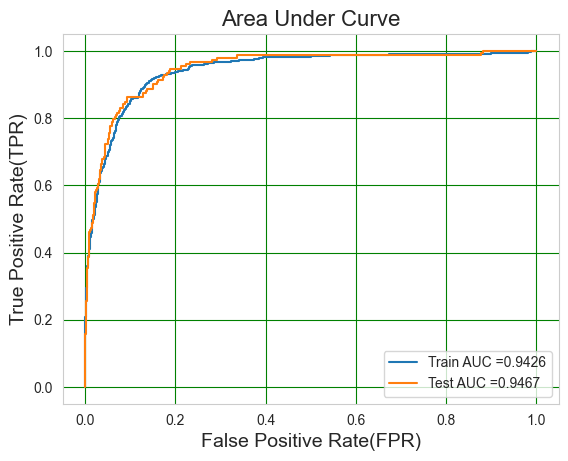

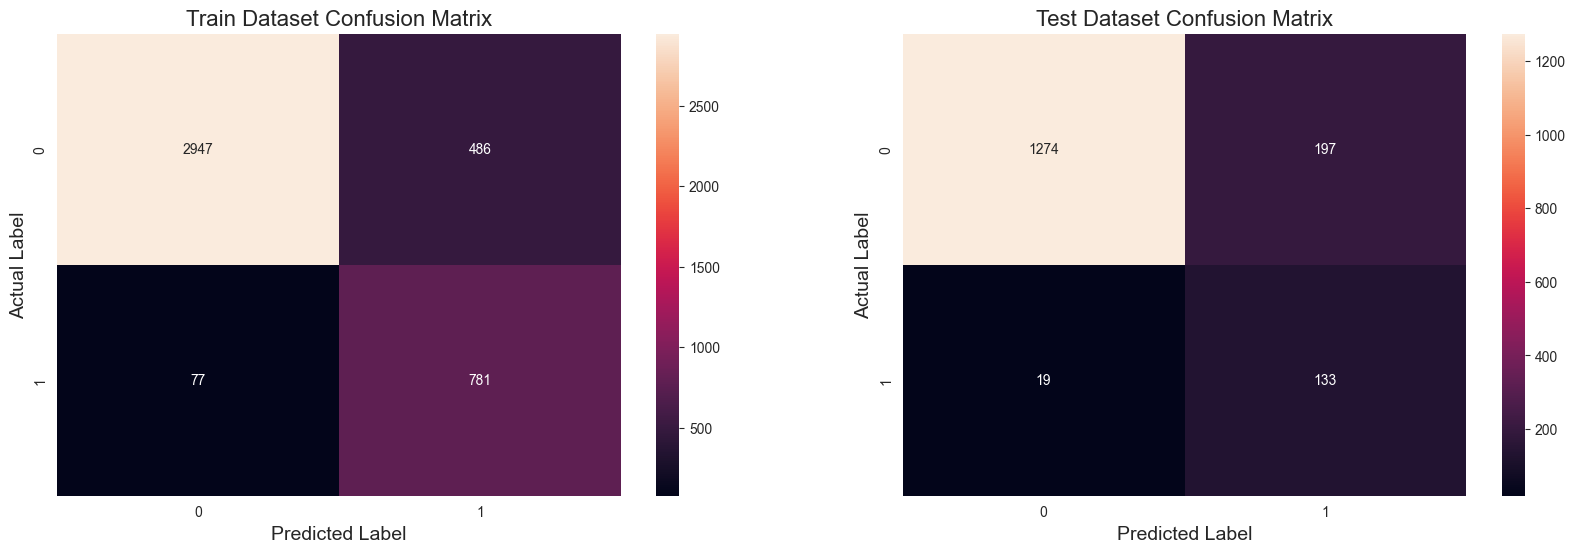

Best Threshold = 0.1213
Model AUC is : 0.9467
Model F1 Score is : 0.5519


In [183]:
# Validate Logistic regression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Decision Tree 

In [184]:
# Identify optimal parameters for Decision tree classifier model
decisiontree = DecisionTreeClassifier() #class_weight = 'balanced'

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250], 
              'min_samples_split': [5, 10, 50, 100, 150, 200]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250],
                         'min_samples_split': [5, 10, 50, 100, 150, 200]},
             return_train_score=True, scoring='roc_auc')

In [185]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 150}
roc_auc_score : 0.9360504476308952


In [186]:
# Fitting the Decision tree classifier model
decision_tree = DecisionTreeClassifier(max_depth = 5, min_samples_split = 150, criterion = 'entropy')
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=150)

Train AUC =  0.9501154976686581
Test AUC =  0.9255966224194068


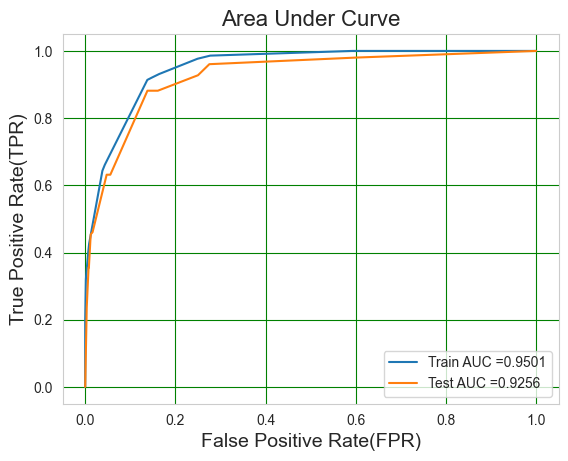

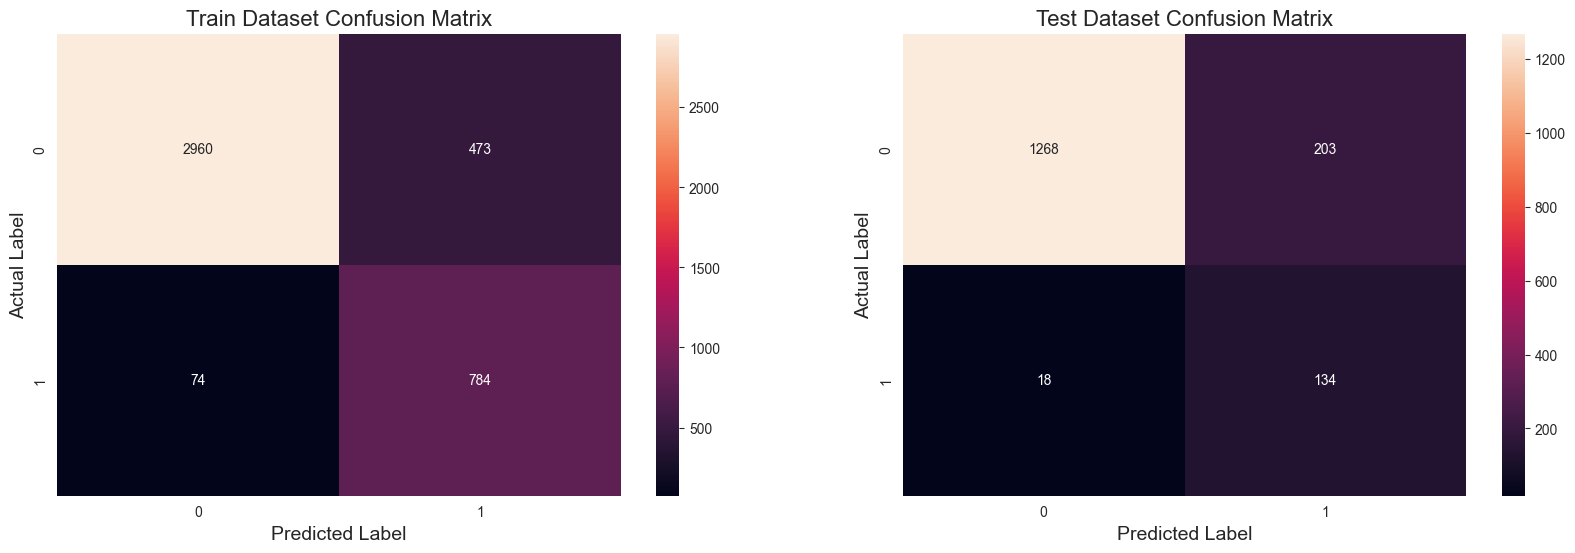

Best Threshold = 0.4011
Model AUC is : 0.9256
Model F1 Score is : 0.5481


In [187]:
# Validate Decision tree classifier model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Linear Support Vector Classifier 

In [188]:
# Identify optimal parameters for linear support vector classifier model
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [189]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.9387415719131138


In [190]:
# Fitting the linear support vector classifier model
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5))

Train AUC =  0.9498973693555691
Test AUC =  0.9353778310494115


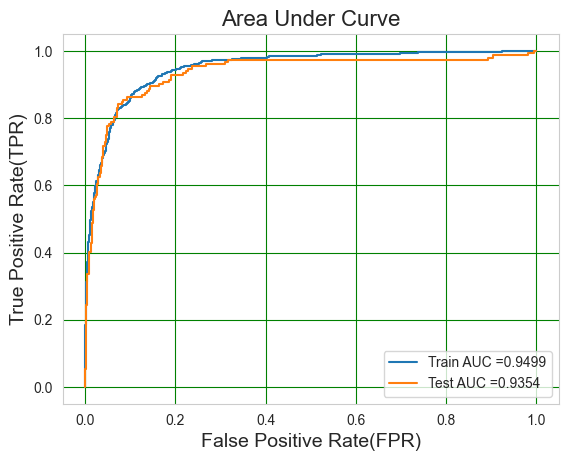

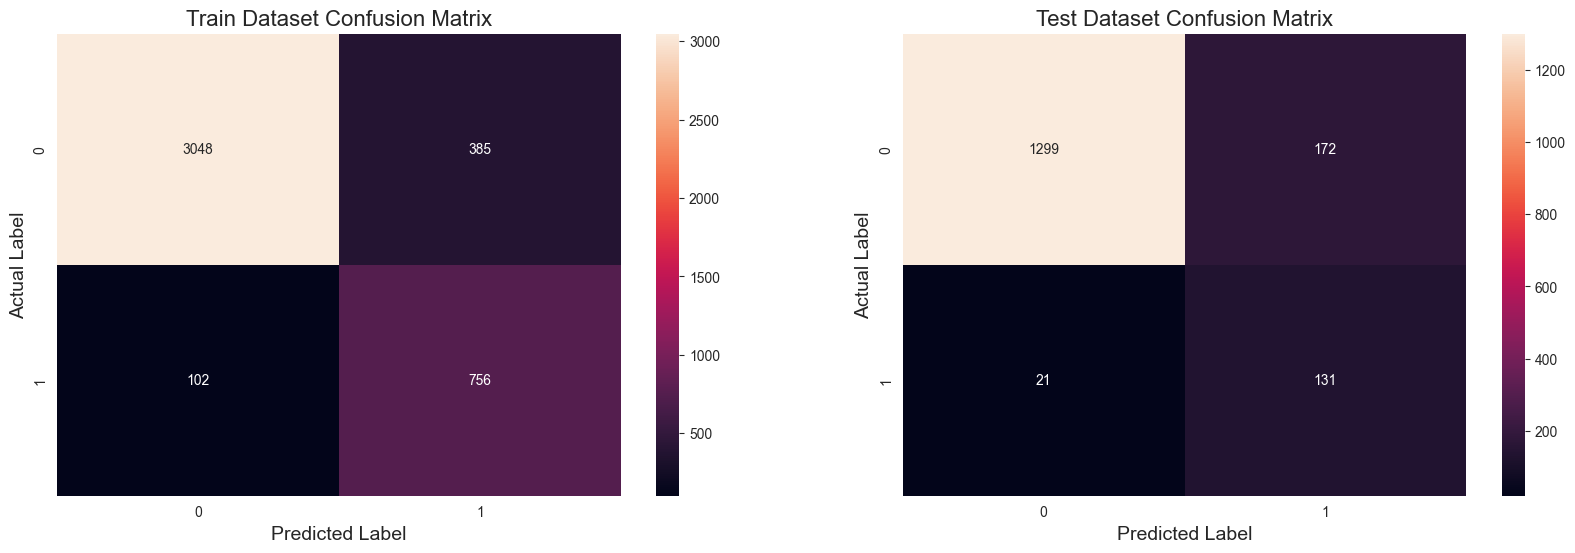

Best Threshold = 0.1570
Model AUC is : 0.9354
Model F1 Score is : 0.5758


In [191]:
# Validate the linear support vector classifer model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Random Forest Classifier

In [192]:
# Identify optimal parameters for Random forest classifier model
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [10, 20, 30, 50]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os, y_tr_os)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 50]},
                   return_train_score=True, scoring='roc_auc')

In [193]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 30, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 20}
roc_auc_score : 0.9694679428763916


In [194]:
# Fitting the random forest classifier model
random_forest = RandomForestClassifier(n_estimators=30, min_samples_split=2, max_features='auto', max_depth=20, random_state=42)
random_forest.fit(x_tr_os, y_tr_os)

RandomForestClassifier(max_depth=20, max_features='auto', n_estimators=30,
                       random_state=42)

Train AUC =  0.9999964352571402
Test AUC =  0.9262048731618305


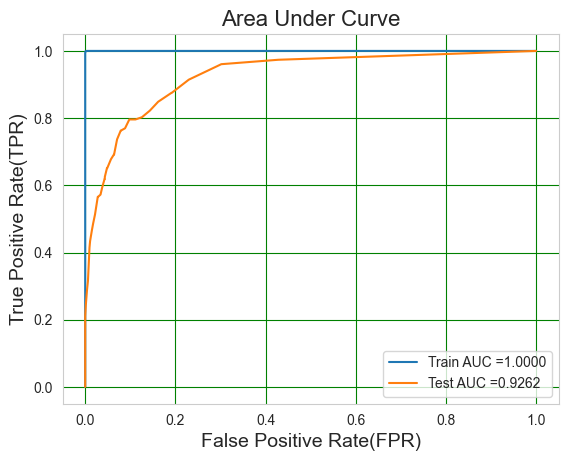

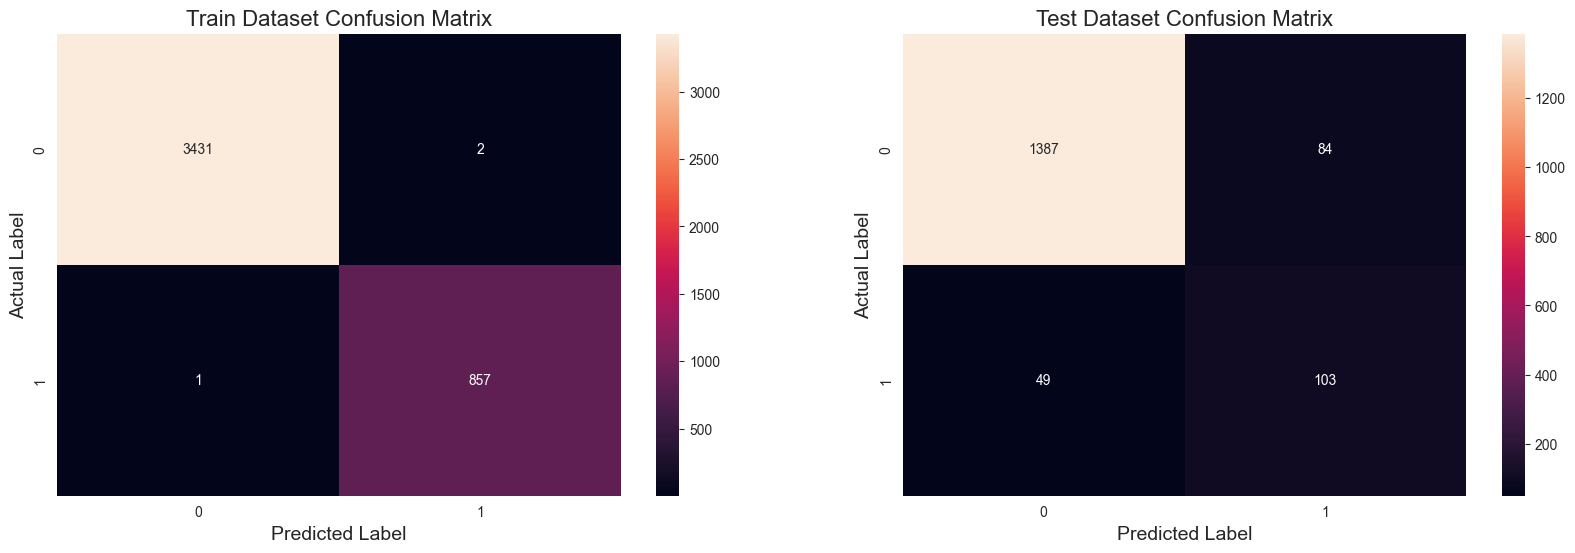

Best Threshold = 0.4667
Model AUC is : 0.9262
Model F1 Score is : 0.6077


In [195]:
# Validate random forest classifier model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

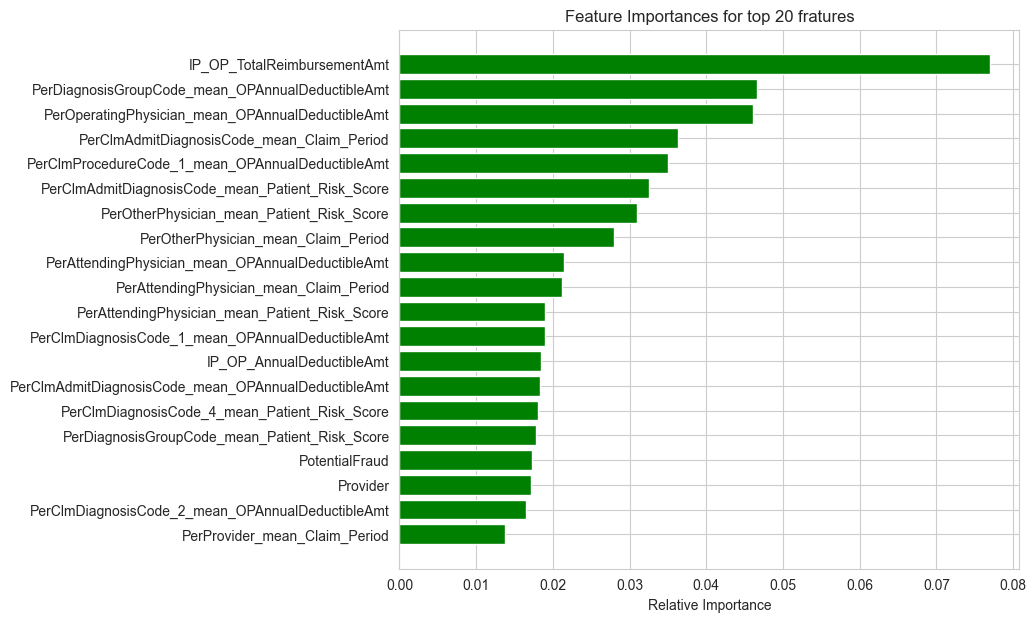

In [196]:
# Plot top 20 features
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
top_20_indices = imp_feature_indx[-20:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()

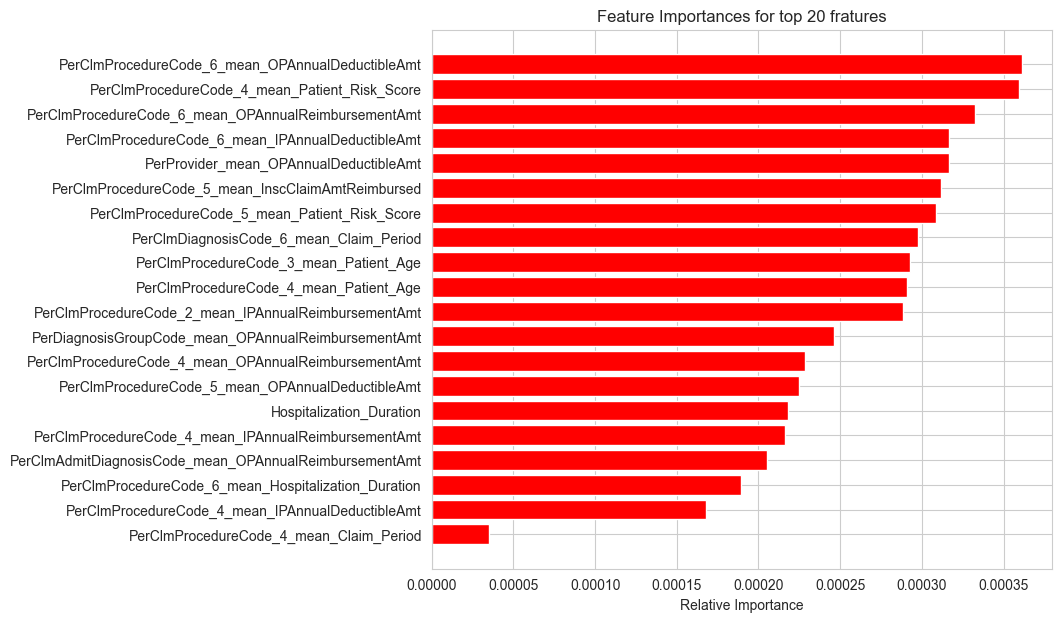

In [197]:
# Plot least important 20 features
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
least_20_indices = imp_feature_indx[:20]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(least_20_indices)), importance_of_feature[least_20_indices], color='r', align='center')
plt.yticks(range(len(least_20_indices)), [features[i] for i in least_20_indices])
plt.xlabel('Relative Importance')
plt.show()

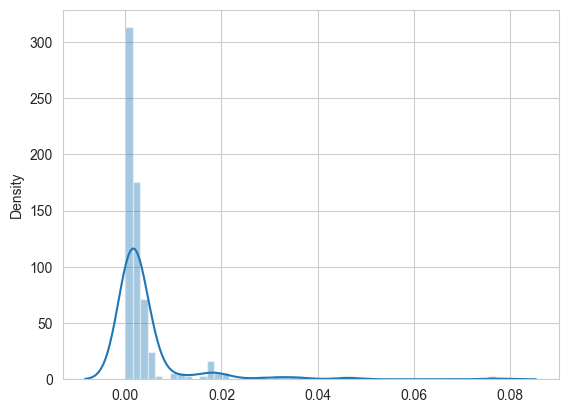

In [198]:
# plot the distribution of features with FE>0
importance_of_feature = random_forest.feature_importances_
%matplotlib inline
sns.distplot(importance_of_feature[importance_of_feature>0])
plt.show()

In [199]:
len(importance_of_feature[importance_of_feature>0])

245

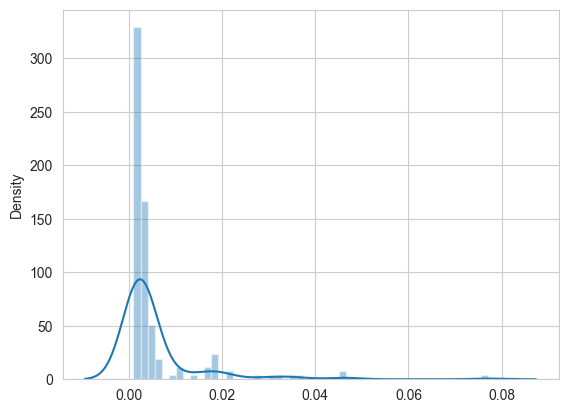

In [200]:
# plot the distribution of features with FE>0.001
sns.distplot(importance_of_feature[importance_of_feature>0.001])
plt.show()

In [201]:
len(importance_of_feature[importance_of_feature>0.001])

170

In [202]:
# take all the feature columns in a list
features = list(x_train.columns)
imp_feature_indx = np.argsort(random_forest.feature_importances_)[::-1]
imp_value = np.take(random_forest.feature_importances_, imp_feature_indx[:170])
imp_feature_name = list(np.take(features, imp_feature_indx[:170]))

#### Model training and testing on important features 

##### Data normalization and train. test split creation for important features data 

In [203]:
x_train_imp_features = x_train[imp_feature_name]
x_train_imp_features.shape

(5410, 170)

In [204]:
x_test_imp_features = x_test[imp_feature_name]
x_test_imp_features.shape

(1353, 170)

In [205]:
standard_scaler = StandardScaler()
standard_scaler.fit(x_train_imp_features)
x_train_if_std = standard_scaler.transform(x_train_imp_features)
x_test_if_std = standard_scaler.transform(x_test_imp_features)

In [206]:
# split the data into train and test
x_tr_if, x_val_if, y_tr_if, y_val_if = train_test_split(x_train_if_std, y_train, test_size=0.3,random_state=42,stratify=y_train)
x_tr_if.shape, x_val_if.shape, y_tr_if.shape, y_val_if.shape

((3787, 170), (1623, 170), (3787,), (1623,))

In [207]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os_if, y_tr_os_if = oversample.fit_resample(x_tr_if, y_tr_if)
counter = Counter(y_tr_os_if)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


#### Logistic Regression on Important Features 

In [208]:
# Identify optimal parameters for logistic regression model
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os_if, y_tr_os_if)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [209]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9376573240918343


In [210]:
# Fitting the logistic regression model
log_reg = LogisticRegression(C=1.0, penalty='l2')
log_reg.fit(x_tr_os_if, y_tr_os_if)

LogisticRegression()

Train AUC =  0.9449308338035398
Test AUC =  0.9381820458692619


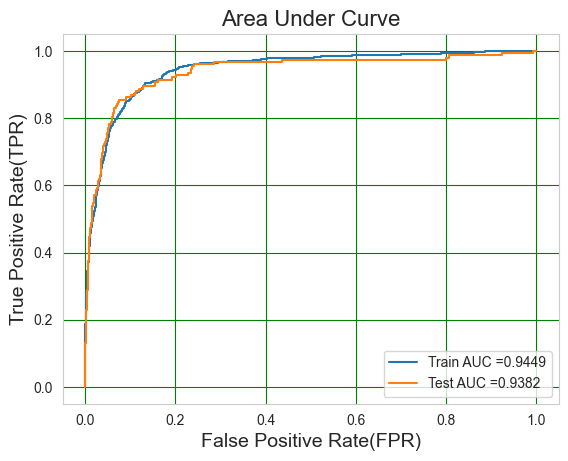

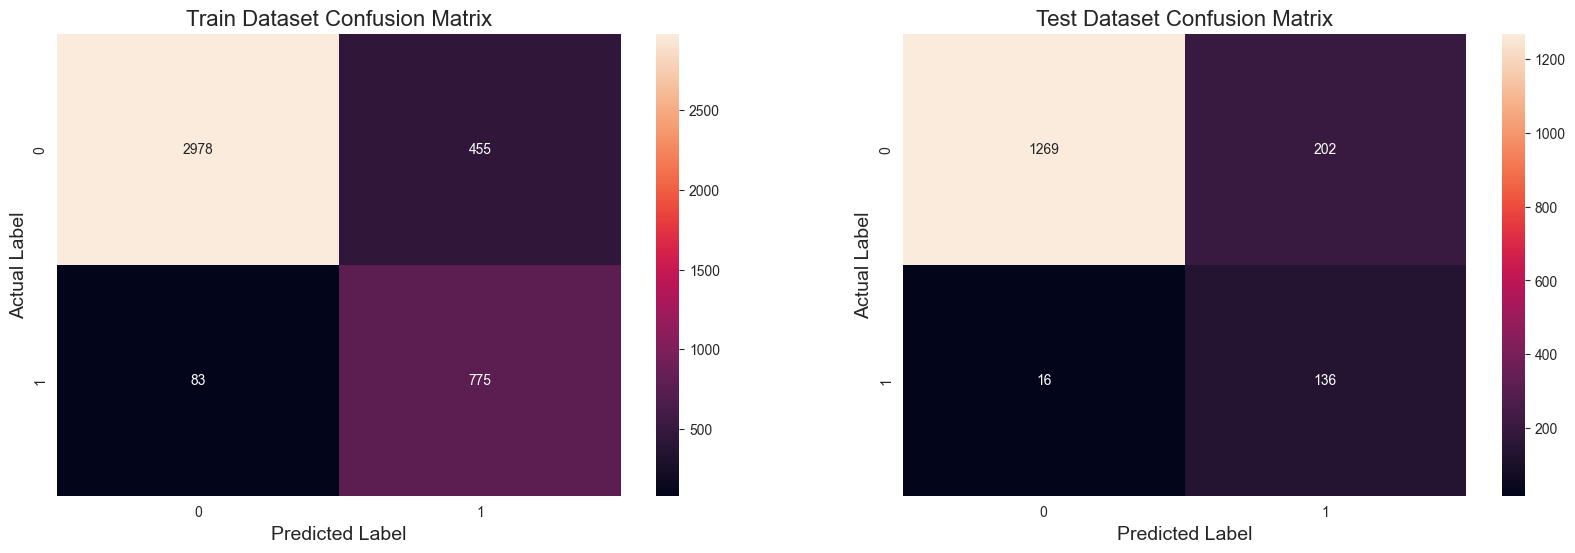

Best Threshold = 0.1238
Model AUC is : 0.9382
Model F1 Score is : 0.5551


In [211]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Random Forest Classifier on Important Features 

In [212]:
# Identify optimal parameters for random forest classifier model
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [10, 20, 30, 50]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os_if, y_tr_os_if)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 50]},
                   return_train_score=True, scoring='roc_auc')

In [213]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 20}
roc_auc_score : 0.9692027053914318


In [214]:
# Fitting the random forest classifier model
random_forest = RandomForestClassifier(n_estimators=20, min_samples_split=5, max_features='sqrt', max_depth=20, random_state=42)
random_forest.fit(x_tr_os_if, y_tr_os_if)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=20,
                       random_state=42)

Train AUC =  0.9998988292026451
Test AUC =  0.9288816236716878


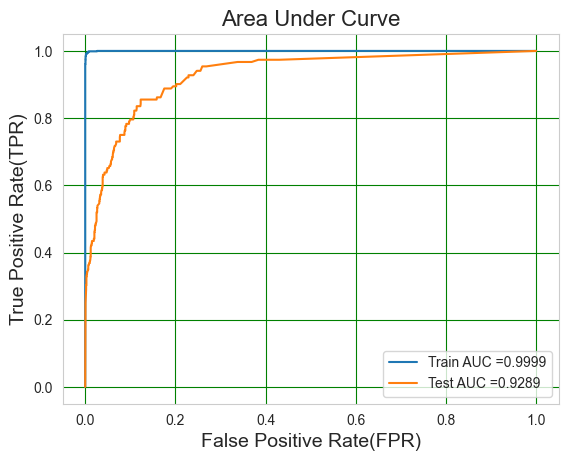

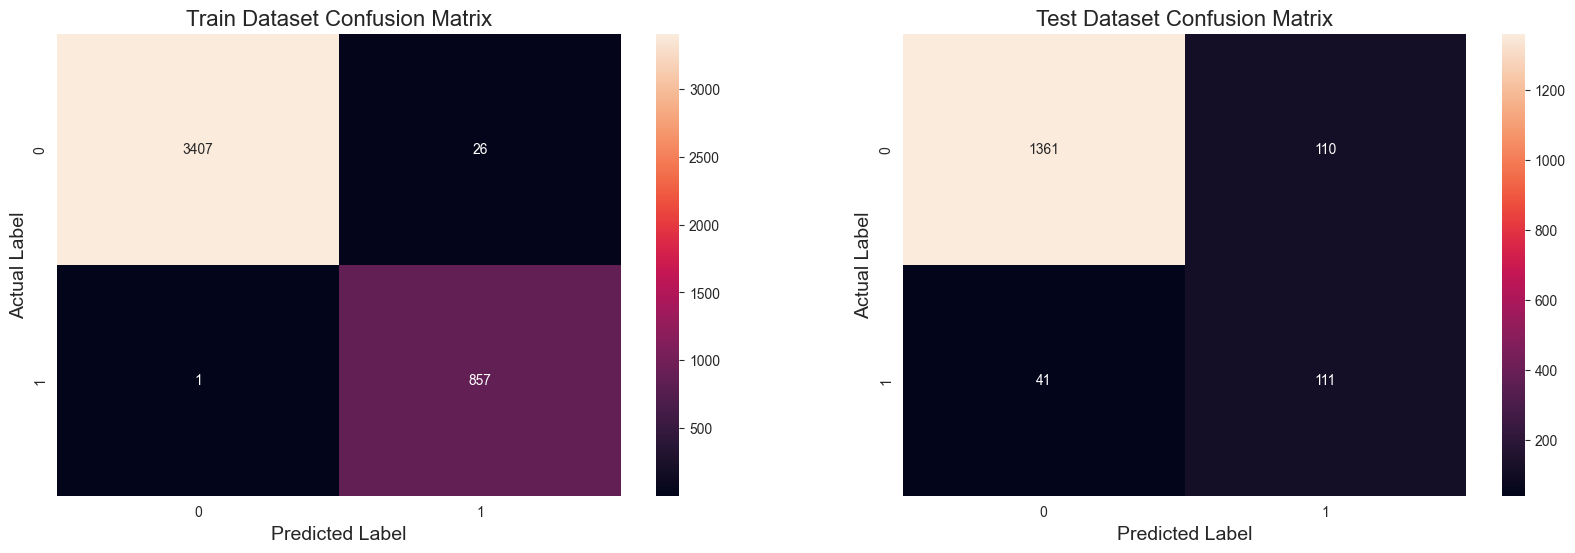

Best Threshold = 0.3761
Model AUC is : 0.9289
Model F1 Score is : 0.5952


In [215]:
# Validate random forest classifier model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### XG Boost Classifier on important features

In [216]:
# Identify optimal parameters for XG boost classifier model
params = {'max_depth': [4, 6, 8, 10],
         'scale_pos_weight': [1, 3, 5],
         'n_estimators': [10, 20, 30]}

xgb = XGBClassifier(random_state=42)
xgb_cv = RandomizedSearchCV(xgb, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
xgb_cv.fit(x_tr_os_if, y_tr_os_if)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 8, 10],
                                        'n_estimators': [10, 20, 30],
                                        'scale_pos_weight': [1, 3, 5]},
                   return_train_score=True, scoring='roc_auc')

In [217]:
print("best parameters = ",xgb_cv.best_params_)
print("roc_auc_score :",xgb_cv.best_score_)

best parameters =  {'scale_pos_weight': 3, 'n_estimators': 30, 'max_depth': 8}
roc_auc_score : 0.9743340422872739


In [218]:
# Fitting the XG boost classiifer model
xgb = XGBClassifier(n_estimators=30, max_depth=8, scale_pos_weight = 3, random_state=42)
xgb.fit(x_tr_os_if, y_tr_os_if)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

Train AUC =  1.0
Test AUC =  0.935596980213961


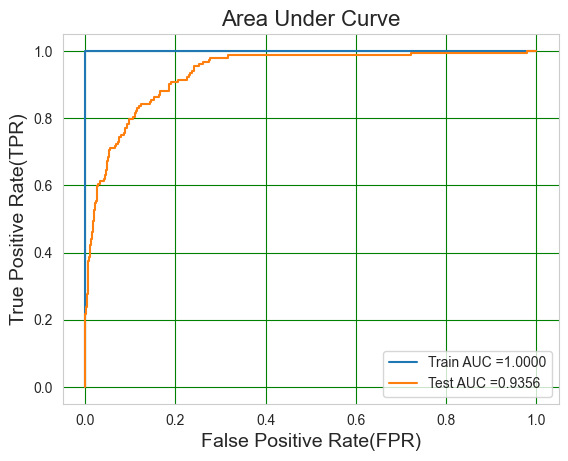

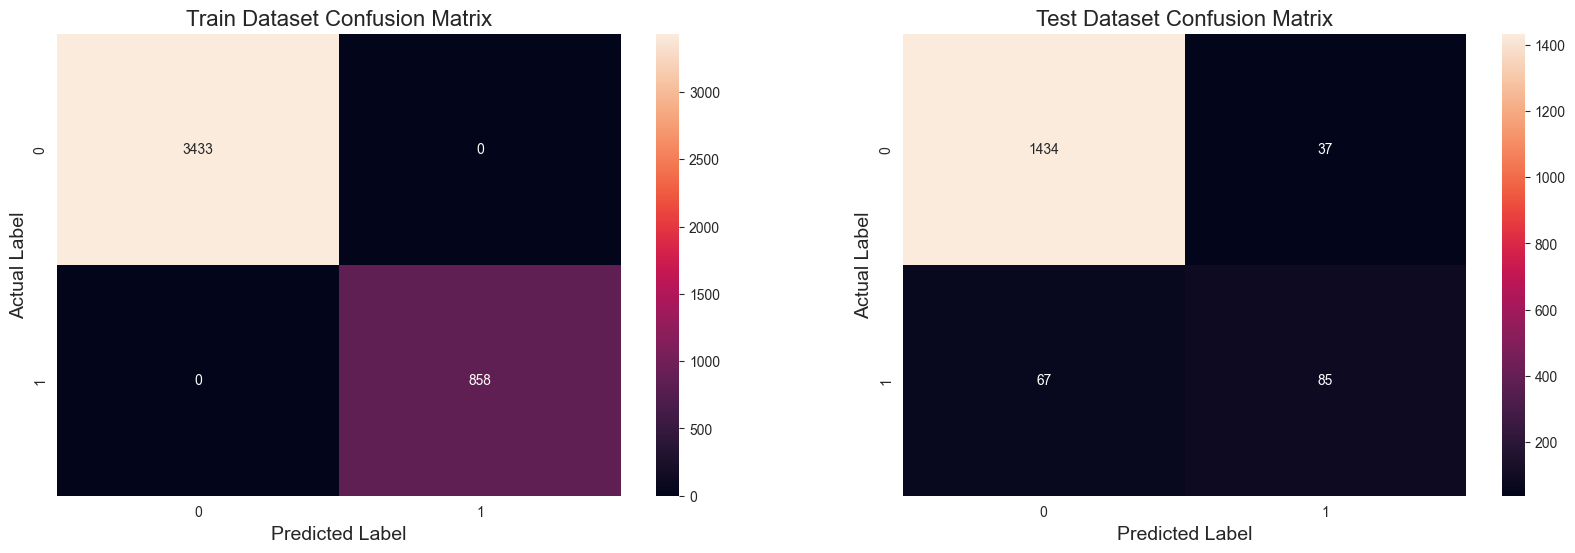

Best Threshold = 0.8125
Model AUC is : 0.9356
Model F1 Score is : 0.6204


In [219]:
# Validate XG boost classifier model
test_auc, test_f1_score, best_t = validate_model(xgb, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

##### Transforming the train, test data for fitting the neural network 

In [220]:
xtrain=x_tr_os_if.astype(np.float32)
xtest=x_val_if.astype(np.float32)
ytrain=y_tr_os_if.astype(np.float32).to_numpy()
ytest=y_val_if.astype(np.float32).to_numpy()


ytrain=ytrain.reshape(ytrain.shape+(1,))
ytest=ytest.reshape(ytest.shape+(1,))

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(4291, 170)
(1623, 170)
(4291, 1)
(1623, 1)


In [221]:
# Defining neural network classifier model
inpt=tf.keras.layers.Input((xtrain.shape[1]))
d1=tf.keras.layers.Dense(256, activation='relu')(inpt)
d1=tf.keras.layers.Dense(128, activation='relu')(d1)

d2=tf.keras.layers.Dense(1,activation="sigmoid")(d1)

neural_network=tf.keras.Model(inputs=inpt,outputs=d2)
neural_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 170)]             0         
                                                                 
 dense (Dense)               (None, 256)               43776     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 76,801
Trainable params: 76,801
Non-trainable params: 0
_________________________________________________________________


In [222]:
# Compiling and fitting neural network classifier model
neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='binary_crossentropy', metrics=["AUC"])

history_combined=neural_network.fit(xtrain,ytrain,validation_data=(xtest,ytest),batch_size=128,epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 14ms/step - loss: 0.4921 - auc: 0.7912 - val_loss: 0.3236 - val_auc: 0.9236
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 0.3245 - auc: 0.8981 - val_loss: 0.2421 - val_auc: 0.9299
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 0.2977 - auc: 0.9052 - val_loss: 0.2234 - val_auc: 0.9332
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2834 - auc: 0.9146 - val_loss: 0.2169 - val_auc: 0.9369
Epoch 5/100
34/34 [==============================] - 0s 6ms/step - loss: 0.2733 - auc: 0.9194 - val_loss: 0.2083 - val_auc: 0.9383
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 0.2667 - auc: 0.9238 - val_loss: 0.2059 - val_auc: 0.9407
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2598 - auc: 0.9268 - val_loss: 0.1939 - val_auc: 0.9405
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2561 - 

34/34 [==============================] - 0s 5ms/step - loss: 0.2090 - auc: 0.9535 - val_loss: 0.1741 - val_auc: 0.9407
Epoch 64/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2087 - auc: 0.9541 - val_loss: 0.1660 - val_auc: 0.9450
Epoch 65/100
34/34 [==============================] - 0s 6ms/step - loss: 0.2084 - auc: 0.9547 - val_loss: 0.1812 - val_auc: 0.9411
Epoch 66/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2086 - auc: 0.9533 - val_loss: 0.1933 - val_auc: 0.9453
Epoch 67/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2092 - auc: 0.9537 - val_loss: 0.1801 - val_auc: 0.9450
Epoch 68/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2064 - auc: 0.9540 - val_loss: 0.1736 - val_auc: 0.9443
Epoch 69/100
34/34 [==============================] - 0s 6ms/step - loss: 0.2061 - auc: 0.9561 - val_loss: 0.1732 - val_auc: 0.9420
Epoch 70/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2062 - auc: 0

51/51 [==============================] - 0s 2ms/step
Train AUC =  0.9637126151836318
Test AUC =  0.9332400085870692


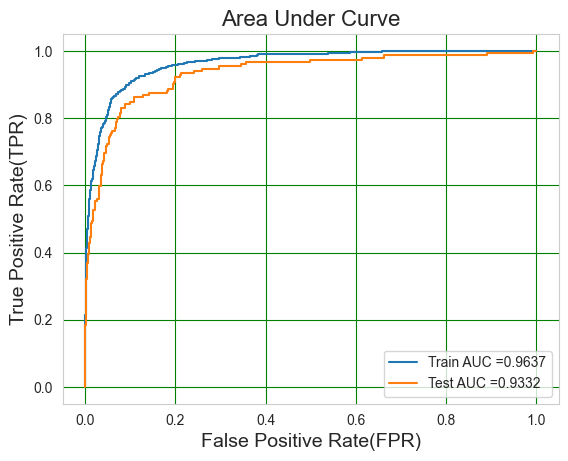

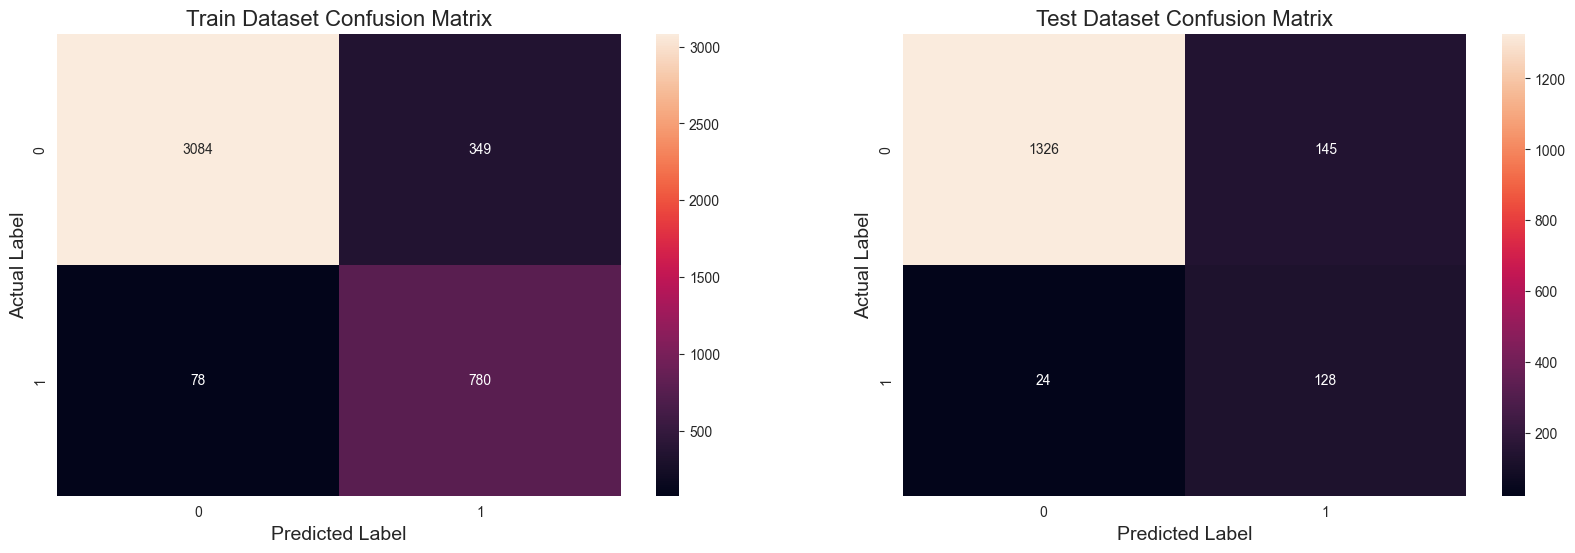

Best Threshold = 0.2647
Model AUC is : 0.9332
Model F1 Score is : 0.6024


In [223]:
# Validating the neural network classifier model
# predict the probability of train data
y_train_pred = neural_network.predict(xtrain)
# predict the probability of test data
y_test_pred = neural_network.predict(xtest)
# calculate tpr, fpr for diffeent thresholds using roc_curve
train_fpr, train_tpr, tr_thresholds = roc_curve(ytrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(ytest, y_test_pred)

# calculate auc for train and test
train_auc = auc(train_fpr, train_tpr)
print("Train AUC = ", train_auc)
test_auc = auc(test_fpr, test_tpr)
print("Test AUC = ", test_auc)

draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

train_prediction, test_prediction = draw_confusion_matrix(best_t, xtrain, xtest, ytrain, ytest, y_train_pred, y_test_pred)
#     print(len(test_prediction))

train_f1_score = f1_score(ytrain, train_prediction)
test_f1_score = f1_score(ytest, test_prediction)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Models performance comparision 

AUC and F1-score are considered as the metrics to evalaute and compare models performances.

In [224]:
table = BeautifulTable() 
table.column_headers= ["      Model       ", "    Features          ", "  AUC   ", "F1 Score"]
table.append_row(["Logistic Reg  ", "All Features","0.9467", "0.5519"])
table.append_row(["Decision Tree  ", "All Features","0.9256", "0.5481"])
table.append_row(["Linear SVC  ", "All Features","0.9354", "0.5758"])
table.append_row(["Random Forest ", "All Features","0.9262", "0.6077"])
table.append_row(["Logistic Reg  ", "Important Features","0.9382", "0.5551"])
table.append_row(["Random Forest ", "Important Features","0.9289", "0.5952"])
table.append_row(["XG Boost ", "Important Features","0.9356", "0.6204"])
table.append_row(["Neural Network ", "Important Features","0.9332", "0.6024"])
print(table)

+--------------------+------------------------+----------+----------+
|       Model        |     Features           |   AUC    | F1 Score |
+--------------------+------------------------+----------+----------+
|   Logistic Reg     |      All Features      |  0.947   |  0.552   |
+--------------------+------------------------+----------+----------+
|  Decision Tree     |      All Features      |  0.926   |  0.548   |
+--------------------+------------------------+----------+----------+
|    Linear SVC      |      All Features      |  0.935   |  0.576   |
+--------------------+------------------------+----------+----------+
|   Random Forest    |      All Features      |  0.926   |  0.608   |
+--------------------+------------------------+----------+----------+
|   Logistic Reg     |   Important Features   |  0.938   |  0.555   |
+--------------------+------------------------+----------+----------+
|   Random Forest    |   Important Features   |  0.929   |  0.595   |
+-------------------

### Conclusion 

1. Random Forest Classifier is performing better with all the feature but it's having high false positive rate, to mitigate the same modelling on selected important features has been done.
2. Ensemble, Boosting and Neural network models have been tried on the important features for modelling.
3. Random forest classifier is outperformed by XG Boost.
4. XG Boost and Neural Network classifier have nearly same results.
5. XG Boost has been selected as the final model for healthcare fraud prediction.